In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle
import matplotlib

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
from neurolib.utils import func_optimize as fo
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
import neurolib.dashboard.layout as layout

    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

cmap_ = layout.getcolormap()
darkgrey, midgrey, lightgrey, color_bi_updown, color_LC, color_bi_uposc = layout.getcolors()
exc_red = cmap_(3)
inh_blue=cmap_(0)
green = cmap_(2)

not here


In [2]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

In [3]:
##### LOAD BOUNDARIES
data_file = '..' + os.sep + '..' + os.sep + 'bi.pickle'
with open(data_file,'rb') as f:
    load_array= pickle.load(f)
exc = load_array[0]
inh = load_array[1]

In [4]:
bestControl = [None] * len(exc)
bestState = [None] * len(exc)
cost_ = [None] * len(exc)
runtime = [None] * len(exc)
grad = [None] * len(exc)
phi = [None] * len(exc)
costnode = [None] * len(exc)
weights = [None] * len(exc)

In [5]:
initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)

cgv_list = [None, "HS", "FR", "PR", "CD", "LS", "DY", "WYL", "HZ", None]

In [6]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-32
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

### CURRENTS
cntrl_vars_0 = [0,1]
prec_vars = [0]

dur = 100
trans_time = 0.8
maxC = [5., -5., 0.18, 0.]
n_dur = int(np.around(dur/aln.params.dt + 1.,1))
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

case = '1'

if case == '1':
    max_I = [3., -3.]
    factor_ws = 1.
    factor_we = 0.
    read_file = '..' + os.sep + 'data_final_2' + os.sep + 'control_1.pickle'

In [7]:
if os.path.isfile(read_file) :
    print("file found")
    
    with open(read_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl = load_array[0]
    bestState = load_array[1]
    cost_ = load_array[2]
    costnode = load_array[3]
    weights = load_array[4]

In [8]:
i_range = [20]
stable_state = np.zeros(( len(exc), 2,2,2, 2))

In [9]:
# get init vars without noise

data.set_parameters(aln)
aln.params.duration = 3000.

control0 = functions.step_control(aln, maxI_ = max_I[1])

# low state without noise
for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    
    stable_state[i,0,0,0,0] = aln.rates_exc[0,-1]
    stable_state[i,0,0,1,0] = aln.rates_inh[0,-1]

# high state without noise
control0 = aln.getZeroControl()
control0[0,0,:500] = 5.

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    aln.params.duration = 3000.
    aln.run(control=control0)
    stable_state[i,0,1,0,0] = aln.rates_exc[0,-1]
    stable_state[i,0,1,1,0] = aln.rates_inh[0,-1]
    
    aln.params.duration = dur
    target_det = aln.getZeroTarget()
    target_det[:,0,:] = aln.rates_exc[0,-1]
    target_det[:,1,:] = aln.rates_inh[0,-1]
    
    print('exc low, high ', stable_state[i,0,0,0,0], stable_state[i,0,1,0,0])
    print('inh low, high ', stable_state[i,0,0,1,0], stable_state[i,0,1,1,0])

-------  20 0.4500000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
exc low, high  0.00020800079839487667 35.69070596632364
inh low, high  22.354548572416867 90.39821580372033


In [10]:
# get initial parameters and target states with noise

sigma_ou = 0.1
noise_realizations_final = 10000

# set target with noise
aln.params.sigma_ou = sigma_ou
aln.params.duration = 300.
control0 = aln.getZeroControl()
control0[0,0,:500] = 5.

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    target_rates_e = []
    target_rates_i = []

    for j in range(noise_realizations_final):
        aln.params.duration = 300.
        aln.run(control=control0)
        if np.amin(aln.rates_exc[0,1000:]) < 1.:
            print("fell in down state, repeat")
            j -= 1
            continue
        target_rates_e.append(aln.rates_exc[0,1000:])
        target_rates_i.append(aln.rates_inh[0,1000:])

    aln.params.duration = dur
    target[i] = aln.getZeroTarget()
    target[i][:,0,:] = np.mean(target_rates_e)
    target[i][:,1,:] = np.mean(target_rates_i)
    
    stable_state[i,1,1,0,0] = target[i][0,0,-1]
    stable_state[i,1,1,1,0] = target[i][0,1,-1]
    stable_state[i,1,1,0,1] = np.std(target_rates_e)
    stable_state[i,1,1,1,1] = np.std(target_rates_i)
    
    
aln.params.duration = 300.
control0 = aln.getZeroControl()
control0[0,0,:500] = -5.

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    target_rates_e = []
    target_rates_i = []

    for j in range(noise_realizations_final):
        aln.params.duration = 300.
        aln.run(control=control0)
        if np.amin(aln.rates_exc[0,1000:]) > 10.:
            print("fell in up state, repeat")
            j -= 1
            continue
        target_rates_e.append(aln.rates_exc[0,1000:])
        target_rates_i.append(aln.rates_inh[0,1000:])

    stable_state[i,1,0,0,0] = np.mean(target_rates_e)
    stable_state[i,1,0,1,0] = np.mean(target_rates_i)
    stable_state[i,1,0,0,1] = np.std(target_rates_e)
    stable_state[i,1,0,1,1] = np.std(target_rates_i)
    
print('exc low, high with noise ', stable_state[i,1,0,0,0], stable_state[i,1,1,0,0])
print('inh low, high with noise ', stable_state[i,1,0,1,0], stable_state[i,1,1,1,0])

-------  20 0.4500000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
exc low, high with noise  0.0008300513644576752 35.256054856872524
inh low, high with noise  22.483326205831574 90.03596411371139


In [11]:
diff_low = np.zeros(( 83,2 ))
diff_high = np.zeros(( 83,2 ))

for i in i_range:
    print('------  ', i)
    diff_low[i,:] = [stable_state[i,0,0,0,0] - stable_state[i,1,0,0,0],
                stable_state[i,0,0,1,0] - stable_state[i,1,0,1,0]]
    print("difference in low rate exc/ inh: ", diff_low[i,:])
    print("std dev low rate exc/ inh: ", stable_state[i,1,0,0,1], stable_state[i,1,0,1,1])
    diff_high[i,:] =  [stable_state[i,0,1,0,0] - stable_state[i,1,1,0,0],
                 stable_state[i,0,1,1,0] - stable_state[i,1,1,1,0]]
    print("difference in high rate exc/ inh: ", diff_high[i,:])
    print("std dev high rate exc/ inh: ", stable_state[i,1,1,0,1], stable_state[i,1,1,1,1])

------   20
difference in low rate exc/ inh:  [-0.00062205 -0.12877763]
std dev low rate exc/ inh:  0.0034573000715795717 4.134256460102751
difference in high rate exc/ inh:  [0.43465111 0.36225169]
std dev high rate exc/ inh:  5.836705420032297 4.455832474698587


In [12]:
print("Max/ min / min abs diff low rate EXC",
      np.amax(diff_low[:,0]), np.amin(diff_low[:,0]), np.amin(np.abs(diff_low[:,0])))
print("Max/ min / min abs diff low rate INH",
      np.amax(diff_low[:,1]), np.amin(diff_low[:,1]), np.amin(np.abs(diff_low[:,1])))
print("Max/ min / min abs diff high rate EXC",
      np.amax(diff_high[:,0]), np.amin(diff_high[:,0]), np.amin(np.abs(diff_high[:,0])))
print("Max/ min / min abs diff high rate INH",
      max(diff_high[:,1]), min(diff_high[:,1]), np.amin(np.abs(diff_high[:,1])))
print('---')
for i in i_range:
    if diff_high[i,0] < 0.:
        print(i, diff_high[i], ' low ', stable_state[i,1,0,:,0], 'high ', stable_state[i,1,1,:,0])
print('---')
for i in i_range:
    if diff_high[i,1] > 0.:
        print(i, diff_high[i], ' low ', stable_state[i,1,0,:,0], 'high ', stable_state[i,1,1,:,0])

Max/ min / min abs diff low rate EXC 0.0 -0.0006220505660627986 0.0
Max/ min / min abs diff low rate INH 0.0 -0.12877763341470683 0.0
Max/ min / min abs diff high rate EXC 0.4346511094511172 0.0 0.0
Max/ min / min abs diff high rate INH 0.3622516900089465 0.0 0.0
---
---
20 [0.43465111 0.36225169]  low  [8.30051364e-04 2.24833262e+01] high  [35.25605486 90.03596411]


In [13]:
init_control_noisefree = bestControl[20]

w_e = 0.
w_s = 1.
w_p = np.zeros(( len(exc) ))

for i in i_range:
    w_p[i] = 1. / ( ( stable_state[i,1,1,0,1] + stable_state[i,1,1,1,1] ) * (1. - trans_time) * dur / aln.params.dt )

In [14]:
dur = 100.
max_it = 10
noise_realizations = 80
noise_realizations_final = 20000
aln.params.sigma_ou = sigma_ou
prec_vars = [0,1]
i = 20

control_list = [None, None, None, None] # 4 methods
cost_list = [None, None, None, None]
mean_cost = [ None, None, None, None ]

In [15]:
aln.params.duration = dur
zero_init = aln.getZeroControl()

aln.params.ext_exc_current = exc[i] * 5.
aln.params.ext_inh_current = inh[i] * 5.

print("------- ", i, exc[i], inh[i], noise_realizations)

##### zero control as input for uncontrolled cost
cost.setParams(w_p[i], w_e, w_s)

m1_control_list = []
m1_cost_list = []

control_list[0] = np.zeros(( zero_init.shape[0], zero_init.shape[1], zero_init.shape[2]+200 ))
cost_list[0] = np.zeros(( max_it+1 ))
cost_n = np.zeros(( max_it + 1 ))

min_it = 10
n_ = 0

while n_  < noise_realizations:
    print("---------", n_)
    mean_cost[0] = []
    setinit(initVars[i], aln)

    bestControl[i], bestState[i], cost_[i], runtime[i], grad[i], phi[i], costnode[i], total_cost_mean_std = aln.A1(
        zero_init, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
        control_variables_ = [0,1], prec_variables_ = prec_vars, transition_time_ = trans_time,
        noise_real=0, init_params = initVars[i])
    
    if cost_[i][min_it] == 0:
        continue
        
    max_jump = 0.
    for v_ in range(bestControl[i].shape[1]):
        for t_ in range(1, bestControl[i].shape[2]):
            diff = np.abs(bestControl[i][0,v_,t_] - bestControl[i][0,v_,t_-1])
            if  diff > max_jump:
                max_jump = diff
                
    if max_jump > 0.5:
        continue
    
    m1_control_list.append(bestControl[i])
    control_list[0] += bestControl[i]
    m1_cost_list.append(cost_[i])
    cost_list[0] += cost_[i]
    
    for c_ in range(len(cost_[i])):
        if cost_[i][c_] != 0.:
            cost_n[c_] += 1
            
    n_ += 1
    
control_list[0] /= noise_realizations
for c_ in range(len(cost_list[0])):
    cost_list[0][c_] /= cost_n[c_]
    
print(cost_list[0])
print('IMPROVEMENT : ', 100. -  100.*cost_list[0][-1]/cost_list[0][0])

-------  20 0.4500000000000001 0.4750000000000002 80
set cost params:  0.00048578883567284984 0.0 1.0
--------- 0
interpolate adjoint :  True True True
initial cost =  136.77773728353003
RUN  0 , total integrated cost =  136.77773728353003
Gradient descend method:  None
RUN  1 , total integrated cost =  42.41817129854015
RUN  2 , total integrated cost =  41.36045474061161
RUN  3 , total integrated cost =  41.047724756110426
RUN  4 , total integrated cost =  40.18431582370394
RUN  5 , total integrated cost =  40.21891303915024
RUN  6 , total integrated cost =  40.482736554326976
RUN  7 , total integrated cost =  39.90675045754279
RUN  8 , total integrated cost =  39.855175972196506
RUN  9 , total integrated cost =  39.816891470609335
RUN  10 , total integrated cost =  39.87758155551727
RUN  10 , total integrated cost =  39.87758155551727
Improved over  10  iterations in  12.825416806999783  seconds by  70.84497642123293  percent.
--------- 0
interpolate adjoint :  True True True
initial

RUN  1 , total integrated cost =  41.98074735112762
RUN  2 , total integrated cost =  40.6647572233636
RUN  3 , total integrated cost =  40.33295342852254
RUN  4 , total integrated cost =  40.59603186344034
RUN  5 , total integrated cost =  40.28260077320819
RUN  6 , total integrated cost =  40.2169512157421
RUN  7 , total integrated cost =  40.19520094833499
RUN  8 , total integrated cost =  39.97369782318439
RUN  9 , total integrated cost =  40.21354263841459
RUN  10 , total integrated cost =  39.93393906661393
RUN  10 , total integrated cost =  39.93393906661393
Improved over  10  iterations in  0.6135010009993493  seconds by  69.28300311488177  percent.
--------- 8
interpolate adjoint :  True True True
initial cost =  138.92198136607752
RUN  0 , total integrated cost =  138.92198136607752
Gradient descend method:  None
RUN  1 , total integrated cost =  41.77143877053383
RUN  2 , total integrated cost =  40.405369143252756
RUN  3 , total integrated cost =  40.163589344627944
RUN  4 

RUN  4 , total integrated cost =  40.36960656740772
RUN  5 , total integrated cost =  40.32845322959566
RUN  6 , total integrated cost =  40.13619668581302
RUN  7 , total integrated cost =  40.024887960943246
RUN  8 , total integrated cost =  40.00799914217968
RUN  9 , total integrated cost =  40.14368388130177
RUN  10 , total integrated cost =  40.06079419401678
RUN  10 , total integrated cost =  40.06079419401678
Improved over  10  iterations in  0.3942114089995812  seconds by  71.18969303300508  percent.
--------- 13
interpolate adjoint :  True True True
initial cost =  129.75465668763007
RUN  0 , total integrated cost =  129.75465668763007
Gradient descend method:  None
RUN  1 , total integrated cost =  42.71046113548471
RUN  2 , total integrated cost =  40.62844101047425
RUN  3 , total integrated cost =  40.545086800910205
RUN  4 , total integrated cost =  40.30903860731708
RUN  5 , total integrated cost =  39.97915164160289
RUN  6 , total integrated cost =  40.43243943395564
RUN 

--------- 21
interpolate adjoint :  True True True
initial cost =  133.38513395302257
RUN  0 , total integrated cost =  133.38513395302257
Gradient descend method:  None
RUN  1 , total integrated cost =  41.494257766076764
RUN  2 , total integrated cost =  40.05574249220527
RUN  3 , total integrated cost =  40.142032794470225
RUN  4 , total integrated cost =  39.886260495013026
RUN  5 , total integrated cost =  39.91058156168994
RUN  6 , total integrated cost =  39.871296260674896
RUN  7 , total integrated cost =  40.214506736124235
RUN  8 , total integrated cost =  40.04705242492105
RUN  9 , total integrated cost =  40.09111442140993
RUN  10 , total integrated cost =  40.09849321883671
RUN  10 , total integrated cost =  40.09849321883671
Improved over  10  iterations in  0.5246505630002503  seconds by  69.93780938664489  percent.
--------- 22
interpolate adjoint :  True True True
initial cost =  154.44999369630563
RUN  0 , total integrated cost =  154.44999369630563
Gradient descend m

RUN  2 , total integrated cost =  40.30666895237914
RUN  3 , total integrated cost =  40.33376549567257
RUN  4 , total integrated cost =  39.9520628423276
RUN  5 , total integrated cost =  39.85373810255115
RUN  6 , total integrated cost =  39.787593338261956
Control only changes marginally.
RUN  6 , total integrated cost =  39.787593338261956
Improved over  6  iterations in  0.4247015470000406  seconds by  72.141938367278  percent.
--------- 29
interpolate adjoint :  True True True
initial cost =  149.8183182366161
RUN  0 , total integrated cost =  149.8183182366161
Gradient descend method:  None
RUN  1 , total integrated cost =  17.980780906516518
RUN  2 , total integrated cost =  8.57476563423815
RUN  3 , total integrated cost =  6.666570471664475
RUN  4 , total integrated cost =  6.387143361079967
RUN  5 , total integrated cost =  5.816882230157709
RUN  6 , total integrated cost =  5.916967847204914
RUN  7 , total integrated cost =  5.864409476070601
RUN  8 , total integrated cost 

RUN  6 , total integrated cost =  40.223914135551865
RUN  7 , total integrated cost =  40.24938664741539
RUN  8 , total integrated cost =  40.16570617235303
RUN  9 , total integrated cost =  40.07946106976446
RUN  10 , total integrated cost =  40.123963384157406
RUN  10 , total integrated cost =  40.123963384157406
Improved over  10  iterations in  0.4432569730006435  seconds by  69.37680632706711  percent.
--------- 34
interpolate adjoint :  True True True
initial cost =  149.02485405815457
RUN  0 , total integrated cost =  149.02485405815457
Gradient descend method:  None
RUN  1 , total integrated cost =  42.28299303755578
RUN  2 , total integrated cost =  40.63221840480164
RUN  3 , total integrated cost =  40.1869775676452
RUN  4 , total integrated cost =  39.97013509843595
RUN  5 , total integrated cost =  39.77156980103572
RUN  6 , total integrated cost =  39.69746173523317
RUN  7 , total integrated cost =  40.01708953202517
RUN  8 , total integrated cost =  39.55101595987024
RUN 

RUN  2 , total integrated cost =  40.48484852872141
RUN  3 , total integrated cost =  40.74551120360498
RUN  4 , total integrated cost =  40.280428588507526
RUN  5 , total integrated cost =  39.83882436103106
RUN  6 , total integrated cost =  39.80856162500235
RUN  7 , total integrated cost =  40.06990531018598
RUN  8 , total integrated cost =  39.86813453453401
RUN  9 , total integrated cost =  40.01480698705406
RUN  10 , total integrated cost =  39.831709344138034
RUN  10 , total integrated cost =  39.831709344138034
Improved over  10  iterations in  0.44389597400004277  seconds by  69.66938450787544  percent.
--------- 39
interpolate adjoint :  True True True
initial cost =  132.4094228661757
RUN  0 , total integrated cost =  132.4094228661757
Gradient descend method:  None
RUN  1 , total integrated cost =  41.26344661168905
RUN  2 , total integrated cost =  40.982961363483106
RUN  3 , total integrated cost =  40.343262740955396
RUN  4 , total integrated cost =  40.285631205616404
R

RUN  4 , total integrated cost =  40.31235495535218
RUN  5 , total integrated cost =  40.12524914401088
RUN  6 , total integrated cost =  39.969726033232206
RUN  7 , total integrated cost =  40.146781327223444
RUN  8 , total integrated cost =  40.07905190036124
RUN  9 , total integrated cost =  40.15942184376321
RUN  10 , total integrated cost =  40.31588235268683
RUN  10 , total integrated cost =  40.31588235268683
Improved over  10  iterations in  0.39508945499983383  seconds by  71.30823867668201  percent.
--------- 43
interpolate adjoint :  True True True
initial cost =  132.47316230842068
RUN  0 , total integrated cost =  132.47316230842068
Gradient descend method:  None
RUN  1 , total integrated cost =  42.1218928768039
RUN  2 , total integrated cost =  40.190318517957024
RUN  3 , total integrated cost =  40.19685067719044
RUN  4 , total integrated cost =  40.059229404459586
RUN  5 , total integrated cost =  40.23951710230374
RUN  6 , total integrated cost =  40.04322483526392
RU

RUN  5 , total integrated cost =  40.5170083538294
RUN  6 , total integrated cost =  39.81293531974888
RUN  7 , total integrated cost =  39.82653017707889
RUN  8 , total integrated cost =  39.71990295991005
RUN  9 , total integrated cost =  39.934562399886865
RUN  10 , total integrated cost =  39.76966872361985
RUN  10 , total integrated cost =  39.76966872361985
Improved over  10  iterations in  0.3877883319992179  seconds by  69.37673909866281  percent.
--------- 49
interpolate adjoint :  True True True
initial cost =  139.20707251704204
RUN  0 , total integrated cost =  139.20707251704204
Gradient descend method:  None
RUN  1 , total integrated cost =  41.530127989613504
RUN  2 , total integrated cost =  40.72340161522711
RUN  3 , total integrated cost =  40.39404038283352
RUN  4 , total integrated cost =  40.566261975097426
RUN  5 , total integrated cost =  40.35766070879933
RUN  6 , total integrated cost =  40.41163346355277
RUN  7 , total integrated cost =  40.35663466677432
RUN 

RUN  3 , total integrated cost =  40.24608713736414
RUN  4 , total integrated cost =  39.99620897322962
RUN  5 , total integrated cost =  39.90929237283112
RUN  6 , total integrated cost =  39.78695179585438
RUN  7 , total integrated cost =  39.2589257385478
RUN  8 , total integrated cost =  39.59775400316749
RUN  9 , total integrated cost =  39.931555470627345
RUN  10 , total integrated cost =  40.14334548671638
RUN  10 , total integrated cost =  40.14334548671638
Improved over  10  iterations in  0.42749768600060634  seconds by  67.45593824557182  percent.
--------- 55
interpolate adjoint :  True True True
initial cost =  123.70635944703604
RUN  0 , total integrated cost =  123.70635944703604
Gradient descend method:  None
RUN  1 , total integrated cost =  41.52693226427087
RUN  2 , total integrated cost =  40.25224446153421
RUN  3 , total integrated cost =  40.253584026540686
RUN  4 , total integrated cost =  39.97175999728616
RUN  5 , total integrated cost =  39.89179191731766
RUN 

RUN  3 , total integrated cost =  40.68103684619604
RUN  4 , total integrated cost =  39.797642496453264
RUN  5 , total integrated cost =  39.98662825893945
RUN  6 , total integrated cost =  40.24315810866821
RUN  7 , total integrated cost =  40.06354902486808
RUN  8 , total integrated cost =  40.10052344466679
RUN  9 , total integrated cost =  39.96504366948642
RUN  10 , total integrated cost =  40.02350925344224
RUN  10 , total integrated cost =  40.02350925344224
Improved over  10  iterations in  0.4159085499995854  seconds by  68.3955629030456  percent.
--------- 60
interpolate adjoint :  True True True
initial cost =  155.71909461321255
RUN  0 , total integrated cost =  155.71909461321255
Gradient descend method:  None
RUN  1 , total integrated cost =  13.841382045849326
RUN  2 , total integrated cost =  14.819637649572535
RUN  3 , total integrated cost =  13.734006518392444
RUN  4 , total integrated cost =  11.112540649802115
RUN  5 , total integrated cost =  10.432763265170694
R

RUN  2 , total integrated cost =  10.36817020691286
RUN  3 , total integrated cost =  6.356769267710745
RUN  4 , total integrated cost =  5.58398605496329
RUN  5 , total integrated cost =  6.547700010368927
RUN  6 , total integrated cost =  5.718807005136123
RUN  7 , total integrated cost =  4.934978395472481
Control only changes marginally.
RUN  7 , total integrated cost =  4.934978395472481
Improved over  7  iterations in  0.6627867120005249  seconds by  96.56537506730616  percent.
--------- 66
interpolate adjoint :  True True True
initial cost =  143.17779460774483
RUN  0 , total integrated cost =  143.17779460774483
Gradient descend method:  None
RUN  1 , total integrated cost =  42.035856663254926
RUN  2 , total integrated cost =  40.742754928237545
RUN  3 , total integrated cost =  39.967368358401714
RUN  4 , total integrated cost =  39.83919736219896
RUN  5 , total integrated cost =  40.088766065619666
RUN  6 , total integrated cost =  39.847590458937646
RUN  7 , total integrate

--------- 70
interpolate adjoint :  True True True
initial cost =  131.36835459963703
RUN  0 , total integrated cost =  131.36835459963703
Gradient descend method:  None
RUN  1 , total integrated cost =  40.93211986979519
RUN  2 , total integrated cost =  40.23356929622149
RUN  3 , total integrated cost =  40.10085736939144
RUN  4 , total integrated cost =  40.24480258949997
RUN  5 , total integrated cost =  40.38627540600841
RUN  6 , total integrated cost =  40.36625924309244
RUN  7 , total integrated cost =  40.354060474987506
RUN  8 , total integrated cost =  40.215383663075315
RUN  9 , total integrated cost =  40.36677300387259
RUN  10 , total integrated cost =  40.07280100577582
RUN  10 , total integrated cost =  40.07280100577582
Improved over  10  iterations in  0.6210545679996358  seconds by  69.49584918841136  percent.
--------- 70
interpolate adjoint :  True True True
initial cost =  135.4163124282134
RUN  0 , total integrated cost =  135.4163124282134
Gradient descend method

--------- 75
interpolate adjoint :  True True True
initial cost =  131.24497015531085
RUN  0 , total integrated cost =  131.24497015531085
Gradient descend method:  None
RUN  1 , total integrated cost =  41.019840570530036
RUN  2 , total integrated cost =  40.06263684002771
RUN  3 , total integrated cost =  39.957064602862985
RUN  4 , total integrated cost =  40.05220548160108
RUN  5 , total integrated cost =  40.088849759285026
RUN  6 , total integrated cost =  40.164194356571
RUN  7 , total integrated cost =  40.00613068399436
RUN  8 , total integrated cost =  39.82398231908686
RUN  9 , total integrated cost =  39.98458272342163
RUN  10 , total integrated cost =  39.817215234338136
RUN  10 , total integrated cost =  39.817215234338136
Improved over  10  iterations in  0.6682130239996695  seconds by  69.66191147194456  percent.
--------- 76
interpolate adjoint :  True True True
initial cost =  154.95270290867558
RUN  0 , total integrated cost =  154.95270290867558
Gradient descend met

In [16]:
aln.params.duration = dur
init_control = aln.getZeroControl()           
init_control[:,:,:] = control_list[0][:,:,100:-100]
T = int(1 + dur/aln.params.dt)
dt = aln.params.dt

target_ = target[i].copy()
target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000

cost_final = np.zeros(( noise_realizations_final ))

for n_ in range(noise_realizations_final):

    setinit(initVars[i], aln)
    state_ = fo.updateState(aln, init_control)
    cost_final[n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
    cost_final[n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)

mean_cost[0].append(np.mean(cost_final))
print('mean = ', mean_cost[0])

/home/lena/.local/lib/python3.9/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'var_' of function 'numba_cost_precision_int'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../neurolib/utils/costFunctions.py", line 79:
@numba.njit
def numba_cost_precision_int(N, T, dt, i_p, state_, target_state_, var_):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


mean =  [64.30806841994121]


In [17]:
for k_ in range(19):
    print('-------------------------------------------------------------------', k_)

    aln.params.duration = dur

    n_ = 0
    init_control = aln.getZeroControl()           
    init_control[:,:,:] = control_list[0][:,:,100:-100]

    while n_  < noise_realizations:
        print("---------", n_)
        setinit(initVars[i], aln)

        bestControl[i], bestState[i], cost_[i], runtime[i], grad[i], phi[i], costnode[i], total_cost_mean_std = aln.A1(
            init_control, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
            tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
            t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
            control_variables_ = [0,1], prec_variables_ = prec_vars, transition_time_ = trans_time,
            noise_real=0, init_params = initVars[i])

        if cost_[i][min_it] == 0:
            continue

        max_jump = 0.
        for v_ in range(bestControl[i].shape[1]):
            for t_ in range(1, bestControl[i].shape[2]):
                diff = np.abs(bestControl[i][0,v_,t_] - bestControl[i][0,v_,t_-1])
                if  diff > max_jump:
                    max_jump = diff

        if max_jump > 0.5:
            continue

        m1_control_list.append(bestControl[i])
        control_list[0] += bestControl[i]
        m1_cost_list.append(cost_[i])
        cost_list[0] += cost_[i]

        n_ += 1

    control_list[0] /= noise_realizations


    aln.params.duration = dur
    init_control = aln.getZeroControl()           
    init_control[:,:,:] = control_list[0][:,:,100:-100]

    cost_final = np.zeros(( noise_realizations_final ))

    for n_ in range(noise_realizations_final):

        setinit(initVars[i], aln)
        state_ = fo.updateState(aln, init_control)
        cost_final[n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
        cost_final[n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)

    mean_cost[0].append(np.mean(cost_final))
    
print('mean = ', mean_cost[0])

------------------------------------------------------------------- 0
--------- 0
interpolate adjoint :  True True True
initial cost =  60.951581884404476
RUN  0 , total integrated cost =  60.951581884404476
Gradient descend method:  None
RUN  1 , total integrated cost =  20.772069115634018
RUN  2 , total integrated cost =  19.632758764554477
RUN  3 , total integrated cost =  5.789782632712817
RUN  4 , total integrated cost =  6.629161869532144
RUN  5 , total integrated cost =  6.349402676193602
RUN  6 , total integrated cost =  5.982968847203165
RUN  7 , total integrated cost =  6.299146919757686
RUN  8 , total integrated cost =  6.038885544307522
RUN  9 , total integrated cost =  5.689810398746568
RUN  10 , total integrated cost =  5.827217737179598
RUN  10 , total integrated cost =  5.827217737179598
Improved over  10  iterations in  0.5418874869992578  seconds by  90.43959556581977  percent.
--------- 1
interpolate adjoint :  True True True
initial cost =  17.869206845861328
RUN  0

RUN  3 , total integrated cost =  33.74961756150434
RUN  4 , total integrated cost =  36.57423716259794
RUN  5 , total integrated cost =  36.32080830667675
RUN  6 , total integrated cost =  37.98381117805123
RUN  7 , total integrated cost =  36.50052817645168
RUN  8 , total integrated cost =  35.46612908180332
RUN  9 , total integrated cost =  33.469784515664045
RUN  10 , total integrated cost =  34.46742174651666
RUN  10 , total integrated cost =  34.46742174651666
Improved over  10  iterations in  0.6878385330001038  seconds by  45.26719354738994  percent.
--------- 10
interpolate adjoint :  True True True
initial cost =  64.76883845365111
RUN  0 , total integrated cost =  64.76883845365111
Gradient descend method:  None
RUN  1 , total integrated cost =  18.375387073134085
RUN  2 , total integrated cost =  15.919783156290693
RUN  3 , total integrated cost =  17.37860021833248
RUN  4 , total integrated cost =  17.73178836368284
RUN  5 , total integrated cost =  16.089639988769207
Cont

RUN  8 , total integrated cost =  5.707035261032685
RUN  9 , total integrated cost =  5.7225094589018335
RUN  10 , total integrated cost =  5.8721150339356525
RUN  10 , total integrated cost =  5.8721150339356525
Improved over  10  iterations in  1.1219337560005442  seconds by  79.82800683437401  percent.
--------- 18
interpolate adjoint :  True True True
initial cost =  76.81762328395475
RUN  0 , total integrated cost =  76.81762328395475
Gradient descend method:  None
RUN  1 , total integrated cost =  19.559332303689448
RUN  2 , total integrated cost =  15.681435982426786
RUN  3 , total integrated cost =  15.62669021208278
RUN  4 , total integrated cost =  17.822700067130818
RUN  5 , total integrated cost =  16.226154401437302
RUN  6 , total integrated cost =  5.890591855875752
RUN  7 , total integrated cost =  7.236407364764827
RUN  8 , total integrated cost =  6.981681673556855
Control only changes marginally.
RUN  8 , total integrated cost =  6.981681673556855
Improved over  8  it

RUN  6 , total integrated cost =  6.853209267215877
RUN  7 , total integrated cost =  6.273304756574007
RUN  8 , total integrated cost =  5.7195934103762545
RUN  9 , total integrated cost =  6.51765552216846
RUN  10 , total integrated cost =  6.097022073932473
RUN  10 , total integrated cost =  6.097022073932473
Improved over  10  iterations in  0.48395470200011914  seconds by  68.88964944787521  percent.
--------- 27
interpolate adjoint :  True True True
initial cost =  68.86230748673081
RUN  0 , total integrated cost =  68.86230748673081
Gradient descend method:  None
RUN  1 , total integrated cost =  18.979826738552397
RUN  2 , total integrated cost =  16.93459017966913
RUN  3 , total integrated cost =  10.266778736306636
RUN  4 , total integrated cost =  10.647042044410034
RUN  5 , total integrated cost =  9.865089752039388
RUN  6 , total integrated cost =  7.837665879730125
RUN  7 , total integrated cost =  7.741346994974885
RUN  8 , total integrated cost =  7.06686281390459
Contr

RUN  1 , total integrated cost =  20.003529251085737
RUN  2 , total integrated cost =  10.59973184111796
RUN  3 , total integrated cost =  14.107189697629904
RUN  4 , total integrated cost =  16.506537855936426
RUN  5 , total integrated cost =  13.70523466203344
RUN  6 , total integrated cost =  17.925673706438904
RUN  7 , total integrated cost =  6.2661900078620745
RUN  8 , total integrated cost =  6.113715804665375
RUN  9 , total integrated cost =  6.014891132093502
RUN  10 , total integrated cost =  5.868833761816418
RUN  10 , total integrated cost =  5.868833761816418
Improved over  10  iterations in  0.6078387010002189  seconds by  92.57658808441276  percent.
--------- 35
interpolate adjoint :  True True True
initial cost =  75.8163495347434
RUN  0 , total integrated cost =  75.8163495347434
Gradient descend method:  None
RUN  1 , total integrated cost =  19.4759019339781
RUN  2 , total integrated cost =  24.67052311927128
RUN  3 , total integrated cost =  12.526971927718709
RUN  

RUN  1 , total integrated cost =  17.853014404450597
RUN  2 , total integrated cost =  19.18171978302302
RUN  3 , total integrated cost =  11.726445927210717
RUN  4 , total integrated cost =  10.703354867645526
RUN  5 , total integrated cost =  8.063990643172112
RUN  6 , total integrated cost =  7.197694576769434
RUN  7 , total integrated cost =  6.5973170996771895
RUN  8 , total integrated cost =  6.6636259221663545
RUN  9 , total integrated cost =  6.120932261753929
RUN  10 , total integrated cost =  5.976782248944702
RUN  10 , total integrated cost =  5.976782248944702
Improved over  10  iterations in  0.6581685099999959  seconds by  89.79718083751231  percent.
--------- 45
interpolate adjoint :  True True True
initial cost =  80.59199237287503
RUN  0 , total integrated cost =  80.59199237287503
Gradient descend method:  None
RUN  1 , total integrated cost =  21.16275862183174
RUN  2 , total integrated cost =  17.794141078381436
RUN  3 , total integrated cost =  7.214500740779426
RU

RUN  1 , total integrated cost =  16.721386754106206
RUN  2 , total integrated cost =  16.386246403056308
RUN  3 , total integrated cost =  17.320183388944375
RUN  4 , total integrated cost =  17.45572546294425
RUN  5 , total integrated cost =  20.612559337247077
RUN  6 , total integrated cost =  14.99508888824787
RUN  7 , total integrated cost =  14.259056442686479
RUN  8 , total integrated cost =  11.261176437806272
RUN  9 , total integrated cost =  17.629376461876625
RUN  10 , total integrated cost =  12.085187050486098
RUN  10 , total integrated cost =  12.085187050486098
Improved over  10  iterations in  0.47382598700005474  seconds by  80.83186164900314  percent.
--------- 55
interpolate adjoint :  True True True
initial cost =  69.54139898375689
RUN  0 , total integrated cost =  69.54139898375689
Gradient descend method:  None
RUN  1 , total integrated cost =  17.587125815001265
RUN  2 , total integrated cost =  7.456517304304958
RUN  3 , total integrated cost =  6.0494861088525

RUN  5 , total integrated cost =  7.511609907587397
RUN  6 , total integrated cost =  8.82701738389833
RUN  7 , total integrated cost =  7.578603271025588
RUN  8 , total integrated cost =  6.814026913579733
RUN  9 , total integrated cost =  6.623719502562804
RUN  10 , total integrated cost =  5.999882350948662
RUN  10 , total integrated cost =  5.999882350948662
Improved over  10  iterations in  0.4493913309997879  seconds by  87.16555763019228  percent.
--------- 64
interpolate adjoint :  True True True
initial cost =  71.11250152601401
RUN  0 , total integrated cost =  71.11250152601401
Gradient descend method:  None
RUN  1 , total integrated cost =  19.073956305935237
RUN  2 , total integrated cost =  15.616858364020434
RUN  3 , total integrated cost =  8.145583499879208
RUN  4 , total integrated cost =  7.205487653146011
RUN  5 , total integrated cost =  9.304971659256081
RUN  6 , total integrated cost =  7.248524812753268
RUN  7 , total integrated cost =  7.298550653668028
RUN  8 

RUN  2 , total integrated cost =  8.329871366052398
RUN  3 , total integrated cost =  7.097809555626584
RUN  4 , total integrated cost =  6.541726805438401
RUN  5 , total integrated cost =  6.147280507707923
RUN  6 , total integrated cost =  5.825054044040275
RUN  7 , total integrated cost =  5.776583889796667
RUN  8 , total integrated cost =  6.0922832150858985
RUN  9 , total integrated cost =  5.670106732616357
RUN  10 , total integrated cost =  5.829544768975198
RUN  10 , total integrated cost =  5.829544768975198
Improved over  10  iterations in  0.5879064230002768  seconds by  87.72521564929824  percent.
--------- 74
interpolate adjoint :  True True True
initial cost =  69.58295790791976
RUN  0 , total integrated cost =  69.58295790791976
Gradient descend method:  None
RUN  1 , total integrated cost =  25.35253489154946
RUN  2 , total integrated cost =  9.21861770776334
RUN  3 , total integrated cost =  7.589395454756424
RUN  4 , total integrated cost =  7.21071135614244
RUN  5 , 

RUN  2 , total integrated cost =  5.17686386515678
RUN  3 , total integrated cost =  5.193547055973282
RUN  4 , total integrated cost =  5.517332553203353
RUN  5 , total integrated cost =  4.808652153860586
RUN  6 , total integrated cost =  5.99150717979663
RUN  7 , total integrated cost =  5.698085084500594
RUN  8 , total integrated cost =  5.731904960228169
RUN  9 , total integrated cost =  5.941322933749766
RUN  10 , total integrated cost =  6.283043481849746
RUN  10 , total integrated cost =  6.283043481849746
Improved over  10  iterations in  0.48001843100064434  seconds by  -5.1015788704464455  percent.
--------- 4
interpolate adjoint :  True True True
initial cost =  6.631161282043785
RUN  0 , total integrated cost =  6.631161282043785
Gradient descend method:  None
RUN  1 , total integrated cost =  5.65288413501438
RUN  2 , total integrated cost =  5.407718531521493
Control only changes marginally.
RUN  2 , total integrated cost =  5.407718531521493
Improved over  2  iterations

RUN  7 , total integrated cost =  6.367807713792914
RUN  8 , total integrated cost =  5.6836989863608025
RUN  9 , total integrated cost =  5.823835661215661
RUN  10 , total integrated cost =  5.646689671753878
RUN  10 , total integrated cost =  5.646689671753878
Improved over  10  iterations in  0.8046989450003821  seconds by  32.20231122236048  percent.
--------- 13
interpolate adjoint :  True True True
initial cost =  6.544240103742464
RUN  0 , total integrated cost =  6.544240103742464
Gradient descend method:  None
RUN  1 , total integrated cost =  4.949467893828759
RUN  2 , total integrated cost =  5.87034294576149
RUN  3 , total integrated cost =  6.992253310579002
RUN  4 , total integrated cost =  6.089043561535887
RUN  5 , total integrated cost =  5.456898154671574
RUN  6 , total integrated cost =  5.65538225512436
RUN  7 , total integrated cost =  5.3719381197501255
RUN  8 , total integrated cost =  5.411215491216772
RUN  9 , total integrated cost =  5.400825331357053
RUN  10 

RUN  4 , total integrated cost =  5.564995135871731
RUN  5 , total integrated cost =  5.765755715518056
RUN  6 , total integrated cost =  5.398308386344276
RUN  7 , total integrated cost =  5.135264797963432
RUN  8 , total integrated cost =  5.697938198038144
RUN  9 , total integrated cost =  5.002677931753667
RUN  10 , total integrated cost =  5.583915138142761
RUN  10 , total integrated cost =  5.583915138142761
Improved over  10  iterations in  0.5373679670001366  seconds by  35.63534769562796  percent.
--------- 23
interpolate adjoint :  True True True
initial cost =  7.537750524901318
RUN  0 , total integrated cost =  7.537750524901318
Gradient descend method:  None
RUN  1 , total integrated cost =  5.634705012414204
RUN  2 , total integrated cost =  6.292068123485877
RUN  3 , total integrated cost =  6.0311873528814015
RUN  4 , total integrated cost =  5.74951964724184
RUN  5 , total integrated cost =  5.632244858691137
RUN  6 , total integrated cost =  6.46006215811158
RUN  7 , 

RUN  5 , total integrated cost =  5.620400969567208
RUN  6 , total integrated cost =  5.1769418768938396
RUN  7 , total integrated cost =  5.408612078046988
RUN  8 , total integrated cost =  5.522049700879989
RUN  9 , total integrated cost =  5.3456014204605955
RUN  10 , total integrated cost =  5.68287306854022
RUN  10 , total integrated cost =  5.68287306854022
Improved over  10  iterations in  0.5291291169996839  seconds by  16.866923021179787  percent.
--------- 33
interpolate adjoint :  True True True
initial cost =  8.080933808384316
RUN  0 , total integrated cost =  8.080933808384316
Gradient descend method:  None
RUN  1 , total integrated cost =  5.28159186031767
RUN  2 , total integrated cost =  5.792105410381712
RUN  3 , total integrated cost =  5.62607600053946
RUN  4 , total integrated cost =  4.885538419443425
RUN  5 , total integrated cost =  5.856089703047596
RUN  6 , total integrated cost =  5.746545057641111
RUN  7 , total integrated cost =  5.719904933484148
RUN  8 , 

RUN  5 , total integrated cost =  6.580305153925389
RUN  6 , total integrated cost =  5.92078957558552
RUN  7 , total integrated cost =  6.230609392197776
RUN  8 , total integrated cost =  5.843664610647426
RUN  9 , total integrated cost =  5.936502688075407
RUN  10 , total integrated cost =  5.766322691396297
RUN  10 , total integrated cost =  5.766322691396297
Improved over  10  iterations in  0.6249863519997234  seconds by  43.156000403425445  percent.
--------- 41
interpolate adjoint :  True True True
initial cost =  6.097492526022111
RUN  0 , total integrated cost =  6.097492526022111
Gradient descend method:  None
RUN  1 , total integrated cost =  5.804865063661524
RUN  2 , total integrated cost =  5.710436443417413
RUN  3 , total integrated cost =  5.3136169160434585
RUN  4 , total integrated cost =  6.35281297799729
RUN  5 , total integrated cost =  5.97213566378354
RUN  6 , total integrated cost =  5.88185368322293
RUN  7 , total integrated cost =  5.811105505033694
RUN  8 , t

RUN  9 , total integrated cost =  6.153369474788719
RUN  10 , total integrated cost =  6.400886585265055
RUN  10 , total integrated cost =  6.400886585265055
Improved over  10  iterations in  0.5246667279998292  seconds by  6.865285403988267  percent.
--------- 50
interpolate adjoint :  True True True
initial cost =  6.536770265638222
RUN  0 , total integrated cost =  6.536770265638222
Gradient descend method:  None
RUN  1 , total integrated cost =  5.844859350362686
RUN  2 , total integrated cost =  5.925470239579315
RUN  3 , total integrated cost =  5.363764646030902
RUN  4 , total integrated cost =  5.16405217247776
RUN  5 , total integrated cost =  5.090535522302937
RUN  6 , total integrated cost =  5.536663866447411
RUN  7 , total integrated cost =  5.828546175058075
RUN  8 , total integrated cost =  5.676607645894563
RUN  9 , total integrated cost =  6.59896385036466
RUN  10 , total integrated cost =  5.6129447140973525
RUN  10 , total integrated cost =  5.6129447140973525
Improv

RUN  7 , total integrated cost =  5.126120387601658
RUN  8 , total integrated cost =  4.66003096021236
RUN  9 , total integrated cost =  5.215226441968318
RUN  10 , total integrated cost =  5.012150833744431
RUN  10 , total integrated cost =  5.012150833744431
Improved over  10  iterations in  0.5485050580000461  seconds by  39.318548271397134  percent.
--------- 60
interpolate adjoint :  True True True
initial cost =  6.184346201592378
RUN  0 , total integrated cost =  6.184346201592378
Gradient descend method:  None
RUN  1 , total integrated cost =  4.873625836982789
RUN  2 , total integrated cost =  4.963753371775368
RUN  3 , total integrated cost =  5.741889011143046
RUN  4 , total integrated cost =  4.9994196158563335
RUN  5 , total integrated cost =  5.346503138592266
RUN  6 , total integrated cost =  6.426374819734896
RUN  7 , total integrated cost =  6.424481185319675
RUN  8 , total integrated cost =  5.599683038796043
RUN  9 , total integrated cost =  5.65969444575294
RUN  10 

RUN  1 , total integrated cost =  5.712675475712551
RUN  2 , total integrated cost =  6.029099753206184
RUN  3 , total integrated cost =  5.49481426546827
RUN  4 , total integrated cost =  5.4118786104415815
RUN  5 , total integrated cost =  5.460759937475251
RUN  6 , total integrated cost =  5.573784073091507
RUN  7 , total integrated cost =  5.630809856326488
RUN  8 , total integrated cost =  5.538823498682915
RUN  9 , total integrated cost =  5.2789610000634175
RUN  10 , total integrated cost =  5.465876577497559
RUN  10 , total integrated cost =  5.465876577497559
Improved over  10  iterations in  0.9494746890004535  seconds by  17.18072896122544  percent.
--------- 69
interpolate adjoint :  True True True
initial cost =  9.61518992857826
RUN  0 , total integrated cost =  9.61518992857826
Gradient descend method:  None
RUN  1 , total integrated cost =  5.47892527614861
RUN  2 , total integrated cost =  5.570654015159347
RUN  3 , total integrated cost =  6.2652493826374
RUN  4 , tot

RUN  9 , total integrated cost =  5.337121177271838
RUN  10 , total integrated cost =  5.765795216694216
RUN  10 , total integrated cost =  5.765795216694216
Improved over  10  iterations in  0.7016010990000723  seconds by  37.32625159938413  percent.
--------- 78
interpolate adjoint :  True True True
initial cost =  7.758479408445183
RUN  0 , total integrated cost =  7.758479408445183
Gradient descend method:  None
RUN  1 , total integrated cost =  5.705688370209489
RUN  2 , total integrated cost =  5.327496628592374
RUN  3 , total integrated cost =  4.8764451728938365
RUN  4 , total integrated cost =  5.314060233150449
RUN  5 , total integrated cost =  5.305092828920381
RUN  6 , total integrated cost =  5.803651418937069
RUN  7 , total integrated cost =  5.407226750815108
RUN  8 , total integrated cost =  5.820912141984964
RUN  9 , total integrated cost =  5.5280791807946255
RUN  10 , total integrated cost =  5.0007394713497355
RUN  10 , total integrated cost =  5.0007394713497355
Im

RUN  7 , total integrated cost =  5.7028513641322105
RUN  8 , total integrated cost =  5.755469074967858
RUN  9 , total integrated cost =  5.554860581221803
RUN  10 , total integrated cost =  5.309381646141097
RUN  10 , total integrated cost =  5.309381646141097
Improved over  10  iterations in  0.6135299309999027  seconds by  19.066958873808176  percent.
--------- 8
interpolate adjoint :  True True True
initial cost =  6.231358335135433
RUN  0 , total integrated cost =  6.231358335135433
Gradient descend method:  None
RUN  1 , total integrated cost =  5.605346187869705
RUN  2 , total integrated cost =  5.945316731446082
RUN  3 , total integrated cost =  5.67034565828043
RUN  4 , total integrated cost =  5.480418370879064
RUN  5 , total integrated cost =  5.1094150677556485
RUN  6 , total integrated cost =  5.114832940298529
RUN  7 , total integrated cost =  5.1364789825677795
RUN  8 , total integrated cost =  5.424159947932477
RUN  9 , total integrated cost =  5.176518424125943
RUN  1

RUN  4 , total integrated cost =  5.473097239937143
RUN  5 , total integrated cost =  5.434772276448589
RUN  6 , total integrated cost =  5.421380823738365
RUN  7 , total integrated cost =  5.119384637468061
RUN  8 , total integrated cost =  5.309101051704926
RUN  9 , total integrated cost =  5.487317087415261
RUN  10 , total integrated cost =  5.317696420803021
RUN  10 , total integrated cost =  5.317696420803021
Improved over  10  iterations in  0.6663680279998516  seconds by  6.135392434292029  percent.
--------- 18
interpolate adjoint :  True True True
initial cost =  93.82355983688288
RUN  0 , total integrated cost =  93.82355983688288
Gradient descend method:  None
RUN  1 , total integrated cost =  5.815777802534746
RUN  2 , total integrated cost =  6.018554846373132
RUN  3 , total integrated cost =  5.93180871633004
RUN  4 , total integrated cost =  6.076931490996114
RUN  5 , total integrated cost =  5.584698783505937
RUN  6 , total integrated cost =  6.116534623635739
RUN  7 , 

RUN  7 , total integrated cost =  6.445474975482582
RUN  8 , total integrated cost =  6.435805140756999
RUN  9 , total integrated cost =  6.469073224341977
RUN  10 , total integrated cost =  6.381035298031298
RUN  10 , total integrated cost =  6.381035298031298
Improved over  10  iterations in  0.6093036120000761  seconds by  -9.74790313868283  percent.
--------- 27
interpolate adjoint :  True True True
initial cost =  12.59944010216947
RUN  0 , total integrated cost =  12.59944010216947
Gradient descend method:  None
RUN  1 , total integrated cost =  6.526255474210271
RUN  2 , total integrated cost =  6.169941417512456
RUN  3 , total integrated cost =  5.568594665007334
RUN  4 , total integrated cost =  5.3264143365488685
RUN  5 , total integrated cost =  6.030058357906057
RUN  6 , total integrated cost =  5.282357743605412
RUN  7 , total integrated cost =  5.698303256538001
RUN  8 , total integrated cost =  5.484247831184753
RUN  9 , total integrated cost =  5.473103669817276
RUN  10

RUN  7 , total integrated cost =  5.234361717734389
RUN  8 , total integrated cost =  5.259179709962752
RUN  9 , total integrated cost =  5.289908466762513
RUN  10 , total integrated cost =  5.269465819600193
RUN  10 , total integrated cost =  5.269465819600193
Improved over  10  iterations in  0.531071585999598  seconds by  7.258267283235071  percent.
--------- 37
interpolate adjoint :  True True True
initial cost =  5.852069016336626
RUN  0 , total integrated cost =  5.852069016336626
Gradient descend method:  None
RUN  1 , total integrated cost =  5.42527330688162
RUN  2 , total integrated cost =  5.635183890433492
RUN  3 , total integrated cost =  5.752983840208938
RUN  4 , total integrated cost =  5.525562108448598
RUN  5 , total integrated cost =  5.716962742533826
RUN  6 , total integrated cost =  5.375492443379733
RUN  7 , total integrated cost =  5.561376677781193
RUN  8 , total integrated cost =  5.228061435428942
RUN  9 , total integrated cost =  5.24085474371681
RUN  10 , t

RUN  8 , total integrated cost =  5.919188597464801
RUN  9 , total integrated cost =  5.910359559885936
RUN  10 , total integrated cost =  5.766553685929335
RUN  10 , total integrated cost =  5.766553685929335
Improved over  10  iterations in  0.4644724680001673  seconds by  17.24064412076197  percent.
--------- 47
interpolate adjoint :  True True True
initial cost =  11.850211423937168
RUN  0 , total integrated cost =  11.850211423937168
Gradient descend method:  None
RUN  1 , total integrated cost =  5.5545047691249225
RUN  2 , total integrated cost =  5.431966974785051
RUN  3 , total integrated cost =  5.181296534681389
RUN  4 , total integrated cost =  5.069168640483284
RUN  5 , total integrated cost =  5.130120472968697
RUN  6 , total integrated cost =  4.849643365200697
RUN  7 , total integrated cost =  5.464781454330617
RUN  8 , total integrated cost =  5.708611771233008
RUN  9 , total integrated cost =  5.507129937104636
RUN  10 , total integrated cost =  5.255403208357819
RUN 

RUN  7 , total integrated cost =  5.849561347982757
RUN  8 , total integrated cost =  5.541429773835762
RUN  9 , total integrated cost =  6.224036786972747
RUN  10 , total integrated cost =  6.165031456692336
RUN  10 , total integrated cost =  6.165031456692336
Improved over  10  iterations in  0.4383090289993561  seconds by  4.755409910971267  percent.
--------- 57
interpolate adjoint :  True True True
initial cost =  5.804775504918714
RUN  0 , total integrated cost =  5.804775504918714
Gradient descend method:  None
RUN  1 , total integrated cost =  5.304001759290985
RUN  2 , total integrated cost =  5.187570858729895
RUN  3 , total integrated cost =  5.570954890467611
RUN  4 , total integrated cost =  5.96924655900977
RUN  5 , total integrated cost =  5.749074154746953
RUN  6 , total integrated cost =  6.185844999967148
RUN  7 , total integrated cost =  6.199886429611507
RUN  8 , total integrated cost =  5.830560643227166
RUN  9 , total integrated cost =  6.717603260227196
RUN  10 ,

RUN  7 , total integrated cost =  6.245123542230413
RUN  8 , total integrated cost =  5.903013780807384
RUN  9 , total integrated cost =  5.504344178854635
RUN  10 , total integrated cost =  5.485320082369967
RUN  10 , total integrated cost =  5.485320082369967
Improved over  10  iterations in  0.4368193220007015  seconds by  17.10268740749133  percent.
--------- 67
interpolate adjoint :  True True True
initial cost =  22.971352593025188
RUN  0 , total integrated cost =  22.971352593025188
Gradient descend method:  None
RUN  1 , total integrated cost =  5.709238949784519
RUN  2 , total integrated cost =  5.492973026346989
RUN  3 , total integrated cost =  5.606626740190726
RUN  4 , total integrated cost =  5.372810549628244
RUN  5 , total integrated cost =  5.794001463117642
RUN  6 , total integrated cost =  5.797706298596409
RUN  7 , total integrated cost =  5.723484040747585
RUN  8 , total integrated cost =  5.74500181327363
RUN  9 , total integrated cost =  5.5456860936972445
RUN  1

RUN  1 , total integrated cost =  5.264261623114392
RUN  2 , total integrated cost =  5.881895237870182
RUN  3 , total integrated cost =  5.964538656100491
RUN  4 , total integrated cost =  6.167132675482401
RUN  5 , total integrated cost =  5.937435826367637
RUN  6 , total integrated cost =  5.8405643009619395
RUN  7 , total integrated cost =  5.834926957202374
RUN  8 , total integrated cost =  5.4463721474728635
Control only changes marginally.
RUN  8 , total integrated cost =  5.4463721474728635
Improved over  8  iterations in  0.6214599120003186  seconds by  2.570121896245908  percent.
--------- 75
interpolate adjoint :  True True True
initial cost =  7.877725089075005
RUN  0 , total integrated cost =  7.877725089075005
Gradient descend method:  None
RUN  1 , total integrated cost =  6.09184434777963
RUN  2 , total integrated cost =  6.071342691325089
RUN  3 , total integrated cost =  6.2487185673584
RUN  4 , total integrated cost =  6.162874665755301
RUN  5 , total integrated cost

RUN  6 , total integrated cost =  5.980883882573055
RUN  7 , total integrated cost =  5.488604843981883
RUN  8 , total integrated cost =  5.851944512411018
RUN  9 , total integrated cost =  5.5249034627585685
RUN  10 , total integrated cost =  5.262261014057843
RUN  10 , total integrated cost =  5.262261014057843
Improved over  10  iterations in  0.9116807560003508  seconds by  4.215722781674472  percent.
--------- 4
interpolate adjoint :  True True True
initial cost =  87.32475311823572
RUN  0 , total integrated cost =  87.32475311823572
Gradient descend method:  None
RUN  1 , total integrated cost =  5.49911721350694
RUN  2 , total integrated cost =  5.714827121028133
RUN  3 , total integrated cost =  5.557406554536229
RUN  4 , total integrated cost =  6.204889019998296
RUN  5 , total integrated cost =  6.200690366951656
RUN  6 , total integrated cost =  5.876263130299621
RUN  7 , total integrated cost =  5.6241747812193665
RUN  8 , total integrated cost =  5.868021935279475
RUN  9 ,

RUN  3 , total integrated cost =  5.48747698013061
RUN  4 , total integrated cost =  5.39195955442518
RUN  5 , total integrated cost =  4.711922862929154
Control only changes marginally.
RUN  5 , total integrated cost =  4.711922862929154
Improved over  5  iterations in  0.6662710659993536  seconds by  21.594585946428907  percent.
--------- 13
interpolate adjoint :  True True True
initial cost =  6.244229079217764
RUN  0 , total integrated cost =  6.244229079217764
Gradient descend method:  None
RUN  1 , total integrated cost =  5.173259310217574
RUN  2 , total integrated cost =  4.868700689682208
RUN  3 , total integrated cost =  5.301665129209655
RUN  4 , total integrated cost =  6.0506966552604915
RUN  5 , total integrated cost =  4.890306025948229
RUN  6 , total integrated cost =  5.5961811764044525
RUN  7 , total integrated cost =  5.305170566386147
RUN  8 , total integrated cost =  5.4469453183067476
RUN  9 , total integrated cost =  5.299209876324824
RUN  10 , total integrated c

RUN  2 , total integrated cost =  5.343839291087888
RUN  3 , total integrated cost =  5.013829439413646
RUN  4 , total integrated cost =  5.212901501234158
RUN  5 , total integrated cost =  5.362249087433434
RUN  6 , total integrated cost =  5.330692131537621
RUN  7 , total integrated cost =  5.57877622797255
RUN  8 , total integrated cost =  5.935013196244252
RUN  9 , total integrated cost =  5.897251171777934
RUN  10 , total integrated cost =  5.47875073873081
RUN  10 , total integrated cost =  5.47875073873081
Improved over  10  iterations in  0.500562508999792  seconds by  18.432383873318898  percent.
--------- 23
interpolate adjoint :  True True True
initial cost =  8.247095568471966
RUN  0 , total integrated cost =  8.247095568471966
Gradient descend method:  None
RUN  1 , total integrated cost =  5.32845661722952
RUN  2 , total integrated cost =  4.998015667110331
RUN  3 , total integrated cost =  5.691155079239346
RUN  4 , total integrated cost =  6.314937561696203
RUN  5 , tot

RUN  3 , total integrated cost =  5.935686675093036
RUN  4 , total integrated cost =  5.5774488965359215
RUN  5 , total integrated cost =  5.6119516115725885
RUN  6 , total integrated cost =  5.880593049140925
RUN  7 , total integrated cost =  5.843391419420897
RUN  8 , total integrated cost =  5.277793829777593
RUN  9 , total integrated cost =  5.4379503481958755
RUN  10 , total integrated cost =  5.462802452041803
RUN  10 , total integrated cost =  5.462802452041803
Improved over  10  iterations in  0.6370743890001904  seconds by  9.49826049347034  percent.
--------- 33
interpolate adjoint :  True True True
initial cost =  5.35743708580186
RUN  0 , total integrated cost =  5.35743708580186
Gradient descend method:  None
RUN  1 , total integrated cost =  5.234641589546484
RUN  2 , total integrated cost =  5.643876289911036
RUN  3 , total integrated cost =  5.54783528140785
RUN  4 , total integrated cost =  5.218953211875036
RUN  5 , total integrated cost =  5.531033475405878
RUN  6 , 

RUN  2 , total integrated cost =  5.582731440846564
RUN  3 , total integrated cost =  5.297514930645031
RUN  4 , total integrated cost =  5.006933530296891
RUN  5 , total integrated cost =  5.650472526382124
RUN  6 , total integrated cost =  5.496711322075489
RUN  7 , total integrated cost =  5.5084721411406
RUN  8 , total integrated cost =  5.113054678730211
RUN  9 , total integrated cost =  6.176857948219986
RUN  10 , total integrated cost =  6.115014349947112
RUN  10 , total integrated cost =  6.115014349947112
Improved over  10  iterations in  0.713362634999612  seconds by  2.0327484112614798  percent.
--------- 43
interpolate adjoint :  True True True
initial cost =  5.791547207041003
RUN  0 , total integrated cost =  5.791547207041003
Gradient descend method:  None
RUN  1 , total integrated cost =  5.349443526465855
RUN  2 , total integrated cost =  5.3718654405406445
RUN  3 , total integrated cost =  5.073543799190011
RUN  4 , total integrated cost =  5.681367721570727
RUN  5 , 

RUN  4 , total integrated cost =  6.181396339710894
RUN  5 , total integrated cost =  6.055372457174219
RUN  6 , total integrated cost =  5.86547452983773
RUN  7 , total integrated cost =  6.486461246507045
RUN  8 , total integrated cost =  6.185981957052522
RUN  9 , total integrated cost =  5.311614077701527
RUN  10 , total integrated cost =  5.486351251627648
RUN  10 , total integrated cost =  5.486351251627648
Improved over  10  iterations in  0.7089687859997866  seconds by  24.344485652940975  percent.
--------- 52
interpolate adjoint :  True True True
initial cost =  5.522052528365535
RUN  0 , total integrated cost =  5.522052528365535
Gradient descend method:  None
RUN  1 , total integrated cost =  5.198117298762989
RUN  2 , total integrated cost =  4.902519355615204
RUN  3 , total integrated cost =  4.967969777443615
RUN  4 , total integrated cost =  4.86059337976085
RUN  5 , total integrated cost =  4.8364725096348105
RUN  6 , total integrated cost =  4.899779214665834
RUN  7 ,

RUN  8 , total integrated cost =  5.697170598170589
RUN  9 , total integrated cost =  5.915410356071415
RUN  10 , total integrated cost =  5.9939741994602365
RUN  10 , total integrated cost =  5.9939741994602365
Improved over  10  iterations in  0.6230086239993398  seconds by  -0.5156660967615068  percent.
--------- 60
interpolate adjoint :  True True True
initial cost =  103.15130710334952
RUN  0 , total integrated cost =  103.15130710334952
Gradient descend method:  None
RUN  1 , total integrated cost =  6.205301120113948
RUN  2 , total integrated cost =  5.787091932078528
RUN  3 , total integrated cost =  5.588859029857614
RUN  4 , total integrated cost =  5.685025680262471
RUN  5 , total integrated cost =  5.445569234112665
RUN  6 , total integrated cost =  5.3168525789485255
RUN  7 , total integrated cost =  5.486890245225203
RUN  8 , total integrated cost =  5.356424459243367
RUN  9 , total integrated cost =  5.757294820434292
RUN  10 , total integrated cost =  5.389687274394095


RUN  2 , total integrated cost =  5.415290799966151
RUN  3 , total integrated cost =  5.081830101111015
RUN  4 , total integrated cost =  5.0857789943204255
RUN  5 , total integrated cost =  4.908741886518314
RUN  6 , total integrated cost =  5.282131981299688
RUN  7 , total integrated cost =  5.39433869492191
RUN  8 , total integrated cost =  5.681116795978898
RUN  9 , total integrated cost =  5.426728901635778
RUN  10 , total integrated cost =  6.066799072595627
RUN  10 , total integrated cost =  6.066799072595627
Improved over  10  iterations in  0.8946968690006543  seconds by  -6.724175240842698  percent.
--------- 69
interpolate adjoint :  True True True
initial cost =  6.5721830586659165
RUN  0 , total integrated cost =  6.5721830586659165
Gradient descend method:  None
RUN  1 , total integrated cost =  5.545036395156567
RUN  2 , total integrated cost =  5.383731090365334
RUN  3 , total integrated cost =  5.9187369123222116
RUN  4 , total integrated cost =  5.713062987180757
RUN 

RUN  2 , total integrated cost =  6.402895741658172
RUN  3 , total integrated cost =  5.922717761269964
RUN  4 , total integrated cost =  5.898187054821335
RUN  5 , total integrated cost =  6.024570164528541
RUN  6 , total integrated cost =  5.639613863147594
RUN  7 , total integrated cost =  5.6315934567773605
RUN  8 , total integrated cost =  5.706629169511302
RUN  9 , total integrated cost =  5.225734730005294
RUN  10 , total integrated cost =  5.913634328307034
RUN  10 , total integrated cost =  5.913634328307034
Improved over  10  iterations in  0.6045664269995541  seconds by  3.3828840230055306  percent.
--------- 79
interpolate adjoint :  True True True
initial cost =  59.06807817753871
RUN  0 , total integrated cost =  59.06807817753871
Gradient descend method:  None
RUN  1 , total integrated cost =  6.393012860681972
RUN  2 , total integrated cost =  5.945326491095468
RUN  3 , total integrated cost =  6.923711946103387
RUN  4 , total integrated cost =  6.043048395549617
RUN  5

RUN  2 , total integrated cost =  5.330734891944089
RUN  3 , total integrated cost =  5.15240972566534
RUN  4 , total integrated cost =  5.344491429574408
RUN  5 , total integrated cost =  4.967890230995744
RUN  6 , total integrated cost =  5.5899276977640415
RUN  7 , total integrated cost =  5.282249868710338
RUN  8 , total integrated cost =  5.599106635023943
RUN  9 , total integrated cost =  5.301988032566336
RUN  10 , total integrated cost =  5.5950710137114825
RUN  10 , total integrated cost =  5.5950710137114825
Improved over  10  iterations in  0.8488937440006339  seconds by  5.671990130317269  percent.
--------- 9
interpolate adjoint :  True True True
initial cost =  6.19277155829138
RUN  0 , total integrated cost =  6.19277155829138
Gradient descend method:  None
RUN  1 , total integrated cost =  5.129227844942269
RUN  2 , total integrated cost =  5.115987774253613
RUN  3 , total integrated cost =  5.55729480706542
RUN  4 , total integrated cost =  5.198581106438428
RUN  5 , t

RUN  2 , total integrated cost =  5.619181739606346
RUN  3 , total integrated cost =  5.717510145162232
RUN  4 , total integrated cost =  5.549287289278986
RUN  5 , total integrated cost =  5.458385601743322
RUN  6 , total integrated cost =  5.312465760055969
Control only changes marginally.
RUN  6 , total integrated cost =  5.312465760055969
Improved over  6  iterations in  0.4746384299996862  seconds by  16.866615040832002  percent.
--------- 18
interpolate adjoint :  True True True
initial cost =  6.436397064410287
RUN  0 , total integrated cost =  6.436397064410287
Gradient descend method:  None
RUN  1 , total integrated cost =  5.677951472765435
RUN  2 , total integrated cost =  5.342479386896411
RUN  3 , total integrated cost =  5.648966433785564
RUN  4 , total integrated cost =  5.424526394384927
RUN  5 , total integrated cost =  6.094214822782817
RUN  6 , total integrated cost =  5.885045260167826
RUN  7 , total integrated cost =  5.9034790539921325
RUN  8 , total integrated co

RUN  10 , total integrated cost =  5.491663228038358
RUN  10 , total integrated cost =  5.491663228038358
Improved over  10  iterations in  0.43429187700076  seconds by  17.65492770701414  percent.
--------- 26
interpolate adjoint :  True True True
initial cost =  7.065573348130971
RUN  0 , total integrated cost =  7.065573348130971
Gradient descend method:  None
RUN  1 , total integrated cost =  5.969998908458619
RUN  2 , total integrated cost =  5.56526764169133
RUN  3 , total integrated cost =  5.38161289958903
RUN  4 , total integrated cost =  5.259479640234926
RUN  5 , total integrated cost =  5.153218693624134
RUN  6 , total integrated cost =  5.1709052780432705
RUN  7 , total integrated cost =  5.2399912894940925
RUN  8 , total integrated cost =  5.422256818329541
RUN  9 , total integrated cost =  5.300029575908877
RUN  10 , total integrated cost =  5.589760903131529
RUN  10 , total integrated cost =  5.589760903131529
Improved over  10  iterations in  0.6015711749996626  second

RUN  9 , total integrated cost =  5.174497695031155
RUN  10 , total integrated cost =  5.609811461827113
RUN  10 , total integrated cost =  5.609811461827113
Improved over  10  iterations in  0.7575178130000495  seconds by  2.587715668794729  percent.
--------- 36
interpolate adjoint :  True True True
initial cost =  5.505108015162346
RUN  0 , total integrated cost =  5.505108015162346
Gradient descend method:  None
RUN  1 , total integrated cost =  5.253151565032082
RUN  2 , total integrated cost =  5.308796641636965
RUN  3 , total integrated cost =  5.609001617858515
RUN  4 , total integrated cost =  5.425196203909989
RUN  5 , total integrated cost =  6.5501704193356325
RUN  6 , total integrated cost =  6.228328198620716
RUN  7 , total integrated cost =  5.91944479320432
RUN  8 , total integrated cost =  5.56383018905722
RUN  9 , total integrated cost =  5.2593139651417165
RUN  10 , total integrated cost =  5.578215272133429
RUN  10 , total integrated cost =  5.578215272133429
Improv

RUN  10 , total integrated cost =  5.220194517410833
Control only changes marginally.
RUN  10 , total integrated cost =  5.220194517410833
Improved over  10  iterations in  0.5864052200004153  seconds by  21.88493175917064  percent.
--------- 46
interpolate adjoint :  True True True
initial cost =  6.18498553277636
RUN  0 , total integrated cost =  6.18498553277636
Gradient descend method:  None
RUN  1 , total integrated cost =  5.420263529870399
RUN  2 , total integrated cost =  5.383526637440664
RUN  3 , total integrated cost =  5.039244162397641
RUN  4 , total integrated cost =  5.619448832104236
RUN  5 , total integrated cost =  5.334200267622458
RUN  6 , total integrated cost =  5.251828884958122
RUN  7 , total integrated cost =  5.39447002787815
RUN  8 , total integrated cost =  5.237637061638343
RUN  9 , total integrated cost =  5.658723485637541
RUN  10 , total integrated cost =  5.732486793018734
RUN  10 , total integrated cost =  5.732486793018734
Improved over  10  iteration

initial cost =  6.290193073814587
RUN  0 , total integrated cost =  6.290193073814587
Gradient descend method:  None
RUN  1 , total integrated cost =  5.255164397718417
RUN  2 , total integrated cost =  5.49080772301057
RUN  3 , total integrated cost =  5.556563835982999
RUN  4 , total integrated cost =  5.932651669883975
RUN  5 , total integrated cost =  5.832593996140086
RUN  6 , total integrated cost =  5.683832113472718
RUN  7 , total integrated cost =  5.367825661573251
RUN  8 , total integrated cost =  5.3662536582603115
RUN  9 , total integrated cost =  5.035474884937253
RUN  10 , total integrated cost =  5.820632966452407
RUN  10 , total integrated cost =  5.820632966452407
Improved over  10  iterations in  0.6445611469998767  seconds by  7.464955397266095  percent.
--------- 56
interpolate adjoint :  True True True
initial cost =  6.7101491717302775
RUN  0 , total integrated cost =  6.7101491717302775
Gradient descend method:  None
RUN  1 , total integrated cost =  5.370482412

RUN  6 , total integrated cost =  4.9571798624170444
RUN  7 , total integrated cost =  5.188100553819818
RUN  8 , total integrated cost =  5.268064469358859
RUN  9 , total integrated cost =  5.0024127770954445
RUN  10 , total integrated cost =  5.05936445280817
RUN  10 , total integrated cost =  5.05936445280817
Improved over  10  iterations in  0.7550331519996689  seconds by  7.032968500226275  percent.
--------- 64
interpolate adjoint :  True True True
initial cost =  7.395197191354504
RUN  0 , total integrated cost =  7.395197191354504
Gradient descend method:  None
RUN  1 , total integrated cost =  5.180576295562388
RUN  2 , total integrated cost =  5.255078014840651
Control only changes marginally.
RUN  2 , total integrated cost =  5.255078014840651
Improved over  2  iterations in  0.30891993199929857  seconds by  28.93931184168828  percent.
--------- 64
interpolate adjoint :  True True True
initial cost =  5.759614289334086
RUN  0 , total integrated cost =  5.759614289334086
Grad

RUN  10 , total integrated cost =  5.600680561018692
RUN  10 , total integrated cost =  5.600680561018692
Improved over  10  iterations in  0.5800957949995791  seconds by  2.1719235428536905  percent.
--------- 73
interpolate adjoint :  True True True
initial cost =  6.47140656440049
RUN  0 , total integrated cost =  6.47140656440049
Gradient descend method:  None
RUN  1 , total integrated cost =  5.725870351467244
RUN  2 , total integrated cost =  5.407795382386177
RUN  3 , total integrated cost =  5.426344290870436
RUN  4 , total integrated cost =  5.407253666949503
RUN  5 , total integrated cost =  5.497351560105613
RUN  6 , total integrated cost =  5.5757558275116175
RUN  7 , total integrated cost =  5.626984784046712
RUN  8 , total integrated cost =  5.416637764823798
RUN  9 , total integrated cost =  5.367683900779538
RUN  10 , total integrated cost =  5.121457753020746
RUN  10 , total integrated cost =  5.121457753020746
Improved over  10  iterations in  0.6014364180000484  seco

RUN  9 , total integrated cost =  6.9803619388886045
RUN  10 , total integrated cost =  6.969371297519501
RUN  10 , total integrated cost =  6.969371297519501
Improved over  10  iterations in  0.7405310189997181  seconds by  -7.028037931570296  percent.
--------- 1
interpolate adjoint :  True True True
initial cost =  6.370934243816006
RUN  0 , total integrated cost =  6.370934243816006
Gradient descend method:  None
RUN  1 , total integrated cost =  5.0910088251830174
RUN  2 , total integrated cost =  5.432817754712187
RUN  3 , total integrated cost =  5.085700717355767
RUN  4 , total integrated cost =  5.173779855902941
RUN  5 , total integrated cost =  5.773712002629096
RUN  6 , total integrated cost =  5.202253723644211
RUN  7 , total integrated cost =  5.037629738814685
RUN  8 , total integrated cost =  5.870071092466184
RUN  9 , total integrated cost =  6.114468782696225
RUN  10 , total integrated cost =  6.197110618519678
RUN  10 , total integrated cost =  6.197110618519678
Impr

RUN  10 , total integrated cost =  5.822667467908125
RUN  10 , total integrated cost =  5.822667467908125
Improved over  10  iterations in  0.8484774669996114  seconds by  69.80324046104849  percent.
--------- 10
interpolate adjoint :  True True True
initial cost =  8.149788059523363
RUN  0 , total integrated cost =  8.149788059523363
Gradient descend method:  None
RUN  1 , total integrated cost =  5.552804195484269
RUN  2 , total integrated cost =  5.562598867320477
RUN  3 , total integrated cost =  5.301686695089856
RUN  4 , total integrated cost =  5.113178056164474
RUN  5 , total integrated cost =  5.881860641723282
RUN  6 , total integrated cost =  5.172692281686794
RUN  7 , total integrated cost =  5.596210645561669
RUN  8 , total integrated cost =  5.893350932065321
RUN  9 , total integrated cost =  5.8925544626597155
RUN  10 , total integrated cost =  5.625890014917956
RUN  10 , total integrated cost =  5.625890014917956
Improved over  10  iterations in  0.6164043050002874  sec

RUN  8 , total integrated cost =  5.023878867092493
RUN  9 , total integrated cost =  5.087008243186209
RUN  10 , total integrated cost =  5.084571624686539
RUN  10 , total integrated cost =  5.084571624686539
Improved over  10  iterations in  0.82898473700061  seconds by  18.434764028892445  percent.
--------- 19
interpolate adjoint :  True True True
initial cost =  6.294898691961235
RUN  0 , total integrated cost =  6.294898691961235
Gradient descend method:  None
RUN  1 , total integrated cost =  5.378372208279395
RUN  2 , total integrated cost =  5.710745249918439
RUN  3 , total integrated cost =  5.601053870341137
RUN  4 , total integrated cost =  5.6959464381078275
RUN  5 , total integrated cost =  5.871647861737878
RUN  6 , total integrated cost =  5.771485978404554
RUN  7 , total integrated cost =  5.661376986289606
RUN  8 , total integrated cost =  5.90856084268251
RUN  9 , total integrated cost =  5.692636356224568
RUN  10 , total integrated cost =  5.838482814815289
RUN  10 

RUN  7 , total integrated cost =  5.419058663433343
RUN  8 , total integrated cost =  6.160592687308004
RUN  9 , total integrated cost =  5.76630998904407
RUN  10 , total integrated cost =  5.745463746325996
RUN  10 , total integrated cost =  5.745463746325996
Improved over  10  iterations in  0.6182511460001479  seconds by  -7.1269387436997675  percent.
--------- 28
interpolate adjoint :  True True True
initial cost =  5.685761211343652
RUN  0 , total integrated cost =  5.685761211343652
Gradient descend method:  None
RUN  1 , total integrated cost =  5.224343597713513
RUN  2 , total integrated cost =  5.753318579366599
RUN  3 , total integrated cost =  5.70681503583203
RUN  4 , total integrated cost =  5.7891332302189635
RUN  5 , total integrated cost =  5.355700594627615
RUN  6 , total integrated cost =  5.114433958717921
RUN  7 , total integrated cost =  5.533945971317413
RUN  8 , total integrated cost =  4.5693325337815445
RUN  9 , total integrated cost =  5.537935952181829
RUN  1

RUN  4 , total integrated cost =  5.4777794543506975
RUN  5 , total integrated cost =  5.595214775201619
RUN  6 , total integrated cost =  5.994245642797528
RUN  7 , total integrated cost =  5.759162258978111
RUN  8 , total integrated cost =  5.9585126328408045
RUN  9 , total integrated cost =  5.682073292333355
Control only changes marginally.
RUN  9 , total integrated cost =  5.682073292333355
Improved over  9  iterations in  0.5756880769995405  seconds by  -7.613949825414167  percent.
--------- 36
interpolate adjoint :  True True True
initial cost =  112.89690949481056
RUN  0 , total integrated cost =  112.89690949481056
Gradient descend method:  None
RUN  1 , total integrated cost =  5.6502664205301265
RUN  2 , total integrated cost =  5.643201357830686
RUN  3 , total integrated cost =  5.395366084033797
RUN  4 , total integrated cost =  5.396911528522567
RUN  5 , total integrated cost =  5.397139155031488
RUN  6 , total integrated cost =  5.527442784121783
RUN  7 , total integrate

RUN  7 , total integrated cost =  5.289360709055392
RUN  8 , total integrated cost =  5.906011323211515
RUN  9 , total integrated cost =  6.355805449748506
RUN  10 , total integrated cost =  5.332124401454083
RUN  10 , total integrated cost =  5.332124401454083
Improved over  10  iterations in  0.42280314800063934  seconds by  27.96974061609923  percent.
--------- 45
interpolate adjoint :  True True True
initial cost =  125.15785110024319
RUN  0 , total integrated cost =  125.15785110024319
Gradient descend method:  None
RUN  1 , total integrated cost =  5.604826930703067
RUN  2 , total integrated cost =  5.601386230954167
RUN  3 , total integrated cost =  5.460963061001057
RUN  4 , total integrated cost =  6.24075192850058
RUN  5 , total integrated cost =  5.599620508867373
RUN  6 , total integrated cost =  5.37493134612939
RUN  7 , total integrated cost =  6.1532100804270655
RUN  8 , total integrated cost =  5.920949823235249
RUN  9 , total integrated cost =  6.0199803876948295
RUN  

RUN  5 , total integrated cost =  5.53356580282873
RUN  6 , total integrated cost =  5.482939079750219
RUN  7 , total integrated cost =  5.12344635117398
RUN  8 , total integrated cost =  5.697416669103171
RUN  9 , total integrated cost =  5.791126825521459
RUN  10 , total integrated cost =  5.349922536203983
RUN  10 , total integrated cost =  5.349922536203983
Improved over  10  iterations in  0.6835006490000524  seconds by  1.9914901395773938  percent.
--------- 55
interpolate adjoint :  True True True
initial cost =  7.764493798692316
RUN  0 , total integrated cost =  7.764493798692316
Gradient descend method:  None
RUN  1 , total integrated cost =  5.174145600119027
RUN  2 , total integrated cost =  5.170451832089352
RUN  3 , total integrated cost =  5.799064036764151
RUN  4 , total integrated cost =  5.555651700929868
RUN  5 , total integrated cost =  5.638088491529135
RUN  6 , total integrated cost =  5.479758169793866
RUN  7 , total integrated cost =  6.335346361528892
RUN  8 , 

RUN  8 , total integrated cost =  5.027867935007687
RUN  9 , total integrated cost =  5.5247540692126575
RUN  10 , total integrated cost =  5.0057334903631965
RUN  10 , total integrated cost =  5.0057334903631965
Improved over  10  iterations in  1.004179706999821  seconds by  37.51804252048222  percent.
--------- 64
interpolate adjoint :  True True True
initial cost =  5.5992243062488525
RUN  0 , total integrated cost =  5.5992243062488525
Gradient descend method:  None
RUN  1 , total integrated cost =  5.2902000101138675
RUN  2 , total integrated cost =  5.116478711558874
RUN  3 , total integrated cost =  5.489286935256128
RUN  4 , total integrated cost =  5.231249642797047
RUN  5 , total integrated cost =  5.385213627119482
RUN  6 , total integrated cost =  5.262246473466195
RUN  7 , total integrated cost =  4.942913489731448
RUN  8 , total integrated cost =  5.68289416957613
RUN  9 , total integrated cost =  6.133502376755198
RUN  10 , total integrated cost =  5.891791255241672
RUN

RUN  1 , total integrated cost =  5.288048635341987
RUN  2 , total integrated cost =  5.3021647156992335
RUN  3 , total integrated cost =  5.0607433777016055
RUN  4 , total integrated cost =  5.327804284840231
RUN  5 , total integrated cost =  4.831411642145596
RUN  6 , total integrated cost =  5.163332699322879
RUN  7 , total integrated cost =  5.406739099673328
RUN  8 , total integrated cost =  5.308189785180599
RUN  9 , total integrated cost =  5.908484097517153
RUN  10 , total integrated cost =  5.556727088007913
RUN  10 , total integrated cost =  5.556727088007913
Improved over  10  iterations in  0.5787812270000359  seconds by  30.193575484322395  percent.
--------- 74
interpolate adjoint :  True True True
initial cost =  6.63825633046193
RUN  0 , total integrated cost =  6.63825633046193
Gradient descend method:  None
RUN  1 , total integrated cost =  5.219553056488021
RUN  2 , total integrated cost =  5.104141881598044
RUN  3 , total integrated cost =  5.984718240040501
RUN  4 

RUN  3 , total integrated cost =  4.8127702237412
RUN  4 , total integrated cost =  5.845316875893269
RUN  5 , total integrated cost =  6.069227723920383
RUN  6 , total integrated cost =  5.5307657814081415
RUN  7 , total integrated cost =  5.050487894283779
RUN  8 , total integrated cost =  5.632019385065957
RUN  9 , total integrated cost =  5.475639274081133
RUN  10 , total integrated cost =  5.336954590580772
RUN  10 , total integrated cost =  5.336954590580772
Improved over  10  iterations in  0.45859192100033397  seconds by  4.40642851001428  percent.
--------- 3
interpolate adjoint :  True True True
initial cost =  5.705811934875538
RUN  0 , total integrated cost =  5.705811934875538
Gradient descend method:  None
RUN  1 , total integrated cost =  5.341130683401899
RUN  2 , total integrated cost =  5.215048007117965
RUN  3 , total integrated cost =  4.9107251379077885
RUN  4 , total integrated cost =  5.728555944731121
RUN  5 , total integrated cost =  5.292946641929885
RUN  6 , 

RUN  8 , total integrated cost =  5.764708897480823
RUN  9 , total integrated cost =  5.910299660808998
RUN  10 , total integrated cost =  5.621135531761357
RUN  10 , total integrated cost =  5.621135531761357
Improved over  10  iterations in  0.7488332960001571  seconds by  12.645533582833394  percent.
--------- 11
interpolate adjoint :  True True True
initial cost =  6.712102039175694
RUN  0 , total integrated cost =  6.712102039175694
Gradient descend method:  None
RUN  1 , total integrated cost =  5.4850598401360635
RUN  2 , total integrated cost =  5.183490537870118
RUN  3 , total integrated cost =  5.610941788164299
RUN  4 , total integrated cost =  5.346922178573389
RUN  5 , total integrated cost =  5.51988171645807
RUN  6 , total integrated cost =  5.3494283166014025
RUN  7 , total integrated cost =  5.443442937356058
RUN  8 , total integrated cost =  5.699574936152617
RUN  9 , total integrated cost =  5.701896738672849
RUN  10 , total integrated cost =  5.564522835201236
RUN  

RUN  6 , total integrated cost =  5.251463192936615
RUN  7 , total integrated cost =  5.195525136896492
RUN  8 , total integrated cost =  5.280756981769093
RUN  9 , total integrated cost =  5.019606748488241
RUN  10 , total integrated cost =  4.942645549117831
RUN  10 , total integrated cost =  4.942645549117831
Improved over  10  iterations in  0.7130145020000782  seconds by  34.34042943110322  percent.
--------- 19
interpolate adjoint :  True True True
initial cost =  5.6801537043897135
RUN  0 , total integrated cost =  5.6801537043897135
Gradient descend method:  None
RUN  1 , total integrated cost =  5.212260431661082
RUN  2 , total integrated cost =  5.105740457335663
RUN  3 , total integrated cost =  5.733170922375202
RUN  4 , total integrated cost =  5.634076627306894
RUN  5 , total integrated cost =  5.220569339098656
RUN  6 , total integrated cost =  5.046657379534137
RUN  7 , total integrated cost =  5.0286016078546005
RUN  8 , total integrated cost =  5.003290511281357
RUN  

RUN  3 , total integrated cost =  5.327435051351786
RUN  4 , total integrated cost =  5.546801633798119
RUN  5 , total integrated cost =  5.331176815275703
Control only changes marginally.
RUN  5 , total integrated cost =  5.331176815275703
Improved over  5  iterations in  0.49894961700010754  seconds by  14.187587310891814  percent.
--------- 28
interpolate adjoint :  True True True
initial cost =  6.563721658733373
RUN  0 , total integrated cost =  6.563721658733373
Gradient descend method:  None
RUN  1 , total integrated cost =  5.364512078033483
RUN  2 , total integrated cost =  5.9061270106435355
RUN  3 , total integrated cost =  6.197655124250894
RUN  4 , total integrated cost =  5.585940388341161
RUN  5 , total integrated cost =  5.694043634542207
RUN  6 , total integrated cost =  6.224885816969327
RUN  7 , total integrated cost =  5.577386338974375
RUN  8 , total integrated cost =  6.000327735488461
RUN  9 , total integrated cost =  5.73089147273695
RUN  10 , total integrated c

RUN  6 , total integrated cost =  5.32094897621175
RUN  7 , total integrated cost =  5.042410821971098
RUN  8 , total integrated cost =  5.220543796761543
RUN  9 , total integrated cost =  4.816814271091279
RUN  10 , total integrated cost =  5.531617894548206
RUN  10 , total integrated cost =  5.531617894548206
Improved over  10  iterations in  0.5206701219995011  seconds by  6.274497141559522  percent.
--------- 38
interpolate adjoint :  True True True
initial cost =  6.293233799316419
RUN  0 , total integrated cost =  6.293233799316419
Gradient descend method:  None
RUN  1 , total integrated cost =  5.764649763327831
RUN  2 , total integrated cost =  5.2355516748868345
RUN  3 , total integrated cost =  5.71067913700252
RUN  4 , total integrated cost =  5.58133370975135
RUN  5 , total integrated cost =  5.783760051417636
RUN  6 , total integrated cost =  5.607719258561147
RUN  7 , total integrated cost =  6.441466270284514
RUN  8 , total integrated cost =  6.273356681120443
RUN  9 , t

--------- 47
interpolate adjoint :  True True True
initial cost =  5.532969529954028
RUN  0 , total integrated cost =  5.532969529954028
Gradient descend method:  None
RUN  1 , total integrated cost =  4.872786180846331
RUN  2 , total integrated cost =  5.416895056089549
RUN  3 , total integrated cost =  4.970027844857326
RUN  4 , total integrated cost =  5.314484766248789
RUN  5 , total integrated cost =  5.001801890617379
RUN  6 , total integrated cost =  5.008276700591073
RUN  7 , total integrated cost =  5.3396872035810885
RUN  8 , total integrated cost =  5.156595636875278
RUN  9 , total integrated cost =  5.5905282515351455
RUN  10 , total integrated cost =  5.452527810397964
RUN  10 , total integrated cost =  5.452527810397964
Improved over  10  iterations in  0.6984328919998006  seconds by  1.4538616039827161  percent.
--------- 48
interpolate adjoint :  True True True
initial cost =  5.748533984212989
RUN  0 , total integrated cost =  5.748533984212989
Gradient descend method:

RUN  2 , total integrated cost =  5.216885288946156
Control only changes marginally.
RUN  2 , total integrated cost =  5.216885288946156
Improved over  2  iterations in  0.15161592200001905  seconds by  10.025888120487139  percent.
--------- 56
interpolate adjoint :  True True True
initial cost =  6.608809576020963
RUN  0 , total integrated cost =  6.608809576020963
Gradient descend method:  None
RUN  1 , total integrated cost =  5.425579899373452
RUN  2 , total integrated cost =  5.642551617708674
RUN  3 , total integrated cost =  5.657531809025674
RUN  4 , total integrated cost =  6.114388710970289
RUN  5 , total integrated cost =  5.288888022359972
RUN  6 , total integrated cost =  5.313753045546126
RUN  7 , total integrated cost =  5.319783497326676
RUN  8 , total integrated cost =  4.881244862013005
RUN  9 , total integrated cost =  5.270377290879805
RUN  10 , total integrated cost =  5.29448069397439
RUN  10 , total integrated cost =  5.29448069397439
Improved over  10  iteration

RUN  10 , total integrated cost =  6.747206634846242
Improved over  10  iterations in  0.7194302180005252  seconds by  -19.822117893527903  percent.
--------- 65
interpolate adjoint :  True True True
initial cost =  5.805563853567621
RUN  0 , total integrated cost =  5.805563853567621
Gradient descend method:  None
RUN  1 , total integrated cost =  5.233504502787895
RUN  2 , total integrated cost =  5.0754428089380905
RUN  3 , total integrated cost =  5.174047428771106
RUN  4 , total integrated cost =  5.066330249643825
RUN  5 , total integrated cost =  5.640339366783586
RUN  6 , total integrated cost =  5.563195677545876
RUN  7 , total integrated cost =  5.754097567358431
RUN  8 , total integrated cost =  5.4085060749398846
RUN  9 , total integrated cost =  5.380097012268102
RUN  10 , total integrated cost =  5.063051415122468
RUN  10 , total integrated cost =  5.063051415122468
Improved over  10  iterations in  0.6907857659998626  seconds by  12.789669654375885  percent.
--------- 66

RUN  5 , total integrated cost =  6.878699238318896
RUN  6 , total integrated cost =  6.673622944650685
RUN  7 , total integrated cost =  6.6173570216004505
RUN  8 , total integrated cost =  6.414567683295111
RUN  9 , total integrated cost =  6.142039584400228
RUN  10 , total integrated cost =  5.829466781879916
RUN  10 , total integrated cost =  5.829466781879916
Improved over  10  iterations in  0.487378849000379  seconds by  40.30293523347287  percent.
--------- 74
interpolate adjoint :  True True True
initial cost =  5.559187787263077
RUN  0 , total integrated cost =  5.559187787263077
Gradient descend method:  None
RUN  1 , total integrated cost =  5.204857901965453
RUN  2 , total integrated cost =  5.16184254978211
RUN  3 , total integrated cost =  5.597138416544072
RUN  4 , total integrated cost =  5.508922499637973
RUN  5 , total integrated cost =  5.231194465995979
RUN  6 , total integrated cost =  5.3810375570648015
RUN  7 , total integrated cost =  5.226310845527378
RUN  8 ,

RUN  5 , total integrated cost =  5.489335406151474
RUN  6 , total integrated cost =  5.157851043500988
RUN  7 , total integrated cost =  5.720450922161866
RUN  8 , total integrated cost =  5.4078835350388585
RUN  9 , total integrated cost =  5.508763281979913
RUN  10 , total integrated cost =  5.5471625237051985
RUN  10 , total integrated cost =  5.5471625237051985
Improved over  10  iterations in  0.44692888999998104  seconds by  9.802622718845726  percent.
--------- 2
interpolate adjoint :  True True True
initial cost =  6.887067459210932
RUN  0 , total integrated cost =  6.887067459210932
Gradient descend method:  None
RUN  1 , total integrated cost =  5.118200735158515
RUN  2 , total integrated cost =  5.593688299230129
RUN  3 , total integrated cost =  5.17357370550153
Control only changes marginally.
RUN  3 , total integrated cost =  5.17357370550153
Improved over  3  iterations in  0.4063442130000112  seconds by  24.8798746906092  percent.
--------- 2
interpolate adjoint :  Tru

RUN  5 , total integrated cost =  5.301837300390249
RUN  6 , total integrated cost =  5.358503000620821
RUN  7 , total integrated cost =  5.259978800255613
RUN  8 , total integrated cost =  5.380733274547906
RUN  9 , total integrated cost =  5.16032824046955
RUN  10 , total integrated cost =  5.2348112234511035
RUN  10 , total integrated cost =  5.2348112234511035
Improved over  10  iterations in  0.39592876200003957  seconds by  27.50662711639501  percent.
--------- 11
interpolate adjoint :  True True True
initial cost =  7.188872944978147
RUN  0 , total integrated cost =  7.188872944978147
Gradient descend method:  None
RUN  1 , total integrated cost =  5.929978185761453
RUN  2 , total integrated cost =  5.430261288616478
RUN  3 , total integrated cost =  5.329447766062936
RUN  4 , total integrated cost =  5.713463585150149
RUN  5 , total integrated cost =  5.825302907064302
RUN  6 , total integrated cost =  5.826403267706931
RUN  7 , total integrated cost =  5.777587640422625
RUN  8

RUN  1 , total integrated cost =  5.037457496237891
RUN  2 , total integrated cost =  4.937423794518757
RUN  3 , total integrated cost =  4.879220493214652
RUN  4 , total integrated cost =  4.909618241322055
Control only changes marginally.
RUN  4 , total integrated cost =  4.909618241322055
Improved over  4  iterations in  0.25983478400030435  seconds by  17.952454554021045  percent.
--------- 20
interpolate adjoint :  True True True
initial cost =  6.988318124514651
RUN  0 , total integrated cost =  6.988318124514651
Gradient descend method:  None
RUN  1 , total integrated cost =  5.77014633838704
RUN  2 , total integrated cost =  5.593863868403891
RUN  3 , total integrated cost =  5.35929050393417
RUN  4 , total integrated cost =  5.351483201091506
RUN  5 , total integrated cost =  5.572159865361411
RUN  6 , total integrated cost =  5.390858349368382
RUN  7 , total integrated cost =  5.322047833297907
RUN  8 , total integrated cost =  5.2364064013596385
RUN  9 , total integrated cos

RUN  6 , total integrated cost =  5.903521691589783
RUN  7 , total integrated cost =  5.412038869099458
RUN  8 , total integrated cost =  5.395292705968761
RUN  9 , total integrated cost =  5.558956237627102
RUN  10 , total integrated cost =  5.247915012390827
RUN  10 , total integrated cost =  5.247915012390827
Improved over  10  iterations in  0.4874866119998842  seconds by  3.324615822176696  percent.
--------- 29
interpolate adjoint :  True True True
initial cost =  5.371872267263334
RUN  0 , total integrated cost =  5.371872267263334
Gradient descend method:  None
RUN  1 , total integrated cost =  5.188121278840869
RUN  2 , total integrated cost =  4.815815621354542
RUN  3 , total integrated cost =  4.791442571848021
RUN  4 , total integrated cost =  5.2996392854630034
RUN  5 , total integrated cost =  4.7517722869403345
RUN  6 , total integrated cost =  5.309300392465057
RUN  7 , total integrated cost =  5.2204107638725326
RUN  8 , total integrated cost =  4.887096086478215
RUN  

RUN  4 , total integrated cost =  5.315801618496506
Control only changes marginally.
RUN  4 , total integrated cost =  5.315801618496506
Improved over  4  iterations in  0.5722652920003384  seconds by  83.72385988212949  percent.
--------- 37
interpolate adjoint :  True True True
initial cost =  6.54293060743457
RUN  0 , total integrated cost =  6.54293060743457
Gradient descend method:  None
RUN  1 , total integrated cost =  5.452051017557258
RUN  2 , total integrated cost =  5.272341267779888
RUN  3 , total integrated cost =  5.963606063884879
RUN  4 , total integrated cost =  5.675086440899598
RUN  5 , total integrated cost =  5.769007470281851
RUN  6 , total integrated cost =  5.581715601782299
RUN  7 , total integrated cost =  5.135976608454841
RUN  8 , total integrated cost =  5.771361451410179
RUN  9 , total integrated cost =  5.6214820972565835
RUN  10 , total integrated cost =  6.051082219992314
RUN  10 , total integrated cost =  6.051082219992314
Improved over  10  iterations

RUN  7 , total integrated cost =  4.992189579915358
RUN  8 , total integrated cost =  5.4784067199648945
RUN  9 , total integrated cost =  5.434362454299421
RUN  10 , total integrated cost =  5.353691905070813
RUN  10 , total integrated cost =  5.353691905070813
Improved over  10  iterations in  0.6891501860000062  seconds by  22.15004026689587  percent.
--------- 47
interpolate adjoint :  True True True
initial cost =  5.806606362203167
RUN  0 , total integrated cost =  5.806606362203167
Gradient descend method:  None
RUN  1 , total integrated cost =  4.919622510122688
RUN  2 , total integrated cost =  5.548896237974309
RUN  3 , total integrated cost =  5.019774471740585
RUN  4 , total integrated cost =  4.995082430771011
RUN  5 , total integrated cost =  6.1287721863606555
RUN  6 , total integrated cost =  5.850751051472831
RUN  7 , total integrated cost =  5.705650627421041
RUN  8 , total integrated cost =  5.5796287447899635
RUN  9 , total integrated cost =  6.552778610663751
RUN  

RUN  4 , total integrated cost =  5.988175639652356
RUN  5 , total integrated cost =  5.295401049670197
RUN  6 , total integrated cost =  5.351818494212929
RUN  7 , total integrated cost =  5.41103018814073
RUN  8 , total integrated cost =  5.172839270933352
RUN  9 , total integrated cost =  5.521170532517992
RUN  10 , total integrated cost =  5.347170708582919
RUN  10 , total integrated cost =  5.347170708582919
Improved over  10  iterations in  0.6406871740000497  seconds by  16.94393384280201  percent.
--------- 57
interpolate adjoint :  True True True
initial cost =  6.040385884158566
RUN  0 , total integrated cost =  6.040385884158566
Gradient descend method:  None
RUN  1 , total integrated cost =  5.204151758100524
RUN  2 , total integrated cost =  5.064518931826185
RUN  3 , total integrated cost =  5.231727433228568
RUN  4 , total integrated cost =  5.4043886045163685
RUN  5 , total integrated cost =  5.358705014051914
RUN  6 , total integrated cost =  5.445501445571388
RUN  7 ,

RUN  10 , total integrated cost =  4.876979272909295
RUN  10 , total integrated cost =  4.876979272909295
Improved over  10  iterations in  0.5213522240001112  seconds by  8.833254423503476  percent.
--------- 66
interpolate adjoint :  True True True
initial cost =  6.333656105519475
RUN  0 , total integrated cost =  6.333656105519475
Gradient descend method:  None
RUN  1 , total integrated cost =  5.459301455962418
RUN  2 , total integrated cost =  5.938045331823921
RUN  3 , total integrated cost =  5.178717724513834
RUN  4 , total integrated cost =  4.921452400730086
RUN  5 , total integrated cost =  5.191420435073874
RUN  6 , total integrated cost =  4.980065006480489
RUN  7 , total integrated cost =  4.691925169159941
RUN  8 , total integrated cost =  4.487736975089824
RUN  9 , total integrated cost =  5.57240705900895
RUN  10 , total integrated cost =  5.199982195419283
RUN  10 , total integrated cost =  5.199982195419283
Improved over  10  iterations in  0.6873204139992595  secon

RUN  4 , total integrated cost =  5.453027504785589
RUN  5 , total integrated cost =  5.213945673372677
RUN  6 , total integrated cost =  5.29269676943967
RUN  7 , total integrated cost =  5.189309175809165
RUN  8 , total integrated cost =  5.214368019899137
RUN  9 , total integrated cost =  5.343163547627106
RUN  10 , total integrated cost =  5.946202187707203
RUN  10 , total integrated cost =  5.946202187707203
Improved over  10  iterations in  0.4381129499997769  seconds by  5.652057820791583  percent.
--------- 76
interpolate adjoint :  True True True
initial cost =  5.976441272767316
RUN  0 , total integrated cost =  5.976441272767316
Gradient descend method:  None
RUN  1 , total integrated cost =  5.320401526908981
RUN  2 , total integrated cost =  5.240644374955685
RUN  3 , total integrated cost =  5.489391625920014
RUN  4 , total integrated cost =  5.98937435968893
RUN  5 , total integrated cost =  5.807778628232667
RUN  6 , total integrated cost =  5.867620355531141
RUN  7 , t

RUN  1 , total integrated cost =  5.66037727567438
RUN  2 , total integrated cost =  5.444661134983958
RUN  3 , total integrated cost =  5.775555397566546
RUN  4 , total integrated cost =  5.699549961093184
RUN  5 , total integrated cost =  5.650110130202817
RUN  6 , total integrated cost =  5.709178586874811
RUN  7 , total integrated cost =  6.19182945249225
RUN  8 , total integrated cost =  5.698345260322774
RUN  9 , total integrated cost =  5.914406263672386
RUN  10 , total integrated cost =  5.910843607268075
RUN  10 , total integrated cost =  5.910843607268075
Improved over  10  iterations in  0.49706620300003124  seconds by  29.537698142287425  percent.
--------- 5
interpolate adjoint :  True True True
initial cost =  7.8270201439721365
RUN  0 , total integrated cost =  7.8270201439721365
Gradient descend method:  None
RUN  1 , total integrated cost =  5.572937651824109
RUN  2 , total integrated cost =  5.740279747504397
RUN  3 , total integrated cost =  6.346375367184239
RUN  4 

RUN  3 , total integrated cost =  5.563352314917676
RUN  4 , total integrated cost =  5.638166320571911
RUN  5 , total integrated cost =  5.683191651122399
RUN  6 , total integrated cost =  5.895932969297111
RUN  7 , total integrated cost =  6.3532163799905845
RUN  8 , total integrated cost =  5.422146273797162
RUN  9 , total integrated cost =  6.481472874840803
RUN  10 , total integrated cost =  5.73563166670295
RUN  10 , total integrated cost =  5.73563166670295
Improved over  10  iterations in  0.40870052199989004  seconds by  9.67796508924718  percent.
--------- 15
interpolate adjoint :  True True True
initial cost =  85.75680436009651
RUN  0 , total integrated cost =  85.75680436009651
Gradient descend method:  None
RUN  1 , total integrated cost =  5.6397548143328216
RUN  2 , total integrated cost =  5.70769114062718
RUN  3 , total integrated cost =  5.144985169385199
RUN  4 , total integrated cost =  5.699803298183608
RUN  5 , total integrated cost =  5.247177295105406
RUN  6 , 

RUN  6 , total integrated cost =  5.231044284850464
RUN  7 , total integrated cost =  5.4392479441745785
RUN  8 , total integrated cost =  5.711519140770161
RUN  9 , total integrated cost =  5.306690607615427
RUN  10 , total integrated cost =  6.489642169532543
RUN  10 , total integrated cost =  6.489642169532543
Improved over  10  iterations in  0.7009574560006513  seconds by  -15.411704615143677  percent.
--------- 24
interpolate adjoint :  True True True
initial cost =  25.79690361657104
RUN  0 , total integrated cost =  25.79690361657104
Gradient descend method:  None
RUN  1 , total integrated cost =  5.81730578347747
RUN  2 , total integrated cost =  5.5915089457287195
RUN  3 , total integrated cost =  5.71080835747702
RUN  4 , total integrated cost =  5.566140393970284
RUN  5 , total integrated cost =  5.444025327268777
RUN  6 , total integrated cost =  5.48969674312938
RUN  7 , total integrated cost =  5.635540732238379
RUN  8 , total integrated cost =  5.034804372581152
RUN  9 

RUN  8 , total integrated cost =  5.385078677894079
RUN  9 , total integrated cost =  5.188391891251333
RUN  10 , total integrated cost =  4.845312004186699
RUN  10 , total integrated cost =  4.845312004186699
Improved over  10  iterations in  0.508804379999674  seconds by  96.22965668651639  percent.
--------- 33
interpolate adjoint :  True True True
initial cost =  5.684523502968389
RUN  0 , total integrated cost =  5.684523502968389
Gradient descend method:  None
RUN  1 , total integrated cost =  5.102411085806797
RUN  2 , total integrated cost =  4.97080765380558
RUN  3 , total integrated cost =  4.748654492291789
RUN  4 , total integrated cost =  4.774950496488677
RUN  5 , total integrated cost =  5.996530530988648
RUN  6 , total integrated cost =  5.689848790130919
RUN  7 , total integrated cost =  5.467338271831907
RUN  8 , total integrated cost =  5.178075874043876
RUN  9 , total integrated cost =  5.941054484491437
RUN  10 , total integrated cost =  5.697762284210018
RUN  10 ,

RUN  1 , total integrated cost =  5.108343979409324
RUN  2 , total integrated cost =  5.3378456746631775
RUN  3 , total integrated cost =  5.5980802129088545
RUN  4 , total integrated cost =  5.0580281165031735
RUN  5 , total integrated cost =  5.375996915503692
RUN  6 , total integrated cost =  5.1215242214872205
RUN  7 , total integrated cost =  4.968017415862171
RUN  8 , total integrated cost =  5.477730625980551
RUN  9 , total integrated cost =  5.083134617259677
RUN  10 , total integrated cost =  4.982297588335721
RUN  10 , total integrated cost =  4.982297588335721
Improved over  10  iterations in  0.457787375999942  seconds by  10.081195717931735  percent.
--------- 43
interpolate adjoint :  True True True
initial cost =  5.563022638603387
RUN  0 , total integrated cost =  5.563022638603387
Gradient descend method:  None
RUN  1 , total integrated cost =  5.066411790850837
RUN  2 , total integrated cost =  5.218028627088915
RUN  3 , total integrated cost =  5.240232409487883
RUN 

RUN  2 , total integrated cost =  5.301753702302358
RUN  3 , total integrated cost =  5.274272722384941
RUN  4 , total integrated cost =  5.201066106060661
RUN  5 , total integrated cost =  5.1669107092169355
RUN  6 , total integrated cost =  5.0640260383066185
RUN  7 , total integrated cost =  5.205206349915418
RUN  8 , total integrated cost =  5.238617898607188
RUN  9 , total integrated cost =  5.006714486731435
RUN  10 , total integrated cost =  4.904503661801589
RUN  10 , total integrated cost =  4.904503661801589
Improved over  10  iterations in  0.43179654800042044  seconds by  90.56266916711076  percent.
--------- 53
interpolate adjoint :  True True True
initial cost =  6.246836663529839
RUN  0 , total integrated cost =  6.246836663529839
Gradient descend method:  None
RUN  1 , total integrated cost =  5.1096912702171595
RUN  2 , total integrated cost =  5.087647575891008
RUN  3 , total integrated cost =  4.79781495261905
RUN  4 , total integrated cost =  5.387952372112357
RUN  

RUN  2 , total integrated cost =  5.337494705138974
RUN  3 , total integrated cost =  4.864227618218373
RUN  4 , total integrated cost =  5.02954676784452
RUN  5 , total integrated cost =  5.509750441621792
RUN  6 , total integrated cost =  5.474406266247743
RUN  7 , total integrated cost =  5.6568127475517
RUN  8 , total integrated cost =  5.633779754158186
RUN  9 , total integrated cost =  5.759304492197174
RUN  10 , total integrated cost =  5.664479677606688
RUN  10 , total integrated cost =  5.664479677606688
Improved over  10  iterations in  0.5420666139998502  seconds by  9.029132967926174  percent.
--------- 63
interpolate adjoint :  True True True
initial cost =  5.3923366165399536
RUN  0 , total integrated cost =  5.3923366165399536
Gradient descend method:  None
RUN  1 , total integrated cost =  5.2452100840184
RUN  2 , total integrated cost =  6.27436675683288
RUN  3 , total integrated cost =  5.181718109609953
RUN  4 , total integrated cost =  5.5999422355010084
RUN  5 , to

RUN  6 , total integrated cost =  5.323699623919969
RUN  7 , total integrated cost =  5.197569743284152
RUN  8 , total integrated cost =  5.008669966079323
RUN  9 , total integrated cost =  5.689963474265007
RUN  10 , total integrated cost =  5.563371733570346
RUN  10 , total integrated cost =  5.563371733570346
Improved over  10  iterations in  0.47644612900057837  seconds by  -3.1865664145080785  percent.
--------- 72
interpolate adjoint :  True True True
initial cost =  5.981100243910147
RUN  0 , total integrated cost =  5.981100243910147
Gradient descend method:  None
RUN  1 , total integrated cost =  4.934947394812058
RUN  2 , total integrated cost =  4.653291424379195
RUN  3 , total integrated cost =  5.566250899181053
RUN  4 , total integrated cost =  5.4975035436084925
RUN  5 , total integrated cost =  5.609383444198478
RUN  6 , total integrated cost =  5.43549252348198
RUN  7 , total integrated cost =  5.4188091559326645
RUN  8 , total integrated cost =  5.547218176499949
RUN 

RUN  4 , total integrated cost =  5.6802272593684675
RUN  5 , total integrated cost =  5.75589128434158
RUN  6 , total integrated cost =  5.597955019114117
RUN  7 , total integrated cost =  5.138956610067942
RUN  8 , total integrated cost =  5.010832358524145
RUN  9 , total integrated cost =  5.467412565935269
RUN  10 , total integrated cost =  5.446047976911419
RUN  10 , total integrated cost =  5.446047976911419
Improved over  10  iterations in  0.4435281969999778  seconds by  1.7606737742375884  percent.
--------- 2
interpolate adjoint :  True True True
initial cost =  5.360980674961951
RUN  0 , total integrated cost =  5.360980674961951
Gradient descend method:  None
RUN  1 , total integrated cost =  4.770667402241418
RUN  2 , total integrated cost =  4.8951936914891565
RUN  3 , total integrated cost =  4.871383875671143
RUN  4 , total integrated cost =  4.818006207892543
RUN  5 , total integrated cost =  4.819768483343472
RUN  6 , total integrated cost =  4.8882248055857165
RUN  7

RUN  8 , total integrated cost =  6.269674578415637
RUN  9 , total integrated cost =  5.6749820663382184
RUN  10 , total integrated cost =  5.968019955224811
RUN  10 , total integrated cost =  5.968019955224811
Improved over  10  iterations in  0.6111599629994089  seconds by  30.11188388621187  percent.
--------- 10
interpolate adjoint :  True True True
initial cost =  7.0702354427717555
RUN  0 , total integrated cost =  7.0702354427717555
Gradient descend method:  None
RUN  1 , total integrated cost =  5.288885278225006
RUN  2 , total integrated cost =  5.913885375152528
RUN  3 , total integrated cost =  5.977265892271767
RUN  4 , total integrated cost =  5.947276004023668
RUN  5 , total integrated cost =  6.139165917464232
RUN  6 , total integrated cost =  5.526441210066021
RUN  7 , total integrated cost =  6.016401655714688
RUN  8 , total integrated cost =  6.4983321368568
RUN  9 , total integrated cost =  5.930024620765082
RUN  10 , total integrated cost =  5.725177913241371
RUN  1

RUN  7 , total integrated cost =  4.816214785722557
RUN  8 , total integrated cost =  5.0996708148341785
RUN  9 , total integrated cost =  5.981260700993604
RUN  10 , total integrated cost =  5.424873186810843
RUN  10 , total integrated cost =  5.424873186810843
Improved over  10  iterations in  0.7191526079996038  seconds by  33.76064320448768  percent.
--------- 19
interpolate adjoint :  True True True
initial cost =  35.66897663567119
RUN  0 , total integrated cost =  35.66897663567119
Gradient descend method:  None
RUN  1 , total integrated cost =  5.758460549080223
RUN  2 , total integrated cost =  5.122653231724998
RUN  3 , total integrated cost =  5.2132976622217955
RUN  4 , total integrated cost =  5.002199554634504
RUN  5 , total integrated cost =  5.788250849826665
RUN  6 , total integrated cost =  5.219417431178297
RUN  7 , total integrated cost =  5.047766445593732
RUN  8 , total integrated cost =  5.129601321402949
RUN  9 , total integrated cost =  4.914901415700276
RUN  1

RUN  4 , total integrated cost =  5.306744585087454
RUN  5 , total integrated cost =  4.975171910976077
RUN  6 , total integrated cost =  5.8225290800881835
RUN  7 , total integrated cost =  5.442788285082893
RUN  8 , total integrated cost =  5.2134377619772545
RUN  9 , total integrated cost =  5.074166651331522
RUN  10 , total integrated cost =  4.934124663238214
Control only changes marginally.
RUN  10 , total integrated cost =  4.934124663238214
Improved over  10  iterations in  0.7316213359999892  seconds by  18.214008622350647  percent.
--------- 29
interpolate adjoint :  True True True
initial cost =  22.559615289046953
RUN  0 , total integrated cost =  22.559615289046953
Gradient descend method:  None
RUN  1 , total integrated cost =  5.941378711277801
RUN  2 , total integrated cost =  5.282169628913685
RUN  3 , total integrated cost =  5.086714800768565
RUN  4 , total integrated cost =  4.915710697834314
RUN  5 , total integrated cost =  4.976337899369832
RUN  6 , total integra

RUN  4 , total integrated cost =  5.165437524081272
RUN  5 , total integrated cost =  6.5079741808345215
RUN  6 , total integrated cost =  6.032168732268244
RUN  7 , total integrated cost =  5.511111592283475
RUN  8 , total integrated cost =  5.610933800568072
RUN  9 , total integrated cost =  5.355941594953289
RUN  10 , total integrated cost =  5.134301322537217
RUN  10 , total integrated cost =  5.134301322537217
Improved over  10  iterations in  0.6538471899993965  seconds by  50.947886808510795  percent.
--------- 38
interpolate adjoint :  True True True
initial cost =  5.655363400420844
RUN  0 , total integrated cost =  5.655363400420844
Gradient descend method:  None
RUN  1 , total integrated cost =  5.14415833450249
RUN  2 , total integrated cost =  5.134222830144779
RUN  3 , total integrated cost =  5.209186828699169
RUN  4 , total integrated cost =  4.863857722838268
RUN  5 , total integrated cost =  4.918245924535839
RUN  6 , total integrated cost =  5.327237002353832
RUN  7 

RUN  2 , total integrated cost =  4.960614480485148
RUN  3 , total integrated cost =  5.062898717967994
RUN  4 , total integrated cost =  5.211556462216217
RUN  5 , total integrated cost =  5.063542223513772
RUN  6 , total integrated cost =  5.198961643313681
RUN  7 , total integrated cost =  5.101678694566436
RUN  8 , total integrated cost =  5.980558463428074
RUN  9 , total integrated cost =  5.381228825700604
RUN  10 , total integrated cost =  5.298342157660573
RUN  10 , total integrated cost =  5.298342157660573
Improved over  10  iterations in  0.8341564279999147  seconds by  19.99785937137439  percent.
--------- 47
interpolate adjoint :  True True True
initial cost =  5.818257995390999
RUN  0 , total integrated cost =  5.818257995390999
Gradient descend method:  None
RUN  1 , total integrated cost =  4.557869602184772
RUN  2 , total integrated cost =  4.656816136729448
RUN  3 , total integrated cost =  5.229259729089533
RUN  4 , total integrated cost =  5.3808691904703725
RUN  5 

RUN  6 , total integrated cost =  5.340096963781392
RUN  7 , total integrated cost =  5.498540556392314
RUN  8 , total integrated cost =  5.068047152978056
RUN  9 , total integrated cost =  5.263386925833218
RUN  10 , total integrated cost =  5.630950007342969
RUN  10 , total integrated cost =  5.630950007342969
Improved over  10  iterations in  0.735835047999899  seconds by  14.340869986008784  percent.
--------- 54
interpolate adjoint :  True True True
initial cost =  11.532089746195197
RUN  0 , total integrated cost =  11.532089746195197
Gradient descend method:  None
RUN  1 , total integrated cost =  5.3986591053199104
RUN  2 , total integrated cost =  5.270504289581424
RUN  3 , total integrated cost =  5.216862603295724
RUN  4 , total integrated cost =  5.376747355051625
RUN  5 , total integrated cost =  5.231264619458617
RUN  6 , total integrated cost =  5.192966214054548
RUN  7 , total integrated cost =  5.002596499278521
RUN  8 , total integrated cost =  5.446772775457026
RUN  

RUN  10 , total integrated cost =  5.01096855608435
RUN  10 , total integrated cost =  5.01096855608435
Improved over  10  iterations in  0.8702908469995236  seconds by  18.61755765610286  percent.
--------- 62
interpolate adjoint :  True True True
initial cost =  7.725329650017521
RUN  0 , total integrated cost =  7.725329650017521
Gradient descend method:  None
RUN  1 , total integrated cost =  5.744258058243486
RUN  2 , total integrated cost =  5.562934776742411
RUN  3 , total integrated cost =  5.460484766978016
RUN  4 , total integrated cost =  5.5193473287065276
RUN  5 , total integrated cost =  5.708295740767721
RUN  6 , total integrated cost =  5.258844772574001
RUN  7 , total integrated cost =  5.37468458615359
RUN  8 , total integrated cost =  5.421102711141498
RUN  9 , total integrated cost =  5.335556204865926
RUN  10 , total integrated cost =  5.2959882221021335
RUN  10 , total integrated cost =  5.2959882221021335
Improved over  10  iterations in  0.5469774909997795  seco

RUN  3 , total integrated cost =  4.813399568424584
RUN  4 , total integrated cost =  5.044315816171421
RUN  5 , total integrated cost =  6.008638644894232
RUN  6 , total integrated cost =  5.427022748277272
RUN  7 , total integrated cost =  5.3904788144034175
RUN  8 , total integrated cost =  5.35793085109052
RUN  9 , total integrated cost =  5.308890153667618
RUN  10 , total integrated cost =  5.971540754041103
RUN  10 , total integrated cost =  5.971540754041103
Improved over  10  iterations in  0.6985344059994532  seconds by  3.3537537196073686  percent.
--------- 71
interpolate adjoint :  True True True
initial cost =  5.1567652012856104
RUN  0 , total integrated cost =  5.1567652012856104
Gradient descend method:  None
RUN  1 , total integrated cost =  4.799166163028993
RUN  2 , total integrated cost =  5.836093659209081
RUN  3 , total integrated cost =  4.930315920560897
RUN  4 , total integrated cost =  5.200363049837485
RUN  5 , total integrated cost =  4.60519197120436
RUN  6

RUN  5 , total integrated cost =  5.430122196977744
RUN  6 , total integrated cost =  5.300280697305835
RUN  7 , total integrated cost =  5.547831833908086
RUN  8 , total integrated cost =  5.138733428458238
RUN  9 , total integrated cost =  5.7198063478881975
RUN  10 , total integrated cost =  5.55490679520959
RUN  10 , total integrated cost =  5.55490679520959
Improved over  10  iterations in  0.442896792999818  seconds by  43.9095755285182  percent.
------------------------------------------------------------------- 10
--------- 0
interpolate adjoint :  True True True
initial cost =  31.412324470778366
RUN  0 , total integrated cost =  31.412324470778366
Gradient descend method:  None
RUN  1 , total integrated cost =  5.53161140224866
RUN  2 , total integrated cost =  5.628252472182433
RUN  3 , total integrated cost =  5.181527292561913
RUN  4 , total integrated cost =  5.86858715977003
RUN  5 , total integrated cost =  5.596603070867544
RUN  6 , total integrated cost =  5.633470071

RUN  1 , total integrated cost =  5.010403391006956
RUN  2 , total integrated cost =  4.495496550882389
RUN  3 , total integrated cost =  4.856668138079897
RUN  4 , total integrated cost =  5.3941780343936285
RUN  5 , total integrated cost =  5.221087283631844
RUN  6 , total integrated cost =  5.015637901488471
Control only changes marginally.
RUN  6 , total integrated cost =  5.015637901488471
Improved over  6  iterations in  0.7335061389994735  seconds by  18.48978916706278  percent.
--------- 8
interpolate adjoint :  True True True
initial cost =  5.489802019835036
RUN  0 , total integrated cost =  5.489802019835036
Gradient descend method:  None
RUN  1 , total integrated cost =  4.9916552795194296
RUN  2 , total integrated cost =  4.811865828796249
RUN  3 , total integrated cost =  4.9579329160820755
RUN  4 , total integrated cost =  5.334658043599756
RUN  5 , total integrated cost =  5.006452176385898
RUN  6 , total integrated cost =  5.1214825667410055
RUN  7 , total integrated c

RUN  7 , total integrated cost =  4.667714885922477
RUN  8 , total integrated cost =  4.73217013995016
RUN  9 , total integrated cost =  4.4919913758569585
RUN  10 , total integrated cost =  5.0686676256701615
RUN  10 , total integrated cost =  5.0686676256701615
Improved over  10  iterations in  0.6709783260002951  seconds by  9.077059288552363  percent.
--------- 17
interpolate adjoint :  True True True
initial cost =  7.1758824959523615
RUN  0 , total integrated cost =  7.1758824959523615
Gradient descend method:  None
RUN  1 , total integrated cost =  5.087452615754141
RUN  2 , total integrated cost =  5.019035585863322
RUN  3 , total integrated cost =  4.982760265466038
RUN  4 , total integrated cost =  4.839460993562399
RUN  5 , total integrated cost =  5.564810386664389
RUN  6 , total integrated cost =  5.25320582780661
RUN  7 , total integrated cost =  5.272818212691766
RUN  8 , total integrated cost =  5.094266843014298
RUN  9 , total integrated cost =  4.936704951138375
RUN  

initial cost =  5.906546869141956
RUN  0 , total integrated cost =  5.906546869141956
Gradient descend method:  None
RUN  1 , total integrated cost =  5.17680343436151
RUN  2 , total integrated cost =  5.057862351173146
RUN  3 , total integrated cost =  5.383519124877125
RUN  4 , total integrated cost =  4.960427991410478
RUN  5 , total integrated cost =  5.379916310047348
RUN  6 , total integrated cost =  4.984264632330505
RUN  7 , total integrated cost =  5.136828840157897
RUN  8 , total integrated cost =  5.00990127195931
RUN  9 , total integrated cost =  5.093065529294199
RUN  10 , total integrated cost =  5.38260280574576
RUN  10 , total integrated cost =  5.38260280574576
Improved over  10  iterations in  0.635792620999382  seconds by  8.870564731035628  percent.
--------- 27
interpolate adjoint :  True True True
initial cost =  5.706610383121662
RUN  0 , total integrated cost =  5.706610383121662
Gradient descend method:  None
RUN  1 , total integrated cost =  5.245858488487647


--------- 36
interpolate adjoint :  True True True
initial cost =  6.827565595667663
RUN  0 , total integrated cost =  6.827565595667663
Gradient descend method:  None
RUN  1 , total integrated cost =  5.2988557597746375
RUN  2 , total integrated cost =  4.843217524141909
RUN  3 , total integrated cost =  4.768346567525405
RUN  4 , total integrated cost =  5.678322764883587
RUN  5 , total integrated cost =  4.971814167317387
RUN  6 , total integrated cost =  5.41565043510658
RUN  7 , total integrated cost =  5.480336430710642
RUN  8 , total integrated cost =  5.586158824422823
RUN  9 , total integrated cost =  5.269541027384624
RUN  10 , total integrated cost =  5.393981439788853
RUN  10 , total integrated cost =  5.393981439788853
Improved over  10  iterations in  0.5286651569995229  seconds by  20.997003042906996  percent.
--------- 37
interpolate adjoint :  True True True
initial cost =  6.490458801399552
RUN  0 , total integrated cost =  6.490458801399552
Gradient descend method:  

RUN  9 , total integrated cost =  6.41012725794951
RUN  10 , total integrated cost =  7.008854899436534
RUN  10 , total integrated cost =  7.008854899436534
Improved over  10  iterations in  0.5659650990000955  seconds by  -31.10080877271642  percent.
--------- 44
interpolate adjoint :  True True True
initial cost =  6.233379979735628
RUN  0 , total integrated cost =  6.233379979735628
Gradient descend method:  None
RUN  1 , total integrated cost =  5.2272527382482075
RUN  2 , total integrated cost =  5.853307082816073
RUN  3 , total integrated cost =  6.129062286002013
RUN  4 , total integrated cost =  6.016727219180062
RUN  5 , total integrated cost =  5.65799589747512
RUN  6 , total integrated cost =  5.281355276550255
RUN  7 , total integrated cost =  5.041202921786519
RUN  8 , total integrated cost =  5.511976683433963
RUN  9 , total integrated cost =  5.1316701543497425
RUN  10 , total integrated cost =  5.093558212644858
RUN  10 , total integrated cost =  5.093558212644858
Impro

RUN  6 , total integrated cost =  5.098753840381404
RUN  7 , total integrated cost =  5.352288193825387
RUN  8 , total integrated cost =  5.130524774514328
RUN  9 , total integrated cost =  5.047150103815316
RUN  10 , total integrated cost =  4.901183743473412
RUN  10 , total integrated cost =  4.901183743473412
Improved over  10  iterations in  0.5833772470004988  seconds by  13.927754366419833  percent.
--------- 54
interpolate adjoint :  True True True
initial cost =  5.449019963354982
RUN  0 , total integrated cost =  5.449019963354982
Gradient descend method:  None
RUN  1 , total integrated cost =  5.087949446478383
RUN  2 , total integrated cost =  5.410656594842385
RUN  3 , total integrated cost =  5.424629261392005
RUN  4 , total integrated cost =  5.281529749179159
Control only changes marginally.
RUN  4 , total integrated cost =  5.281529749179159
Improved over  4  iterations in  0.4874642519998815  seconds by  3.0737676738607433  percent.
--------- 54
interpolate adjoint :  

RUN  2 , total integrated cost =  5.606381309517233
RUN  3 , total integrated cost =  5.411514326584821
RUN  4 , total integrated cost =  6.8994968137845705
RUN  5 , total integrated cost =  6.686404902966403
RUN  6 , total integrated cost =  6.706876068541903
RUN  7 , total integrated cost =  6.797270478154662
RUN  8 , total integrated cost =  6.101231992279388
RUN  9 , total integrated cost =  5.7547869104022
RUN  10 , total integrated cost =  5.445009890444272
RUN  10 , total integrated cost =  5.445009890444272
Improved over  10  iterations in  0.686895617999653  seconds by  14.571067638567925  percent.
--------- 63
interpolate adjoint :  True True True
initial cost =  5.707222777629017
RUN  0 , total integrated cost =  5.707222777629017
Gradient descend method:  None
RUN  1 , total integrated cost =  5.03854256904954
RUN  2 , total integrated cost =  5.001512278930584
RUN  3 , total integrated cost =  4.723751718054158
RUN  4 , total integrated cost =  4.86971245062403
RUN  5 , to

RUN  2 , total integrated cost =  5.316180845039979
RUN  3 , total integrated cost =  5.501288363972253
RUN  4 , total integrated cost =  5.2573936976729145
RUN  5 , total integrated cost =  5.249536522419382
RUN  6 , total integrated cost =  5.01331438623513
RUN  7 , total integrated cost =  5.075424839833904
RUN  8 , total integrated cost =  5.5225663699350775
RUN  9 , total integrated cost =  5.07466852311475
RUN  10 , total integrated cost =  5.475125001892806
RUN  10 , total integrated cost =  5.475125001892806
Improved over  10  iterations in  0.4989066600001024  seconds by  25.722797896772505  percent.
--------- 73
interpolate adjoint :  True True True
initial cost =  6.091248991400494
RUN  0 , total integrated cost =  6.091248991400494
Gradient descend method:  None
RUN  1 , total integrated cost =  5.377704075189726
RUN  2 , total integrated cost =  5.834230686608689
RUN  3 , total integrated cost =  5.51103929712835
RUN  4 , total integrated cost =  5.141834030893006
RUN  5 ,

RUN  2 , total integrated cost =  5.753057379637856
RUN  3 , total integrated cost =  5.417995483390239
RUN  4 , total integrated cost =  5.4336743643923775
RUN  5 , total integrated cost =  5.4188806809194725
RUN  6 , total integrated cost =  5.632456634863281
RUN  7 , total integrated cost =  5.092276953793946
RUN  8 , total integrated cost =  5.608580998757416
RUN  9 , total integrated cost =  5.5530053269065105
RUN  10 , total integrated cost =  5.690937701446341
RUN  10 , total integrated cost =  5.690937701446341
Improved over  10  iterations in  0.6373372460002429  seconds by  65.5639778556598  percent.
--------- 2
interpolate adjoint :  True True True
initial cost =  5.661354542962131
RUN  0 , total integrated cost =  5.661354542962131
Gradient descend method:  None
RUN  1 , total integrated cost =  5.110705960583825
RUN  2 , total integrated cost =  5.139933134658408
RUN  3 , total integrated cost =  5.052794854584308
RUN  4 , total integrated cost =  5.090505739314121
RUN  5 

RUN  1 , total integrated cost =  4.963396477962542
RUN  2 , total integrated cost =  4.934314312982409
RUN  3 , total integrated cost =  5.269109882425167
RUN  4 , total integrated cost =  6.042059027491523
RUN  5 , total integrated cost =  5.982762387359325
RUN  6 , total integrated cost =  5.6444073792974665
RUN  7 , total integrated cost =  5.825069105596234
RUN  8 , total integrated cost =  5.478113266341766
RUN  9 , total integrated cost =  5.324819557602602
RUN  10 , total integrated cost =  5.297818655109274
RUN  10 , total integrated cost =  5.297818655109274
Improved over  10  iterations in  0.7648416269985319  seconds by  3.182491756945481  percent.
--------- 11
interpolate adjoint :  True True True
initial cost =  14.420171714383926
RUN  0 , total integrated cost =  14.420171714383926
Gradient descend method:  None
RUN  1 , total integrated cost =  5.51404653294521
RUN  2 , total integrated cost =  5.118082997758511
RUN  3 , total integrated cost =  5.012364421127715
RUN  4

RUN  7 , total integrated cost =  4.989584652808122
RUN  8 , total integrated cost =  5.429085485547018
RUN  9 , total integrated cost =  5.031547370779096
RUN  10 , total integrated cost =  4.698981995074405
RUN  10 , total integrated cost =  4.698981995074405
Improved over  10  iterations in  0.6378874490001181  seconds by  14.656733544991312  percent.
--------- 19
interpolate adjoint :  True True True
initial cost =  6.028381442444748
RUN  0 , total integrated cost =  6.028381442444748
Gradient descend method:  None
RUN  1 , total integrated cost =  5.595382695373876
RUN  2 , total integrated cost =  5.219612448005572
RUN  3 , total integrated cost =  5.285722931092526
RUN  4 , total integrated cost =  5.1471919885243675
RUN  5 , total integrated cost =  5.315794898443495
RUN  6 , total integrated cost =  5.180123306669697
RUN  7 , total integrated cost =  5.115910686983081
RUN  8 , total integrated cost =  5.142982125672159
RUN  9 , total integrated cost =  5.531519601603999
RUN  1

RUN  7 , total integrated cost =  5.5225030679173175
RUN  8 , total integrated cost =  5.633831775195009
RUN  9 , total integrated cost =  5.6160866095416875
RUN  10 , total integrated cost =  5.6820913846602945
RUN  10 , total integrated cost =  5.6820913846602945
Improved over  10  iterations in  0.5369918870001129  seconds by  40.93285967206569  percent.
--------- 29
interpolate adjoint :  True True True
initial cost =  6.653609954180199
RUN  0 , total integrated cost =  6.653609954180199
Gradient descend method:  None
RUN  1 , total integrated cost =  5.002615942105069
RUN  2 , total integrated cost =  4.999799445676515
RUN  3 , total integrated cost =  5.399650478020573
RUN  4 , total integrated cost =  5.111064542916238
RUN  5 , total integrated cost =  5.133954406120706
RUN  6 , total integrated cost =  5.066489042755346
RUN  7 , total integrated cost =  5.03965086514599
RUN  8 , total integrated cost =  4.7284771671507535
RUN  9 , total integrated cost =  4.764455338887317
RUN 

RUN  7 , total integrated cost =  5.37696776677842
RUN  8 , total integrated cost =  5.011535211638138
RUN  9 , total integrated cost =  5.127346844125171
RUN  10 , total integrated cost =  6.187785745400625
RUN  10 , total integrated cost =  6.187785745400625
Improved over  10  iterations in  0.9541288299988082  seconds by  -20.741824906251267  percent.
--------- 37
interpolate adjoint :  True True True
initial cost =  8.054921789536031
RUN  0 , total integrated cost =  8.054921789536031
Gradient descend method:  None
RUN  1 , total integrated cost =  5.446100206350102
RUN  2 , total integrated cost =  5.435640995138845
RUN  3 , total integrated cost =  5.071355674294086
RUN  4 , total integrated cost =  5.008215188844072
RUN  5 , total integrated cost =  4.252317882969638
RUN  6 , total integrated cost =  4.275689754107424
RUN  7 , total integrated cost =  4.730152237959981
RUN  8 , total integrated cost =  4.775463989928252
RUN  9 , total integrated cost =  5.303953211315277
RUN  10

RUN  4 , total integrated cost =  5.5851446823812845
RUN  5 , total integrated cost =  5.473481859006429
RUN  6 , total integrated cost =  5.348235667895949
RUN  7 , total integrated cost =  5.209212095479381
RUN  8 , total integrated cost =  5.3158145696141474
RUN  9 , total integrated cost =  5.174007036795954
RUN  10 , total integrated cost =  5.3369422853080115
RUN  10 , total integrated cost =  5.3369422853080115
Improved over  10  iterations in  0.6366679019993171  seconds by  45.18402100315628  percent.
--------- 47
interpolate adjoint :  True True True
initial cost =  5.901053028640794
RUN  0 , total integrated cost =  5.901053028640794
Gradient descend method:  None
RUN  1 , total integrated cost =  4.876990730545353
RUN  2 , total integrated cost =  5.170899425714998
RUN  3 , total integrated cost =  4.842272351777178
RUN  4 , total integrated cost =  4.6418970193289475
RUN  5 , total integrated cost =  4.684152176969834
RUN  6 , total integrated cost =  4.700974099835209
RUN

RUN  3 , total integrated cost =  6.090338563548897
RUN  4 , total integrated cost =  5.174379489256832
RUN  5 , total integrated cost =  4.829621968340742
RUN  6 , total integrated cost =  5.8044421316388295
RUN  7 , total integrated cost =  5.507921246507615
RUN  8 , total integrated cost =  5.184774073169984
RUN  9 , total integrated cost =  5.371598382143372
RUN  10 , total integrated cost =  5.428279396219142
RUN  10 , total integrated cost =  5.428279396219142
Improved over  10  iterations in  0.5496016449997114  seconds by  -0.7852260906321362  percent.
--------- 57
interpolate adjoint :  True True True
initial cost =  48.83927579382176
RUN  0 , total integrated cost =  48.83927579382176
Gradient descend method:  None
RUN  1 , total integrated cost =  5.648477413479671
RUN  2 , total integrated cost =  5.686622043390591
RUN  3 , total integrated cost =  5.406783012632337
RUN  4 , total integrated cost =  5.350717543815847
RUN  5 , total integrated cost =  5.2371532359860264
RUN 

RUN  4 , total integrated cost =  5.982814958344308
RUN  5 , total integrated cost =  5.588427548596194
RUN  6 , total integrated cost =  5.624399426090086
RUN  7 , total integrated cost =  5.316947595704534
RUN  8 , total integrated cost =  5.48349104513779
RUN  9 , total integrated cost =  5.242023730250661
RUN  10 , total integrated cost =  4.687756453549022
RUN  10 , total integrated cost =  4.687756453549022
Improved over  10  iterations in  0.6561023079993902  seconds by  79.96411108627075  percent.
--------- 66
interpolate adjoint :  True True True
initial cost =  10.123744172193627
RUN  0 , total integrated cost =  10.123744172193627
Gradient descend method:  None
RUN  1 , total integrated cost =  5.719492508489881
RUN  2 , total integrated cost =  6.089581035149805
RUN  3 , total integrated cost =  5.269079817920927
RUN  4 , total integrated cost =  5.665456895855492
RUN  5 , total integrated cost =  5.770032964999343
RUN  6 , total integrated cost =  5.530316046970343
RUN  7 

RUN  3 , total integrated cost =  5.031184996291579
RUN  4 , total integrated cost =  5.001111146134926
RUN  5 , total integrated cost =  5.15601332186786
RUN  6 , total integrated cost =  5.471642067327523
RUN  7 , total integrated cost =  4.926868912793114
RUN  8 , total integrated cost =  5.255390740930393
RUN  9 , total integrated cost =  5.533105946104441
RUN  10 , total integrated cost =  5.1511548850473625
RUN  10 , total integrated cost =  5.1511548850473625
Improved over  10  iterations in  0.7505864069989912  seconds by  16.662427753304172  percent.
--------- 74
interpolate adjoint :  True True True
initial cost =  6.475237607357717
RUN  0 , total integrated cost =  6.475237607357717
Gradient descend method:  None
RUN  1 , total integrated cost =  5.462568452752315
RUN  2 , total integrated cost =  5.030630376900914
RUN  3 , total integrated cost =  5.322213553282912
RUN  4 , total integrated cost =  5.229221629399164
RUN  5 , total integrated cost =  4.922147647082554
RUN  6

RUN  1 , total integrated cost =  5.080418458742222
RUN  2 , total integrated cost =  4.845641527734175
RUN  3 , total integrated cost =  4.902267190792625
RUN  4 , total integrated cost =  5.35938316090426
RUN  5 , total integrated cost =  5.417332450904923
RUN  6 , total integrated cost =  5.7207034008578725
RUN  7 , total integrated cost =  5.406420668942802
RUN  8 , total integrated cost =  5.503004227044241
RUN  9 , total integrated cost =  4.844498515316715
RUN  10 , total integrated cost =  5.170537315644648
RUN  10 , total integrated cost =  5.170537315644648
Improved over  10  iterations in  0.439584810001179  seconds by  5.2387384131334755  percent.
--------- 4
interpolate adjoint :  True True True
initial cost =  30.450144786011908
RUN  0 , total integrated cost =  30.450144786011908
Gradient descend method:  None
RUN  1 , total integrated cost =  5.9088318925724845
RUN  2 , total integrated cost =  5.422310261549111
RUN  3 , total integrated cost =  5.455797004841172
RUN  4

RUN  1 , total integrated cost =  5.508018614709614
RUN  2 , total integrated cost =  5.344258157784841
RUN  3 , total integrated cost =  5.071058767925864
RUN  4 , total integrated cost =  6.076770143797362
RUN  5 , total integrated cost =  5.870324581442637
RUN  6 , total integrated cost =  5.121616857699136
RUN  7 , total integrated cost =  5.335529279635643
RUN  8 , total integrated cost =  5.002754530470876
RUN  9 , total integrated cost =  4.818057814900437
RUN  10 , total integrated cost =  5.146083189345893
RUN  10 , total integrated cost =  5.146083189345893
Improved over  10  iterations in  0.49494385100115323  seconds by  92.99868362253186  percent.
--------- 13
interpolate adjoint :  True True True
initial cost =  6.407417494752501
RUN  0 , total integrated cost =  6.407417494752501
Gradient descend method:  None
RUN  1 , total integrated cost =  5.170386052769703
RUN  2 , total integrated cost =  5.166141922416431
RUN  3 , total integrated cost =  5.3967528189187846
RUN  4

RUN  6 , total integrated cost =  4.9901562598013856
RUN  7 , total integrated cost =  4.622079759813705
RUN  8 , total integrated cost =  5.137503030949915
RUN  9 , total integrated cost =  5.044558053229583
RUN  10 , total integrated cost =  5.3778742747867705
RUN  10 , total integrated cost =  5.3778742747867705
Improved over  10  iterations in  0.5766112960009195  seconds by  17.569541956913497  percent.
--------- 22
interpolate adjoint :  True True True
initial cost =  5.753513903172121
RUN  0 , total integrated cost =  5.753513903172121
Gradient descend method:  None
RUN  1 , total integrated cost =  5.321933514839474
RUN  2 , total integrated cost =  5.148755102875968
RUN  3 , total integrated cost =  5.437903545663563
RUN  4 , total integrated cost =  5.184796690723621
RUN  5 , total integrated cost =  5.100273810323042
RUN  6 , total integrated cost =  5.307917157558881
RUN  7 , total integrated cost =  4.95071946154022
RUN  8 , total integrated cost =  5.121372866776874
RUN  

RUN  4 , total integrated cost =  5.8701514054107475
RUN  5 , total integrated cost =  5.426439302085014
RUN  6 , total integrated cost =  5.554198602624218
RUN  7 , total integrated cost =  5.699702627275991
RUN  8 , total integrated cost =  5.673814445922408
RUN  9 , total integrated cost =  5.277524884562783
RUN  10 , total integrated cost =  5.35923412155543
RUN  10 , total integrated cost =  5.35923412155543
Improved over  10  iterations in  0.6464810990000842  seconds by  10.02307701958955  percent.
--------- 32
interpolate adjoint :  True True True
initial cost =  6.664255232107864
RUN  0 , total integrated cost =  6.664255232107864
Gradient descend method:  None
RUN  1 , total integrated cost =  5.6919364918351185
RUN  2 , total integrated cost =  5.506914912376489
RUN  3 , total integrated cost =  5.16568984360761
RUN  4 , total integrated cost =  5.130009353521724
RUN  5 , total integrated cost =  5.786071299367846
RUN  6 , total integrated cost =  5.394000758474258
RUN  7 , 

RUN  2 , total integrated cost =  6.131848922948319
RUN  3 , total integrated cost =  5.635855865982104
RUN  4 , total integrated cost =  5.280471349471866
RUN  5 , total integrated cost =  5.416377648056866
RUN  6 , total integrated cost =  5.141513840051568
RUN  7 , total integrated cost =  5.817459325379017
RUN  8 , total integrated cost =  5.367153266293737
RUN  9 , total integrated cost =  5.548167663763466
RUN  10 , total integrated cost =  5.3337859442245765
RUN  10 , total integrated cost =  5.3337859442245765
Improved over  10  iterations in  0.5189368190003734  seconds by  47.55507268933981  percent.
--------- 41
interpolate adjoint :  True True True
initial cost =  6.158246463871828
RUN  0 , total integrated cost =  6.158246463871828
Gradient descend method:  None
RUN  1 , total integrated cost =  5.422182017584762
RUN  2 , total integrated cost =  5.876398715652532
RUN  3 , total integrated cost =  5.0872563179978805
RUN  4 , total integrated cost =  4.985434912383927
RUN  

RUN  3 , total integrated cost =  5.010258241290622
RUN  4 , total integrated cost =  4.960857614212822
RUN  5 , total integrated cost =  5.70553284030293
RUN  6 , total integrated cost =  5.497307702025371
RUN  7 , total integrated cost =  5.428551138380106
RUN  8 , total integrated cost =  5.625288514704292
RUN  9 , total integrated cost =  5.689445163052346
RUN  10 , total integrated cost =  5.449846719967405
RUN  10 , total integrated cost =  5.449846719967405
Improved over  10  iterations in  0.9263252840009955  seconds by  61.69622536948693  percent.
--------- 51
interpolate adjoint :  True True True
initial cost =  5.341855496046659
RUN  0 , total integrated cost =  5.341855496046659
Gradient descend method:  None
RUN  1 , total integrated cost =  5.039734489127804
RUN  2 , total integrated cost =  5.208411900372177
RUN  3 , total integrated cost =  5.7351741556942395
RUN  4 , total integrated cost =  5.544463497696339
RUN  5 , total integrated cost =  5.509791386036814
RUN  6 ,

RUN  5 , total integrated cost =  5.76715285662822
Control only changes marginally.
RUN  5 , total integrated cost =  5.76715285662822
Improved over  5  iterations in  0.3725636699982715  seconds by  6.582560571250326  percent.
--------- 59
interpolate adjoint :  True True True
initial cost =  6.166270758464143
RUN  0 , total integrated cost =  6.166270758464143
Gradient descend method:  None
RUN  1 , total integrated cost =  5.084589888139131
RUN  2 , total integrated cost =  5.209355100402901
RUN  3 , total integrated cost =  5.284670373458747
RUN  4 , total integrated cost =  5.294239930609384
RUN  5 , total integrated cost =  5.133188808118569
RUN  6 , total integrated cost =  5.6009105706127045
RUN  7 , total integrated cost =  6.357299487118947
RUN  8 , total integrated cost =  6.088051956216949
RUN  9 , total integrated cost =  6.020888700065436
RUN  10 , total integrated cost =  6.001279996246664
RUN  10 , total integrated cost =  6.001279996246664
Improved over  10  iterations

RUN  8 , total integrated cost =  5.485989142578629
RUN  9 , total integrated cost =  5.376854810271424
RUN  10 , total integrated cost =  5.44684149391189
RUN  10 , total integrated cost =  5.44684149391189
Improved over  10  iterations in  0.612393780000275  seconds by  94.77423970635762  percent.
--------- 69
interpolate adjoint :  True True True
initial cost =  7.2876451346242455
RUN  0 , total integrated cost =  7.2876451346242455
Gradient descend method:  None
RUN  1 , total integrated cost =  5.325684230897121
RUN  2 , total integrated cost =  5.203381871637426
RUN  3 , total integrated cost =  5.345170750818805
RUN  4 , total integrated cost =  5.455876641218405
RUN  5 , total integrated cost =  5.332139403774062
Control only changes marginally.
RUN  5 , total integrated cost =  5.332139403774062
Improved over  5  iterations in  0.6161387319989444  seconds by  26.83316345302549  percent.
--------- 69
interpolate adjoint :  True True True
initial cost =  6.037585256681619
RUN  0

RUN  10 , total integrated cost =  5.0574179256869165
RUN  10 , total integrated cost =  5.0574179256869165
Improved over  10  iterations in  0.7062561150014517  seconds by  15.14324817701025  percent.
--------- 78
interpolate adjoint :  True True True
initial cost =  6.1083503006081346
RUN  0 , total integrated cost =  6.1083503006081346
Gradient descend method:  None
RUN  1 , total integrated cost =  5.121208623117413
RUN  2 , total integrated cost =  4.952676659320294
RUN  3 , total integrated cost =  4.8467920877708
RUN  4 , total integrated cost =  4.8567921457588605
RUN  5 , total integrated cost =  5.943449530607111
RUN  6 , total integrated cost =  5.361745152439307
RUN  7 , total integrated cost =  5.530028126751278
RUN  8 , total integrated cost =  5.3154329051625595
RUN  9 , total integrated cost =  5.044040521545127
RUN  10 , total integrated cost =  5.190853571374573
RUN  10 , total integrated cost =  5.190853571374573
Improved over  10  iterations in  0.8265446670011443  

RUN  3 , total integrated cost =  5.461285997218939
RUN  4 , total integrated cost =  5.31863516124009
RUN  5 , total integrated cost =  5.153559836668154
RUN  6 , total integrated cost =  4.879692088187972
RUN  7 , total integrated cost =  4.759310103325971
RUN  8 , total integrated cost =  4.450408227118221
RUN  9 , total integrated cost =  4.607134678775852
RUN  10 , total integrated cost =  5.07186016788612
RUN  10 , total integrated cost =  5.07186016788612
Improved over  10  iterations in  0.6900598739994166  seconds by  69.52616519050397  percent.
--------- 8
interpolate adjoint :  True True True
initial cost =  6.196775818342022
RUN  0 , total integrated cost =  6.196775818342022
Gradient descend method:  None
RUN  1 , total integrated cost =  5.1048609556349875
RUN  2 , total integrated cost =  5.15747421343783
RUN  3 , total integrated cost =  5.578058131286514
RUN  4 , total integrated cost =  5.523378749674307
RUN  5 , total integrated cost =  5.0370494836095405
RUN  6 , to

RUN  1 , total integrated cost =  5.085568450746115
RUN  2 , total integrated cost =  5.137400745923216
RUN  3 , total integrated cost =  5.862345992608436
RUN  4 , total integrated cost =  5.471908109143824
RUN  5 , total integrated cost =  5.442016877307202
RUN  6 , total integrated cost =  5.336192177825004
Control only changes marginally.
RUN  6 , total integrated cost =  5.336192177825004
Improved over  6  iterations in  0.5014177789998939  seconds by  2.625125383596796  percent.
--------- 17
interpolate adjoint :  True True True
initial cost =  5.465298980715195
RUN  0 , total integrated cost =  5.465298980715195
Gradient descend method:  None
RUN  1 , total integrated cost =  5.078484891289396
RUN  2 , total integrated cost =  4.5842244359737565
RUN  3 , total integrated cost =  4.597894981603078
Control only changes marginally.
RUN  3 , total integrated cost =  4.597894981603078
Improved over  3  iterations in  0.49960432700027013  seconds by  15.871117063729372  percent.
-----

RUN  10 , total integrated cost =  5.187279337617092
RUN  10 , total integrated cost =  5.187279337617092
Improved over  10  iterations in  0.7355699409999943  seconds by  58.13356527469589  percent.
--------- 26
interpolate adjoint :  True True True
initial cost =  5.468229249622166
RUN  0 , total integrated cost =  5.468229249622166
Gradient descend method:  None
RUN  1 , total integrated cost =  5.062757139512927
RUN  2 , total integrated cost =  4.5765610302749025
RUN  3 , total integrated cost =  5.274830695051545
RUN  4 , total integrated cost =  5.126037485874303
RUN  5 , total integrated cost =  4.947459086455185
RUN  6 , total integrated cost =  4.8857078767694135
RUN  7 , total integrated cost =  5.608271918103438
RUN  8 , total integrated cost =  5.9306707353901515
RUN  9 , total integrated cost =  5.964345014962205
RUN  10 , total integrated cost =  5.873536955816214
RUN  10 , total integrated cost =  5.873536955816214
Improved over  10  iterations in  0.8099922990004416  s

RUN  3 , total integrated cost =  4.8122754436432125
RUN  4 , total integrated cost =  5.030841434693242
RUN  5 , total integrated cost =  5.2863513073036765
RUN  6 , total integrated cost =  5.062317289195744
RUN  7 , total integrated cost =  5.0656107651658795
RUN  8 , total integrated cost =  5.070054855359772
RUN  9 , total integrated cost =  5.378878017591133
RUN  10 , total integrated cost =  4.702854387748977
RUN  10 , total integrated cost =  4.702854387748977
Improved over  10  iterations in  0.6929664189992764  seconds by  16.033388878907644  percent.
--------- 35
interpolate adjoint :  True True True
initial cost =  39.90672727298618
RUN  0 , total integrated cost =  39.90672727298618
Gradient descend method:  None
RUN  1 , total integrated cost =  5.184948107401183
RUN  2 , total integrated cost =  5.181273875085834
RUN  3 , total integrated cost =  5.048052736022804
RUN  4 , total integrated cost =  5.567380664399603
RUN  5 , total integrated cost =  5.078038502021673
RUN 

RUN  2 , total integrated cost =  5.274233406990423
RUN  3 , total integrated cost =  5.2010298542136875
RUN  4 , total integrated cost =  5.039119541629036
RUN  5 , total integrated cost =  5.220307263757897
RUN  6 , total integrated cost =  4.60108617818564
RUN  7 , total integrated cost =  4.452058020261244
RUN  8 , total integrated cost =  4.482299289999677
RUN  9 , total integrated cost =  4.490961485059615
RUN  10 , total integrated cost =  4.410303628215898
RUN  10 , total integrated cost =  4.410303628215898
Improved over  10  iterations in  0.42546393999873544  seconds by  25.515609105619774  percent.
--------- 45
interpolate adjoint :  True True True
initial cost =  6.2063421841704836
RUN  0 , total integrated cost =  6.2063421841704836
Gradient descend method:  None
RUN  1 , total integrated cost =  4.941642140161706
RUN  2 , total integrated cost =  5.216304093295772
RUN  3 , total integrated cost =  4.7390394940834515
RUN  4 , total integrated cost =  5.164827363561295
RUN

RUN  3 , total integrated cost =  5.156510004310128
RUN  4 , total integrated cost =  5.562049341542681
RUN  5 , total integrated cost =  5.5700015751184955
RUN  6 , total integrated cost =  5.298471439127948
RUN  7 , total integrated cost =  5.537071231757231
RUN  8 , total integrated cost =  5.545934740224872
RUN  9 , total integrated cost =  6.057822987292952
RUN  10 , total integrated cost =  5.919115826046355
RUN  10 , total integrated cost =  5.919115826046355
Improved over  10  iterations in  0.6218391180009348  seconds by  0.4477137084388829  percent.
--------- 53
interpolate adjoint :  True True True
initial cost =  5.590818959317894
RUN  0 , total integrated cost =  5.590818959317894
Gradient descend method:  None
RUN  1 , total integrated cost =  5.222073626679712
RUN  2 , total integrated cost =  5.150106569384343
RUN  3 , total integrated cost =  5.406630536216515
RUN  4 , total integrated cost =  5.466115530338155
RUN  5 , total integrated cost =  5.687833731045555
RUN  6

RUN  4 , total integrated cost =  5.850746340958769
RUN  5 , total integrated cost =  5.621008052999382
Control only changes marginally.
RUN  5 , total integrated cost =  5.621008052999382
Improved over  5  iterations in  0.3079345070000272  seconds by  92.3405292967374  percent.
--------- 62
interpolate adjoint :  True True True
initial cost =  5.840643423888467
RUN  0 , total integrated cost =  5.840643423888467
Gradient descend method:  None
RUN  1 , total integrated cost =  5.111794257930889
RUN  2 , total integrated cost =  5.488583133215114
RUN  3 , total integrated cost =  5.409120829006058
RUN  4 , total integrated cost =  5.387473993654216
RUN  5 , total integrated cost =  5.32986749841356
RUN  6 , total integrated cost =  5.087901067846283
RUN  7 , total integrated cost =  5.503715552638996
RUN  8 , total integrated cost =  5.58310121751021
RUN  9 , total integrated cost =  5.482166438633357
RUN  10 , total integrated cost =  5.9426237216564575
RUN  10 , total integrated cost

RUN  9 , total integrated cost =  5.935033097326522
RUN  10 , total integrated cost =  5.421602514371192
RUN  10 , total integrated cost =  5.421602514371192
Improved over  10  iterations in  0.46002549700097006  seconds by  -2.279806371262879  percent.
--------- 72
interpolate adjoint :  True True True
initial cost =  5.981911670987908
RUN  0 , total integrated cost =  5.981911670987908
Gradient descend method:  None
RUN  1 , total integrated cost =  5.007957380559956
RUN  2 , total integrated cost =  5.083542415626549
RUN  3 , total integrated cost =  4.967905500663431
RUN  4 , total integrated cost =  4.907312447563975
Control only changes marginally.
RUN  4 , total integrated cost =  4.907312447563975
Improved over  4  iterations in  0.5971163590002107  seconds by  17.964143948091163  percent.
--------- 72
interpolate adjoint :  True True True
initial cost =  87.86533102672362
RUN  0 , total integrated cost =  87.86533102672362
Gradient descend method:  None
RUN  1 , total integrat

RUN  1 , total integrated cost =  5.054156286296022
Control only changes marginally.
RUN  1 , total integrated cost =  5.054156286296022
Improved over  1  iterations in  0.3742883359991538  seconds by  0.0  percent.
--------- 0
interpolate adjoint :  True True True
initial cost =  9.323093550495816
RUN  0 , total integrated cost =  9.323093550495816
Gradient descend method:  None
RUN  1 , total integrated cost =  5.381082617212035
RUN  2 , total integrated cost =  5.443842567106169
RUN  3 , total integrated cost =  5.08280879961677
RUN  4 , total integrated cost =  5.224980361988303
RUN  5 , total integrated cost =  5.568336870323584
RUN  6 , total integrated cost =  6.022329454295315
RUN  7 , total integrated cost =  5.495323450085303
RUN  8 , total integrated cost =  5.1866108446359975
RUN  9 , total integrated cost =  6.414296180707376
RUN  10 , total integrated cost =  6.398119440342514
RUN  10 , total integrated cost =  6.398119440342514
Improved over  10  iterations in  0.5185407

RUN  8 , total integrated cost =  5.105594726503566
RUN  9 , total integrated cost =  5.070005666736693
RUN  10 , total integrated cost =  5.1286436701804865
RUN  10 , total integrated cost =  5.1286436701804865
Improved over  10  iterations in  0.7026030350007204  seconds by  12.530045111697916  percent.
--------- 9
interpolate adjoint :  True True True
initial cost =  5.6333892400656
RUN  0 , total integrated cost =  5.6333892400656
Gradient descend method:  None
RUN  1 , total integrated cost =  5.049443979104001
RUN  2 , total integrated cost =  5.23576544649236
RUN  3 , total integrated cost =  4.974046268671448
RUN  4 , total integrated cost =  5.102898133887431
RUN  5 , total integrated cost =  5.096093934107904
RUN  6 , total integrated cost =  5.513033643027165
RUN  7 , total integrated cost =  5.507177805440484
RUN  8 , total integrated cost =  5.4136153299654755
RUN  9 , total integrated cost =  5.465766711537482
RUN  10 , total integrated cost =  5.288993489584429
RUN  10 ,

RUN  1 , total integrated cost =  5.0438145291806995
RUN  2 , total integrated cost =  5.204952641251304
RUN  3 , total integrated cost =  5.179230710673053
RUN  4 , total integrated cost =  5.132354359675064
RUN  5 , total integrated cost =  5.314708521560409
RUN  6 , total integrated cost =  5.584203536693376
RUN  7 , total integrated cost =  4.957491630653131
RUN  8 , total integrated cost =  5.053651380257198
RUN  9 , total integrated cost =  4.908309948229824
RUN  10 , total integrated cost =  4.970420664234943
RUN  10 , total integrated cost =  4.970420664234943
Improved over  10  iterations in  0.6598054520000005  seconds by  6.067476374718666  percent.
--------- 19
interpolate adjoint :  True True True
initial cost =  5.96964036263765
RUN  0 , total integrated cost =  5.96964036263765
Gradient descend method:  None
RUN  1 , total integrated cost =  5.0829253564857275
RUN  2 , total integrated cost =  5.013037946274171
RUN  3 , total integrated cost =  5.2752517358014845
RUN  4 

RUN  1 , total integrated cost =  5.531310448759693
RUN  2 , total integrated cost =  5.457644363693555
RUN  3 , total integrated cost =  5.294618774830419
RUN  4 , total integrated cost =  5.203113479565639
RUN  5 , total integrated cost =  4.979005374303821
RUN  6 , total integrated cost =  5.024124750740512
RUN  7 , total integrated cost =  4.932715269135896
Control only changes marginally.
RUN  7 , total integrated cost =  4.932715269135896
Improved over  7  iterations in  0.6676020830000198  seconds by  95.24339426357676  percent.
--------- 28
interpolate adjoint :  True True True
initial cost =  5.853781210513446
RUN  0 , total integrated cost =  5.853781210513446
Gradient descend method:  None
RUN  1 , total integrated cost =  5.300386626585567
RUN  2 , total integrated cost =  4.881558941788395
RUN  3 , total integrated cost =  4.422555469848516
RUN  4 , total integrated cost =  4.323416048455037
RUN  5 , total integrated cost =  4.236331515850937
RUN  6 , total integrated cost

RUN  2 , total integrated cost =  5.2601316229130415
RUN  3 , total integrated cost =  5.147803002889086
RUN  4 , total integrated cost =  5.315509299953292
RUN  5 , total integrated cost =  5.353812156554497
RUN  6 , total integrated cost =  5.708858647817469
RUN  7 , total integrated cost =  5.089335914401
RUN  8 , total integrated cost =  5.528268941587261
RUN  9 , total integrated cost =  5.220371356161882
RUN  10 , total integrated cost =  5.029882518796647
RUN  10 , total integrated cost =  5.029882518796647
Improved over  10  iterations in  0.6860344059987256  seconds by  42.782185034957706  percent.
--------- 38
interpolate adjoint :  True True True
initial cost =  6.70914104466562
RUN  0 , total integrated cost =  6.70914104466562
Gradient descend method:  None
RUN  1 , total integrated cost =  5.0422369052239855
RUN  2 , total integrated cost =  4.75046000727292
RUN  3 , total integrated cost =  5.33906657988094
RUN  4 , total integrated cost =  5.056433855054706
RUN  5 , tot

RUN  1 , total integrated cost =  4.98694110423967
RUN  2 , total integrated cost =  4.981798401584687
RUN  3 , total integrated cost =  4.695421706514964
RUN  4 , total integrated cost =  5.25011374891116
RUN  5 , total integrated cost =  5.315976503633314
RUN  6 , total integrated cost =  4.925819905453806
RUN  7 , total integrated cost =  5.64940809922769
RUN  8 , total integrated cost =  5.071232646413655
RUN  9 , total integrated cost =  5.631158924813051
RUN  10 , total integrated cost =  4.87864372696875
RUN  10 , total integrated cost =  4.87864372696875
Improved over  10  iterations in  0.6143915070006187  seconds by  16.325310262031294  percent.
--------- 48
interpolate adjoint :  True True True
initial cost =  9.257823073283935
RUN  0 , total integrated cost =  9.257823073283935
Gradient descend method:  None
RUN  1 , total integrated cost =  5.706976642901535
RUN  2 , total integrated cost =  5.3269548184830695
RUN  3 , total integrated cost =  5.252054934069508
RUN  4 , to

RUN  10 , total integrated cost =  5.398224777014602
RUN  10 , total integrated cost =  5.398224777014602
Improved over  10  iterations in  0.45650106399989454  seconds by  25.388994961578305  percent.
--------- 56
interpolate adjoint :  True True True
initial cost =  8.04606817124575
RUN  0 , total integrated cost =  8.04606817124575
Gradient descend method:  None
RUN  1 , total integrated cost =  5.271787054886567
RUN  2 , total integrated cost =  5.107027203914426
RUN  3 , total integrated cost =  5.064767796912762
RUN  4 , total integrated cost =  5.277545524090573
RUN  5 , total integrated cost =  4.845305923580991
RUN  6 , total integrated cost =  4.994984506783599
RUN  7 , total integrated cost =  4.83469737560779
RUN  8 , total integrated cost =  5.202624471712139
RUN  9 , total integrated cost =  5.49008449021106
RUN  10 , total integrated cost =  5.909315621062295
RUN  10 , total integrated cost =  5.909315621062295
Improved over  10  iterations in  0.4596026500003063  second

--------- 63
interpolate adjoint :  True True True
initial cost =  6.430387472475251
RUN  0 , total integrated cost =  6.430387472475251
Gradient descend method:  None
RUN  1 , total integrated cost =  5.140705722213042
RUN  2 , total integrated cost =  5.080466762082371
RUN  3 , total integrated cost =  5.036915784964284
RUN  4 , total integrated cost =  5.012369009475668
RUN  5 , total integrated cost =  4.910278994093226
RUN  6 , total integrated cost =  5.001934983599639
RUN  7 , total integrated cost =  5.26312617054827
RUN  8 , total integrated cost =  4.908402835062831
RUN  9 , total integrated cost =  4.707588916274773
RUN  10 , total integrated cost =  4.890888657145245
RUN  10 , total integrated cost =  4.890888657145245
Improved over  10  iterations in  0.7257865179999499  seconds by  23.94099612068021  percent.
--------- 64
interpolate adjoint :  True True True
initial cost =  6.497551531004612
RUN  0 , total integrated cost =  6.497551531004612
Gradient descend method:  No

RUN  4 , total integrated cost =  5.336244161741057
RUN  5 , total integrated cost =  5.7740602145244715
RUN  6 , total integrated cost =  5.674391474568977
RUN  7 , total integrated cost =  5.7440530583064024
RUN  8 , total integrated cost =  5.497995126756587
RUN  9 , total integrated cost =  4.958928035145739
RUN  10 , total integrated cost =  6.0480514553740665
RUN  10 , total integrated cost =  6.0480514553740665
Improved over  10  iterations in  0.4796666300007928  seconds by  31.477931841436913  percent.
--------- 74
interpolate adjoint :  True True True
initial cost =  5.831708159163674
RUN  0 , total integrated cost =  5.831708159163674
Gradient descend method:  None
RUN  1 , total integrated cost =  5.162386307374521
RUN  2 , total integrated cost =  5.655579671504082
RUN  3 , total integrated cost =  5.8451584442848095
RUN  4 , total integrated cost =  5.55943047831673
RUN  5 , total integrated cost =  5.512781761241978
RUN  6 , total integrated cost =  5.752595376852104
RUN

RUN  2 , total integrated cost =  5.599282964017258
RUN  3 , total integrated cost =  5.200357122798542
RUN  4 , total integrated cost =  5.076742411669457
RUN  5 , total integrated cost =  5.730585461394484
RUN  6 , total integrated cost =  5.689951704410001
RUN  7 , total integrated cost =  5.3535057007981015
RUN  8 , total integrated cost =  5.104067101505988
RUN  9 , total integrated cost =  5.140727238533539
RUN  10 , total integrated cost =  5.593428229083062
RUN  10 , total integrated cost =  5.593428229083062
Improved over  10  iterations in  0.6565001950002625  seconds by  1.2825579207499231  percent.
--------- 4
interpolate adjoint :  True True True
initial cost =  6.025082957654428
RUN  0 , total integrated cost =  6.025082957654428
Gradient descend method:  None
RUN  1 , total integrated cost =  5.139983702283854
RUN  2 , total integrated cost =  6.0253835760460674
RUN  3 , total integrated cost =  5.2707926300354595
RUN  4 , total integrated cost =  6.2230410269622185
RUN 

RUN  2 , total integrated cost =  5.313076356372468
RUN  3 , total integrated cost =  5.23599951436919
RUN  4 , total integrated cost =  5.383306527760625
RUN  5 , total integrated cost =  5.613920507458941
RUN  6 , total integrated cost =  5.468468592769001
RUN  7 , total integrated cost =  5.3944308439373145
RUN  8 , total integrated cost =  5.303893294948763
RUN  9 , total integrated cost =  5.07451343522744
RUN  10 , total integrated cost =  5.6104899319416655
RUN  10 , total integrated cost =  5.6104899319416655
Improved over  10  iterations in  0.48714319099963177  seconds by  1.1577088007594512  percent.
--------- 12
interpolate adjoint :  True True True
initial cost =  6.827576377990129
RUN  0 , total integrated cost =  6.827576377990129
Gradient descend method:  None
RUN  1 , total integrated cost =  5.5178725469081975
RUN  2 , total integrated cost =  5.38277536648428
RUN  3 , total integrated cost =  5.3405649910796855
RUN  4 , total integrated cost =  5.319672814334067
RUN 

RUN  1 , total integrated cost =  5.220160203902024
RUN  2 , total integrated cost =  5.573351410364997
RUN  3 , total integrated cost =  5.985194638396011
RUN  4 , total integrated cost =  5.83745069170836
RUN  5 , total integrated cost =  5.504825847697132
RUN  6 , total integrated cost =  5.233482545137887
RUN  7 , total integrated cost =  5.358418631132177
RUN  8 , total integrated cost =  5.479097015500306
RUN  9 , total integrated cost =  5.697450309990398
RUN  10 , total integrated cost =  5.660891955892713
RUN  10 , total integrated cost =  5.660891955892713
Improved over  10  iterations in  0.8199666419986897  seconds by  15.076455681781894  percent.
--------- 22
interpolate adjoint :  True True True
initial cost =  7.130177488005799
RUN  0 , total integrated cost =  7.130177488005799
Gradient descend method:  None
RUN  1 , total integrated cost =  5.630773230403701
RUN  2 , total integrated cost =  5.090861132569509
RUN  3 , total integrated cost =  5.163291231950084
RUN  4 ,

RUN  3 , total integrated cost =  5.764367968312559
RUN  4 , total integrated cost =  5.3126728263507434
RUN  5 , total integrated cost =  5.300610480945851
RUN  6 , total integrated cost =  5.43085337071384
RUN  7 , total integrated cost =  5.435118574012001
RUN  8 , total integrated cost =  5.238959923128357
RUN  9 , total integrated cost =  5.218583102987915
RUN  10 , total integrated cost =  5.1560035371847395
RUN  10 , total integrated cost =  5.1560035371847395
Improved over  10  iterations in  0.6115167640000436  seconds by  12.994593968044896  percent.
--------- 32
interpolate adjoint :  True True True
initial cost =  5.2043967046161885
RUN  0 , total integrated cost =  5.2043967046161885
Gradient descend method:  None
RUN  1 , total integrated cost =  5.065159024288417
RUN  2 , total integrated cost =  5.195364921961535
RUN  3 , total integrated cost =  5.4755054317173135
RUN  4 , total integrated cost =  5.031702519530237
Control only changes marginally.
RUN  4 , total integr

RUN  2 , total integrated cost =  6.05291124808273
RUN  3 , total integrated cost =  5.59334489434815
RUN  4 , total integrated cost =  5.14436263105222
RUN  5 , total integrated cost =  5.344873111527622
RUN  6 , total integrated cost =  5.374293051747851
RUN  7 , total integrated cost =  5.777677872108721
RUN  8 , total integrated cost =  5.205340306925545
RUN  9 , total integrated cost =  5.245638604055531
RUN  10 , total integrated cost =  5.388185693544668
RUN  10 , total integrated cost =  5.388185693544668
Improved over  10  iterations in  0.7209313559997099  seconds by  10.468027018032814  percent.
--------- 41
interpolate adjoint :  True True True
initial cost =  14.604218367435477
RUN  0 , total integrated cost =  14.604218367435477
Gradient descend method:  None
RUN  1 , total integrated cost =  5.588360118236522
RUN  2 , total integrated cost =  5.775490206471636
RUN  3 , total integrated cost =  5.271541343612495
RUN  4 , total integrated cost =  5.042531559699908
RUN  5 ,

RUN  8 , total integrated cost =  5.0800623239042535
RUN  9 , total integrated cost =  4.821876569942314
Control only changes marginally.
RUN  9 , total integrated cost =  4.821876569942314
Improved over  9  iterations in  0.7329657110003609  seconds by  12.76648280045842  percent.
--------- 49
interpolate adjoint :  True True True
initial cost =  6.6126931846134624
RUN  0 , total integrated cost =  6.6126931846134624
Gradient descend method:  None
RUN  1 , total integrated cost =  5.736218389411272
RUN  2 , total integrated cost =  5.5263254242091175
RUN  3 , total integrated cost =  5.630616776590257
RUN  4 , total integrated cost =  5.434372537365513
RUN  5 , total integrated cost =  6.9085066251213805
RUN  6 , total integrated cost =  6.050204225307381
RUN  7 , total integrated cost =  5.896219856530753
RUN  8 , total integrated cost =  5.676511553374386
RUN  9 , total integrated cost =  5.923542257846787
RUN  10 , total integrated cost =  5.790501059211746
RUN  10 , total integrat

RUN  8 , total integrated cost =  5.352726425599367
RUN  9 , total integrated cost =  5.3059955429921075
RUN  10 , total integrated cost =  5.288751148265245
RUN  10 , total integrated cost =  5.288751148265245
Improved over  10  iterations in  0.5481689940006618  seconds by  6.242078049900655  percent.
--------- 59
interpolate adjoint :  True True True
initial cost =  111.53359516454915
RUN  0 , total integrated cost =  111.53359516454915
Gradient descend method:  None
RUN  1 , total integrated cost =  5.924129751479219
RUN  2 , total integrated cost =  5.406949571491379
RUN  3 , total integrated cost =  6.583365217163674
RUN  4 , total integrated cost =  5.1302523934108315
RUN  5 , total integrated cost =  5.045047634619748
RUN  6 , total integrated cost =  5.218387733148414
RUN  7 , total integrated cost =  5.320346604081882
RUN  8 , total integrated cost =  5.326378584491856
RUN  9 , total integrated cost =  5.250637499029532
RUN  10 , total integrated cost =  5.392792908081212
RUN

RUN  8 , total integrated cost =  5.379608256754538
RUN  9 , total integrated cost =  5.219975102973622
RUN  10 , total integrated cost =  5.2719807429799825
RUN  10 , total integrated cost =  5.2719807429799825
Improved over  10  iterations in  0.6539610640011233  seconds by  17.338476731780645  percent.
--------- 68
interpolate adjoint :  True True True
initial cost =  6.040107862903522
RUN  0 , total integrated cost =  6.040107862903522
Gradient descend method:  None
RUN  1 , total integrated cost =  5.350452247424327
RUN  2 , total integrated cost =  5.166694963488809
RUN  3 , total integrated cost =  5.138432185734158
RUN  4 , total integrated cost =  4.721547496245157
RUN  5 , total integrated cost =  5.19565254891718
RUN  6 , total integrated cost =  5.231960369532313
RUN  7 , total integrated cost =  4.9206176394781895
Control only changes marginally.
RUN  7 , total integrated cost =  4.9206176394781895
Improved over  7  iterations in  0.6887083020010323  seconds by  18.5342753

--------- 77
interpolate adjoint :  True True True
initial cost =  6.045103442936457
RUN  0 , total integrated cost =  6.045103442936457
Gradient descend method:  None
RUN  1 , total integrated cost =  5.097968138386684
RUN  2 , total integrated cost =  5.2665243320753445
RUN  3 , total integrated cost =  4.8113221715652355
RUN  4 , total integrated cost =  5.047683269201044
RUN  5 , total integrated cost =  5.1040052116222405
RUN  6 , total integrated cost =  5.115931074034137
RUN  7 , total integrated cost =  5.538635959847309
RUN  8 , total integrated cost =  5.694973234142628
RUN  9 , total integrated cost =  5.662928902916657
RUN  10 , total integrated cost =  5.4079412801545415
RUN  10 , total integrated cost =  5.4079412801545415
Improved over  10  iterations in  0.5828453880003508  seconds by  10.540136637801012  percent.
--------- 78
interpolate adjoint :  True True True
initial cost =  6.023808047578716
RUN  0 , total integrated cost =  6.023808047578716
Gradient descend meth

RUN  10 , total integrated cost =  5.129798969780184
RUN  10 , total integrated cost =  5.129798969780184
Improved over  10  iterations in  0.5922444050011109  seconds by  15.307962597503249  percent.
--------- 7
interpolate adjoint :  True True True
initial cost =  6.0437133534287355
RUN  0 , total integrated cost =  6.0437133534287355
Gradient descend method:  None
RUN  1 , total integrated cost =  4.785303069795203
RUN  2 , total integrated cost =  4.691417114517603
RUN  3 , total integrated cost =  4.569091132139137
RUN  4 , total integrated cost =  4.625902119949818
RUN  5 , total integrated cost =  4.5147076526875285
RUN  6 , total integrated cost =  5.193059748836539
RUN  7 , total integrated cost =  5.091204414723222
RUN  8 , total integrated cost =  5.00506139159284
RUN  9 , total integrated cost =  5.02548474999088
RUN  10 , total integrated cost =  5.133711901421704
RUN  10 , total integrated cost =  5.133711901421704
Improved over  10  iterations in  0.9278092880012991  sec

RUN  9 , total integrated cost =  5.641390721817536
RUN  10 , total integrated cost =  5.710292414729297
RUN  10 , total integrated cost =  5.710292414729297
Improved over  10  iterations in  0.7608387670006778  seconds by  6.5954138186361035  percent.
--------- 16
interpolate adjoint :  True True True
initial cost =  36.10050273307833
RUN  0 , total integrated cost =  36.10050273307833
Gradient descend method:  None
RUN  1 , total integrated cost =  5.863904424778988
RUN  2 , total integrated cost =  5.19095279679567
RUN  3 , total integrated cost =  5.1800305456163604
RUN  4 , total integrated cost =  5.123813863065326
RUN  5 , total integrated cost =  4.759281882355462
RUN  6 , total integrated cost =  4.823726190380333
RUN  7 , total integrated cost =  5.131146834001387
RUN  8 , total integrated cost =  5.47566496107947
RUN  9 , total integrated cost =  5.604666341046123
RUN  10 , total integrated cost =  5.654645838444467
RUN  10 , total integrated cost =  5.654645838444467
Improv

RUN  4 , total integrated cost =  4.927268996200759
RUN  5 , total integrated cost =  4.642808963166406
RUN  6 , total integrated cost =  5.521123898133755
RUN  7 , total integrated cost =  5.4175199121158375
RUN  8 , total integrated cost =  5.361504551545488
RUN  9 , total integrated cost =  5.634831135819364
RUN  10 , total integrated cost =  5.436567509936634
RUN  10 , total integrated cost =  5.436567509936634
Improved over  10  iterations in  0.4137495830000262  seconds by  92.45114877795353  percent.
--------- 25
interpolate adjoint :  True True True
initial cost =  10.383653915504652
RUN  0 , total integrated cost =  10.383653915504652
Gradient descend method:  None
RUN  1 , total integrated cost =  5.718939218935426
RUN  2 , total integrated cost =  5.43761262609889
RUN  3 , total integrated cost =  5.565945813173966
RUN  4 , total integrated cost =  5.195918076224362
RUN  5 , total integrated cost =  5.290556497553384
RUN  6 , total integrated cost =  5.144325588948166
RUN  7

RUN  3 , total integrated cost =  5.0620815201508025
RUN  4 , total integrated cost =  5.121164357475231
RUN  5 , total integrated cost =  5.513077168667942
RUN  6 , total integrated cost =  6.069194886847667
RUN  7 , total integrated cost =  6.123329218883485
RUN  8 , total integrated cost =  5.734479021732198
RUN  9 , total integrated cost =  5.515786491479299
RUN  10 , total integrated cost =  5.455786688912171
RUN  10 , total integrated cost =  5.455786688912171
Improved over  10  iterations in  0.6650828970014118  seconds by  3.222032482035303  percent.
--------- 35
interpolate adjoint :  True True True
initial cost =  8.182932291260112
RUN  0 , total integrated cost =  8.182932291260112
Gradient descend method:  None
RUN  1 , total integrated cost =  5.049983853748707
RUN  2 , total integrated cost =  6.105738205811735
RUN  3 , total integrated cost =  5.4694371318980695
RUN  4 , total integrated cost =  5.4815999418680725
RUN  5 , total integrated cost =  5.09975411077272
RUN  6

RUN  3 , total integrated cost =  5.3539196787773715
RUN  4 , total integrated cost =  5.785737454417428
RUN  5 , total integrated cost =  5.494850909743846
RUN  6 , total integrated cost =  5.238724119033622
RUN  7 , total integrated cost =  5.086129888749314
RUN  8 , total integrated cost =  5.201583404549403
RUN  9 , total integrated cost =  5.496106732842405
RUN  10 , total integrated cost =  5.226115004059877
RUN  10 , total integrated cost =  5.226115004059877
Improved over  10  iterations in  0.5628037660007976  seconds by  1.2968134182133326  percent.
--------- 45
interpolate adjoint :  True True True
initial cost =  54.151145289523505
RUN  0 , total integrated cost =  54.151145289523505
Gradient descend method:  None
RUN  1 , total integrated cost =  5.737278791963155
RUN  2 , total integrated cost =  5.737848372712188
RUN  3 , total integrated cost =  5.638701010104751
RUN  4 , total integrated cost =  5.628481287412761
RUN  5 , total integrated cost =  5.962799192183739
RUN 

RUN  1 , total integrated cost =  4.798600229325122
RUN  2 , total integrated cost =  5.073386588350161
RUN  3 , total integrated cost =  5.2805264822143
RUN  4 , total integrated cost =  5.113511136000564
RUN  5 , total integrated cost =  5.266302775703207
RUN  6 , total integrated cost =  5.137937408035586
RUN  7 , total integrated cost =  5.285911517294811
RUN  8 , total integrated cost =  5.841615508924516
RUN  9 , total integrated cost =  5.795432342751267
RUN  10 , total integrated cost =  5.688989463307993
RUN  10 , total integrated cost =  5.688989463307993
Improved over  10  iterations in  0.790575697001259  seconds by  -1.4028834520901796  percent.
--------- 55
interpolate adjoint :  True True True
initial cost =  5.872135139370349
RUN  0 , total integrated cost =  5.872135139370349
Gradient descend method:  None
RUN  1 , total integrated cost =  5.011595071255388
RUN  2 , total integrated cost =  4.973002913211312
RUN  3 , total integrated cost =  4.890308074645838
RUN  4 , 

RUN  2 , total integrated cost =  5.589731990941437
RUN  3 , total integrated cost =  5.235430442719249
RUN  4 , total integrated cost =  5.049504322616079
RUN  5 , total integrated cost =  4.893425308126135
RUN  6 , total integrated cost =  4.935852907713542
RUN  7 , total integrated cost =  5.760237635436395
RUN  8 , total integrated cost =  5.248757593615709
RUN  9 , total integrated cost =  5.321623707623021
RUN  10 , total integrated cost =  4.880376853888908
RUN  10 , total integrated cost =  4.880376853888908
Improved over  10  iterations in  0.6148294960003113  seconds by  43.45767201895446  percent.
--------- 64
interpolate adjoint :  True True True
initial cost =  58.58617609656771
RUN  0 , total integrated cost =  58.58617609656771
Gradient descend method:  None
RUN  1 , total integrated cost =  5.626163200959805
RUN  2 , total integrated cost =  5.525668206558737
RUN  3 , total integrated cost =  5.866465606104011
RUN  4 , total integrated cost =  5.268272579600011
RUN  5 ,

RUN  4 , total integrated cost =  5.478508780879953
RUN  5 , total integrated cost =  5.3731046886760945
RUN  6 , total integrated cost =  5.394180244338388
RUN  7 , total integrated cost =  5.392902271360414
RUN  8 , total integrated cost =  5.295731592554511
RUN  9 , total integrated cost =  5.611159756085868
RUN  10 , total integrated cost =  5.651041532788697
RUN  10 , total integrated cost =  5.651041532788697
Improved over  10  iterations in  0.4124825830003829  seconds by  7.298828462236202  percent.
--------- 74
interpolate adjoint :  True True True
initial cost =  13.26797782281354
RUN  0 , total integrated cost =  13.26797782281354
Gradient descend method:  None
RUN  1 , total integrated cost =  5.576674956034017
RUN  2 , total integrated cost =  5.1834084894565775
RUN  3 , total integrated cost =  4.995747066798978
RUN  4 , total integrated cost =  4.69921722896281
RUN  5 , total integrated cost =  4.798391000154075
RUN  6 , total integrated cost =  4.653076424727093
RUN  7 

RUN  1 , total integrated cost =  5.174742878325247
RUN  2 , total integrated cost =  5.030951042717706
Control only changes marginally.
RUN  2 , total integrated cost =  5.030951042717706
Improved over  2  iterations in  0.3008033340011025  seconds by  5.580828015287352  percent.
--------- 3
interpolate adjoint :  True True True
initial cost =  10.896288486241875
RUN  0 , total integrated cost =  10.896288486241875
Gradient descend method:  None
RUN  1 , total integrated cost =  6.265735302613129
RUN  2 , total integrated cost =  6.23715967998745
RUN  3 , total integrated cost =  6.4999076366209225
RUN  4 , total integrated cost =  6.605556592732394
RUN  5 , total integrated cost =  5.139036592390186
RUN  6 , total integrated cost =  5.846540040291045
RUN  7 , total integrated cost =  5.276304549127327
RUN  8 , total integrated cost =  5.106478301354781
RUN  9 , total integrated cost =  6.106550938106479
RUN  10 , total integrated cost =  5.8745737503269435
RUN  10 , total integrated 

initial cost =  5.708408638562867
RUN  0 , total integrated cost =  5.708408638562867
Gradient descend method:  None
RUN  1 , total integrated cost =  5.16459020460913
RUN  2 , total integrated cost =  5.4363909213641
RUN  3 , total integrated cost =  5.25159555109006
RUN  4 , total integrated cost =  5.384159914570354
RUN  5 , total integrated cost =  5.172285784988131
RUN  6 , total integrated cost =  5.358529065475857
RUN  7 , total integrated cost =  5.468368406039497
RUN  8 , total integrated cost =  5.676222941247497
RUN  9 , total integrated cost =  5.376772079190065
RUN  10 , total integrated cost =  5.663368642434372
RUN  10 , total integrated cost =  5.663368642434372
Improved over  10  iterations in  0.5257250249997014  seconds by  0.7890114212256947  percent.
--------- 13
interpolate adjoint :  True True True
initial cost =  6.917829406687693
RUN  0 , total integrated cost =  6.917829406687693
Gradient descend method:  None
RUN  1 , total integrated cost =  5.58775744218475

RUN  4 , total integrated cost =  5.135199963279182
RUN  5 , total integrated cost =  6.1143885567145535
RUN  6 , total integrated cost =  5.4534723024513205
RUN  7 , total integrated cost =  5.30833647596483
RUN  8 , total integrated cost =  4.940540311332949
RUN  9 , total integrated cost =  4.680731642937093
RUN  10 , total integrated cost =  4.679358200780927
RUN  10 , total integrated cost =  4.679358200780927
Improved over  10  iterations in  0.4656692270000349  seconds by  18.208421379955794  percent.
--------- 21
interpolate adjoint :  True True True
initial cost =  92.64508229685485
RUN  0 , total integrated cost =  92.64508229685485
Gradient descend method:  None
RUN  1 , total integrated cost =  5.5773048552593965
RUN  2 , total integrated cost =  5.3216116204444415
RUN  3 , total integrated cost =  5.218944248144501
RUN  4 , total integrated cost =  5.796808189023309
RUN  5 , total integrated cost =  5.894750767845821
RUN  6 , total integrated cost =  5.60136552382273
RUN  

RUN  3 , total integrated cost =  5.570634107496678
RUN  4 , total integrated cost =  5.804944563774026
RUN  5 , total integrated cost =  6.181802138044077
RUN  6 , total integrated cost =  6.027271842865611
RUN  7 , total integrated cost =  5.9029117416442585
RUN  8 , total integrated cost =  5.49341360372506
RUN  9 , total integrated cost =  5.558161184210677
RUN  10 , total integrated cost =  5.695144933354509
RUN  10 , total integrated cost =  5.695144933354509
Improved over  10  iterations in  0.4841933239986247  seconds by  -1.1419885423376002  percent.
--------- 31
interpolate adjoint :  True True True
initial cost =  5.304636208447081
RUN  0 , total integrated cost =  5.304636208447081
Gradient descend method:  None
RUN  1 , total integrated cost =  4.738818763979845
RUN  2 , total integrated cost =  4.48602610217873
RUN  3 , total integrated cost =  4.821901059877775
RUN  4 , total integrated cost =  5.759943370073656
RUN  5 , total integrated cost =  5.529380187274734
RUN  6 

RUN  1 , total integrated cost =  5.093879470796297
RUN  2 , total integrated cost =  5.140374723278876
RUN  3 , total integrated cost =  4.838035572422397
RUN  4 , total integrated cost =  5.099745396640152
RUN  5 , total integrated cost =  4.7787193421046
RUN  6 , total integrated cost =  5.0572977648932795
RUN  7 , total integrated cost =  5.407757440451877
RUN  8 , total integrated cost =  5.818624574193992
RUN  9 , total integrated cost =  5.454222824665066
RUN  10 , total integrated cost =  5.34768194471488
RUN  10 , total integrated cost =  5.34768194471488
Improved over  10  iterations in  0.7402414120006142  seconds by  6.872317676544981  percent.
--------- 41
interpolate adjoint :  True True True
initial cost =  5.751891416645131
RUN  0 , total integrated cost =  5.751891416645131
Gradient descend method:  None
RUN  1 , total integrated cost =  5.205080478672076
RUN  2 , total integrated cost =  5.652770323900098
RUN  3 , total integrated cost =  5.4674705087057305
RUN  4 , t

RUN  3 , total integrated cost =  5.234212891484317
RUN  4 , total integrated cost =  4.659002675114527
RUN  5 , total integrated cost =  5.423827410786242
RUN  6 , total integrated cost =  5.360840191329413
RUN  7 , total integrated cost =  5.353548753611789
RUN  8 , total integrated cost =  5.600685983583867
RUN  9 , total integrated cost =  5.467994641719417
RUN  10 , total integrated cost =  5.716006595431134
RUN  10 , total integrated cost =  5.716006595431134
Improved over  10  iterations in  0.41621844899964344  seconds by  15.446101857746044  percent.
--------- 51
interpolate adjoint :  True True True
initial cost =  5.875482657139464
RUN  0 , total integrated cost =  5.875482657139464
Gradient descend method:  None
RUN  1 , total integrated cost =  5.289374934837729
RUN  2 , total integrated cost =  5.053733690128422
RUN  3 , total integrated cost =  5.0654520907417275
RUN  4 , total integrated cost =  5.436188125469612
RUN  5 , total integrated cost =  5.217166798052821
RUN  

RUN  1 , total integrated cost =  5.532465339445931
RUN  2 , total integrated cost =  5.493702209991732
RUN  3 , total integrated cost =  5.294640874367323
RUN  4 , total integrated cost =  4.752767477702162
Control only changes marginally.
RUN  4 , total integrated cost =  4.752767477702162
Improved over  4  iterations in  0.335680334999779  seconds by  29.25229896510328  percent.
--------- 60
interpolate adjoint :  True True True
initial cost =  7.081087268976223
RUN  0 , total integrated cost =  7.081087268976223
Gradient descend method:  None
RUN  1 , total integrated cost =  4.8741978647317925
RUN  2 , total integrated cost =  5.070059686071474
RUN  3 , total integrated cost =  5.797391638859017
RUN  4 , total integrated cost =  5.682351073788141
RUN  5 , total integrated cost =  5.373857786433195
RUN  6 , total integrated cost =  5.5214221541027655
RUN  7 , total integrated cost =  5.2994871260638945
RUN  8 , total integrated cost =  5.381338108499455
Control only changes margina

RUN  6 , total integrated cost =  4.875008234738381
RUN  7 , total integrated cost =  5.619491499969774
RUN  8 , total integrated cost =  4.831713134836264
RUN  9 , total integrated cost =  5.147926396796096
RUN  10 , total integrated cost =  5.000323209677293
RUN  10 , total integrated cost =  5.000323209677293
Improved over  10  iterations in  0.6614475749993289  seconds by  72.26374154240253  percent.
--------- 69
interpolate adjoint :  True True True
initial cost =  5.651666350293796
RUN  0 , total integrated cost =  5.651666350293796
Gradient descend method:  None
RUN  1 , total integrated cost =  4.857764105499692
RUN  2 , total integrated cost =  5.687957428325854
RUN  3 , total integrated cost =  5.7219370803267475
RUN  4 , total integrated cost =  5.560093356056075
RUN  5 , total integrated cost =  5.486985225912247
RUN  6 , total integrated cost =  5.124699207486741
RUN  7 , total integrated cost =  5.817591198881254
RUN  8 , total integrated cost =  6.131537029323949
RUN  9 

RUN  8 , total integrated cost =  5.41839291162498
RUN  9 , total integrated cost =  4.945102124395642
RUN  10 , total integrated cost =  4.9096288642982655
RUN  10 , total integrated cost =  4.9096288642982655
Improved over  10  iterations in  0.6400332720004371  seconds by  10.887009023171984  percent.
--------- 78
interpolate adjoint :  True True True
initial cost =  17.131442609810957
RUN  0 , total integrated cost =  17.131442609810957
Gradient descend method:  None
RUN  1 , total integrated cost =  5.52912411919042
RUN  2 , total integrated cost =  5.566805114724213
RUN  3 , total integrated cost =  5.431604458855697
RUN  4 , total integrated cost =  5.393617620519641
RUN  5 , total integrated cost =  5.43528393071287
RUN  6 , total integrated cost =  5.293764667451152
RUN  7 , total integrated cost =  5.595153473209463
RUN  8 , total integrated cost =  5.307077960818241
RUN  9 , total integrated cost =  5.359202473320236
RUN  10 , total integrated cost =  5.385469810850915
RUN  

RUN  10 , total integrated cost =  5.541882502224371
RUN  10 , total integrated cost =  5.541882502224371
Improved over  10  iterations in  0.5817367260005994  seconds by  -4.601102261505872  percent.
--------- 7
interpolate adjoint :  True True True
initial cost =  5.035399455766691
RUN  0 , total integrated cost =  5.035399455766691
Gradient descend method:  None
RUN  1 , total integrated cost =  5.017936037712755
RUN  2 , total integrated cost =  5.14946452225298
RUN  3 , total integrated cost =  5.001843742466489
RUN  4 , total integrated cost =  5.099095842413843
RUN  5 , total integrated cost =  5.0700230066219545
RUN  6 , total integrated cost =  4.811153571427855
RUN  7 , total integrated cost =  4.762118065177628
RUN  8 , total integrated cost =  4.760636663880067
RUN  9 , total integrated cost =  4.9474182857527955
RUN  10 , total integrated cost =  5.028290746060461
RUN  10 , total integrated cost =  5.028290746060461
Improved over  10  iterations in  0.6351455670010182  sec

RUN  5 , total integrated cost =  5.398178989574344
RUN  6 , total integrated cost =  5.238644272477024
RUN  7 , total integrated cost =  5.072867513210308
RUN  8 , total integrated cost =  5.050163936672893
RUN  9 , total integrated cost =  5.345826795302237
RUN  10 , total integrated cost =  6.137789546651244
RUN  10 , total integrated cost =  6.137789546651244
Improved over  10  iterations in  0.46226165699954436  seconds by  -12.290685483408652  percent.
--------- 15
interpolate adjoint :  True True True
initial cost =  51.11512652700153
RUN  0 , total integrated cost =  51.11512652700153
Gradient descend method:  None
RUN  1 , total integrated cost =  5.614489010555288
RUN  2 , total integrated cost =  5.152903510021033
RUN  3 , total integrated cost =  5.1614777868531405
RUN  4 , total integrated cost =  5.139016881433183
RUN  5 , total integrated cost =  5.0819040018622665
RUN  6 , total integrated cost =  4.916118566862915
RUN  7 , total integrated cost =  5.5544780737296255
RU

RUN  6 , total integrated cost =  5.137150823229367
RUN  7 , total integrated cost =  5.406460989330621
RUN  8 , total integrated cost =  6.061707675279866
RUN  9 , total integrated cost =  5.489904862959385
RUN  10 , total integrated cost =  5.557980513089353
RUN  10 , total integrated cost =  5.557980513089353
Improved over  10  iterations in  0.4797748340006365  seconds by  26.958777346907098  percent.
--------- 25
interpolate adjoint :  True True True
initial cost =  6.161332083112113
RUN  0 , total integrated cost =  6.161332083112113
Gradient descend method:  None
RUN  1 , total integrated cost =  5.170505190584624
RUN  2 , total integrated cost =  5.113755493578911
RUN  3 , total integrated cost =  6.815129280768508
RUN  4 , total integrated cost =  6.387971693964306
RUN  5 , total integrated cost =  6.520299865728709
RUN  6 , total integrated cost =  5.978463186424173
RUN  7 , total integrated cost =  5.805951743921918
RUN  8 , total integrated cost =  5.855335652463499
RUN  9 

RUN  2 , total integrated cost =  5.56212064437473
RUN  3 , total integrated cost =  5.120847181383449
RUN  4 , total integrated cost =  5.150302845242535
RUN  5 , total integrated cost =  5.051781957339707
RUN  6 , total integrated cost =  4.96122559247244
RUN  7 , total integrated cost =  5.226973303360931
RUN  8 , total integrated cost =  4.868381303784396
RUN  9 , total integrated cost =  5.566584917033084
RUN  10 , total integrated cost =  5.183053502139848
RUN  10 , total integrated cost =  5.183053502139848
Improved over  10  iterations in  0.5125743049993616  seconds by  31.03210847030779  percent.
--------- 33
interpolate adjoint :  True True True
initial cost =  5.485495483101276
RUN  0 , total integrated cost =  5.485495483101276
Gradient descend method:  None
RUN  1 , total integrated cost =  4.805430264597055
RUN  2 , total integrated cost =  5.679517694432694
RUN  3 , total integrated cost =  6.178976551382317
RUN  4 , total integrated cost =  6.074263501031333
RUN  5 , t

RUN  3 , total integrated cost =  4.619576365062064
RUN  4 , total integrated cost =  4.842204219372659
RUN  5 , total integrated cost =  4.872973583320791
RUN  6 , total integrated cost =  4.794740476012677
RUN  7 , total integrated cost =  4.900103854161434
RUN  8 , total integrated cost =  4.833694945202148
RUN  9 , total integrated cost =  4.9704118117551594
RUN  10 , total integrated cost =  4.944087539007986
RUN  10 , total integrated cost =  4.944087539007986
Improved over  10  iterations in  0.7502375439999014  seconds by  4.842728040080274  percent.
--------- 42
interpolate adjoint :  True True True
initial cost =  6.49620527404927
RUN  0 , total integrated cost =  6.49620527404927
Gradient descend method:  None
RUN  1 , total integrated cost =  5.088270955528166
RUN  2 , total integrated cost =  5.9899243118751375
RUN  3 , total integrated cost =  5.660985213633155
RUN  4 , total integrated cost =  5.51751251115749
RUN  5 , total integrated cost =  5.455315057972215
RUN  6 , 

RUN  2 , total integrated cost =  5.361053518675201
RUN  3 , total integrated cost =  5.041438442311519
RUN  4 , total integrated cost =  5.094944950764576
RUN  5 , total integrated cost =  5.066260614280853
RUN  6 , total integrated cost =  4.90380129057253
RUN  7 , total integrated cost =  5.521337358144544
RUN  8 , total integrated cost =  5.510439884377654
RUN  9 , total integrated cost =  6.649004653130974
RUN  10 , total integrated cost =  6.467308518297253
RUN  10 , total integrated cost =  6.467308518297253
Improved over  10  iterations in  0.536777532999622  seconds by  -21.61926927795517  percent.
--------- 52
interpolate adjoint :  True True True
initial cost =  25.189467733071563
RUN  0 , total integrated cost =  25.189467733071563
Gradient descend method:  None
RUN  1 , total integrated cost =  5.442437654418773
RUN  2 , total integrated cost =  5.563351648474033
RUN  3 , total integrated cost =  5.1464916808601044
RUN  4 , total integrated cost =  5.125774191262379
RUN  5

RUN  6 , total integrated cost =  4.9342223430301635
RUN  7 , total integrated cost =  5.6823961597015815
RUN  8 , total integrated cost =  5.9543306394127065
RUN  9 , total integrated cost =  5.964432718852096
RUN  10 , total integrated cost =  5.746572921955544
RUN  10 , total integrated cost =  5.746572921955544
Improved over  10  iterations in  0.6696192800009158  seconds by  93.54721167884694  percent.
--------- 60
interpolate adjoint :  True True True
initial cost =  5.958039406962152
RUN  0 , total integrated cost =  5.958039406962152
Gradient descend method:  None
RUN  1 , total integrated cost =  5.15066069943232
RUN  2 , total integrated cost =  5.067685114054327
RUN  3 , total integrated cost =  5.446634281529026
RUN  4 , total integrated cost =  5.232231403325029
RUN  5 , total integrated cost =  5.557095003359075
RUN  6 , total integrated cost =  5.223686674393702
RUN  7 , total integrated cost =  5.351748548425128
RUN  8 , total integrated cost =  5.233878955205793
RUN  9

RUN  4 , total integrated cost =  5.104150983828446
RUN  5 , total integrated cost =  4.998023749684824
RUN  6 , total integrated cost =  4.959406942718734
RUN  7 , total integrated cost =  5.2375962785703
RUN  8 , total integrated cost =  5.677468743258233
RUN  9 , total integrated cost =  5.139249813441376
RUN  10 , total integrated cost =  5.132188444789851
RUN  10 , total integrated cost =  5.132188444789851
Improved over  10  iterations in  0.9016435889989225  seconds by  13.484213448847768  percent.
--------- 70
interpolate adjoint :  True True True
initial cost =  5.664724191217779
RUN  0 , total integrated cost =  5.664724191217779
Gradient descend method:  None
RUN  1 , total integrated cost =  4.970995230269361
RUN  2 , total integrated cost =  4.9056207127961775
RUN  3 , total integrated cost =  4.819195193478091
RUN  4 , total integrated cost =  4.959817832820128
RUN  5 , total integrated cost =  4.858686935494603
RUN  6 , total integrated cost =  5.521304866668016
RUN  7 ,

RUN  4 , total integrated cost =  6.047591065808667
RUN  5 , total integrated cost =  5.60136151596051
RUN  6 , total integrated cost =  6.039684879240555
RUN  7 , total integrated cost =  5.684182462706906
RUN  8 , total integrated cost =  5.31828678183382
RUN  9 , total integrated cost =  5.553975383345671
RUN  10 , total integrated cost =  4.867531185164091
RUN  10 , total integrated cost =  4.867531185164091
Improved over  10  iterations in  0.45558370300022943  seconds by  13.588649387985413  percent.
mean =  [64.30806841994121, 14.04908612336971, 12.730315366923826, 12.076310147864657, 11.925604015714484, 13.331456737725768, 10.992097893409664, 12.670388969756075, 13.717750570209137, 12.945750479302752, 13.537886643293355, 14.561443945701575, 12.534238705952452, 12.64779130725871, 13.263154321238407, 12.140156273122875, 14.082663824650119, 13.084193018905708, 13.803184285699661, 12.462472493943366]


set cost params:  0.00048578883567284984 0.0 1.0
interpolate adjoint :  True True True


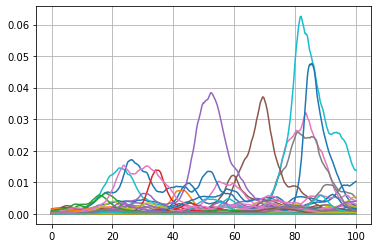

RUN  0 , total integrated cost =  30.068234099744018
Gradient descend method:  None
RUN  1 , total integrated cost =  30.068046638991667
RUN  2 , total integrated cost =  30.068475310743576
RUN  3 , total integrated cost =  10.35130356088728
RUN  4 , total integrated cost =  8.16727041739468
RUN  5 , total integrated cost =  7.030764021400623
RUN  6 , total integrated cost =  6.28052601369712
RUN  7 , total integrated cost =  6.199516475802678
RUN  8 , total integrated cost =  5.902873336536776
RUN  9 , total integrated cost =  5.938114231856273
RUN  10 , total integrated cost =  5.652775523244685
RUN  10 , total integrated cost mean =  5.652775523244685
Improved over  10  iterations in  47.939866549000726  seconds by  81.20017456132281  percent.


In [22]:
aln.params.duration = dur
zero_init = aln.getZeroControl()

mean_cost[1] = []
cost.setParams(w_p[i], w_e, w_s)

##### zero control as input for uncontrolled cost
setinit(initVars[i], aln)

bestControl[i], bestState[i], cost_[i], runtime[i], grad[i], phi[i], costnode[i], total_cost_mean_std = aln.A1(
    zero_init, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
    control_variables_ = [0,1], prec_variables_ = [0], transition_time_ = trans_time,
    noise_real=noise_realizations, init_params = initVars[i], method='M2')
    
control_list[1] = bestControl[i]
cost_list[1] = cost_[i]

In [23]:
aln.params.duration = dur
init_control = aln.getZeroControl()           
init_control[:,:,:] = control_list[1][:,:,100:-100]

cost_final = np.zeros(( noise_realizations_final ))

for n_ in range(noise_realizations_final):

    setinit(initVars[i], aln)
    state_ = fo.updateState(aln, init_control)
    cost_final[n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
    cost_final[n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)

mean_cost[1].append(np.mean(cost_final))
print('mean = ', mean_cost[1])

mean =  [24.232486682640896]


--------------------------------------------------------- 0
interpolate adjoint :  True True True


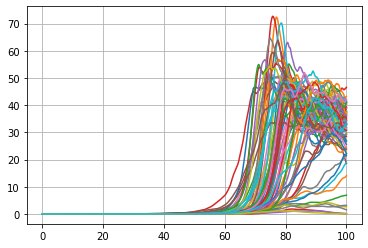

RUN  0 , total integrated cost =  23.011810167651966
Gradient descend method:  None
RUN  1 , total integrated cost =  7.5978621277596945
RUN  2 , total integrated cost =  6.685960787665013
RUN  3 , total integrated cost =  6.214873717385194
RUN  4 , total integrated cost =  6.034930078453276
RUN  5 , total integrated cost =  5.9993514743849286
RUN  6 , total integrated cost =  5.892259180811641
RUN  7 , total integrated cost =  5.867115381272176
RUN  8 , total integrated cost =  5.730458068995364
RUN  9 , total integrated cost =  5.668613960294442
RUN  10 , total integrated cost =  5.602836037984365
RUN  10 , total integrated cost mean =  5.602836037984365
Improved over  10  iterations in  52.082563955000296  seconds by  75.65234548188498  percent.
--------------------------------------------------------- 1
interpolate adjoint :  True True True


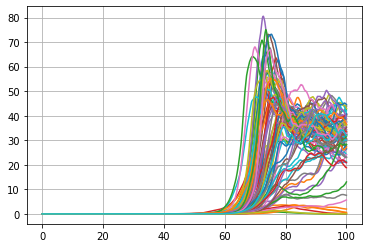

RUN  0 , total integrated cost =  15.724439401441748
Gradient descend method:  None
RUN  1 , total integrated cost =  5.6771797592878945
RUN  2 , total integrated cost =  5.617010942889715
RUN  3 , total integrated cost =  5.6186383781578595
RUN  4 , total integrated cost =  5.5943399637264335
RUN  5 , total integrated cost =  5.641186233915377
RUN  6 , total integrated cost =  5.630352487984145
RUN  7 , total integrated cost =  5.590267445806404
RUN  8 , total integrated cost =  5.68457176845248
no cost improvement
RUN  9 , total integrated cost =  5.655274290144698
RUN  10 , total integrated cost =  5.593305387074729
RUN  10 , total integrated cost mean =  5.593305387074729
Improved over  10  iterations in  87.71866021200003  seconds by  64.42922228081538  percent.
--------------------------------------------------------- 2
interpolate adjoint :  True True True


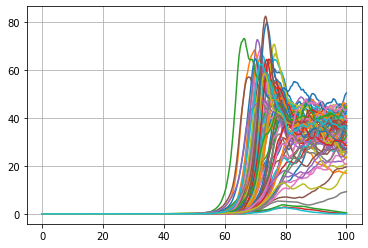

RUN  0 , total integrated cost =  10.801318139544502
Gradient descend method:  None
RUN  1 , total integrated cost =  5.67402738811421
RUN  2 , total integrated cost =  5.775014297900155
RUN  3 , total integrated cost =  5.644934178831356
RUN  4 , total integrated cost =  5.664925740752291
RUN  5 , total integrated cost =  5.625462331529029
RUN  6 , total integrated cost =  5.629087550170809
RUN  7 , total integrated cost =  5.498963352362207
RUN  8 , total integrated cost =  5.61389724843666
RUN  9 , total integrated cost =  5.503277791969376
RUN  10 , total integrated cost =  5.620618016444427
RUN  10 , total integrated cost mean =  5.620618016444427
Improved over  10  iterations in  89.62030497699925  seconds by  47.96359162992443  percent.
--------------------------------------------------------- 3
interpolate adjoint :  True True True


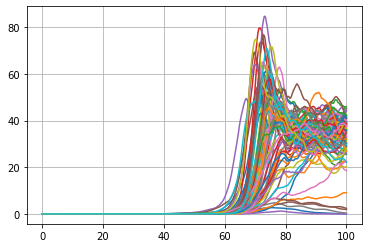

RUN  0 , total integrated cost =  11.502620949975704
Gradient descend method:  None
RUN  1 , total integrated cost =  5.625360670991905
RUN  2 , total integrated cost =  5.696247970229247
RUN  3 , total integrated cost =  5.561888703086885
RUN  4 , total integrated cost =  5.514285145601628
RUN  5 , total integrated cost =  5.470873148619815
RUN  6 , total integrated cost =  5.539960892586502
RUN  7 , total integrated cost =  5.5586395248059794
RUN  8 , total integrated cost =  5.580915243213802
RUN  9 , total integrated cost =  5.557798730680884
RUN  10 , total integrated cost =  5.493142683096354
RUN  10 , total integrated cost mean =  5.493142683096354
Improved over  10  iterations in  77.76159918800113  seconds by  52.24442579664457  percent.
--------------------------------------------------------- 4
interpolate adjoint :  True True True


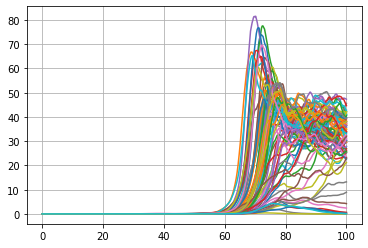

RUN  0 , total integrated cost =  15.782607689645769
Gradient descend method:  None
RUN  1 , total integrated cost =  5.640073162690207
RUN  2 , total integrated cost =  5.503804547079614
RUN  3 , total integrated cost =  5.600249387328203
RUN  4 , total integrated cost =  5.42407080048911
RUN  5 , total integrated cost =  5.610708536150263
RUN  6 , total integrated cost =  5.563298045897548
RUN  7 , total integrated cost =  5.414836033975464
RUN  8 , total integrated cost =  5.499289783754135
RUN  9 , total integrated cost =  5.569097320893309
RUN  10 , total integrated cost =  5.611605459698252
no cost improvement
RUN  10 , total integrated cost mean =  5.611605459698252
Improved over  10  iterations in  79.71030487600001  seconds by  64.44437085400175  percent.
--------------------------------------------------------- 5
interpolate adjoint :  True True True


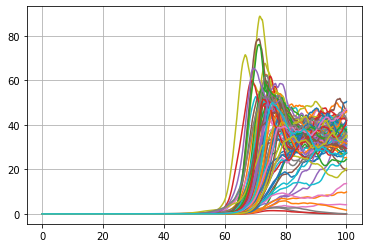

RUN  0 , total integrated cost =  12.032599131831951
Gradient descend method:  None
RUN  1 , total integrated cost =  5.628735731813085
RUN  2 , total integrated cost =  5.505004865974182
RUN  3 , total integrated cost =  5.434105428997133
RUN  4 , total integrated cost =  5.430345076115432
RUN  5 , total integrated cost =  5.545813772526645
RUN  6 , total integrated cost =  5.4987145153905646
RUN  7 , total integrated cost =  5.5186602345252815
RUN  8 , total integrated cost =  5.473273271879859
RUN  9 , total integrated cost =  5.476827452920906
RUN  10 , total integrated cost =  5.538017847707546
RUN  10 , total integrated cost mean =  5.538017847707546
Improved over  10  iterations in  70.8296552819993  seconds by  53.97488284092459  percent.
--------------------------------------------------------- 6
interpolate adjoint :  True True True


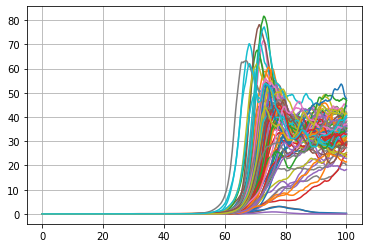

RUN  0 , total integrated cost =  11.018854880393471
Gradient descend method:  None
RUN  1 , total integrated cost =  5.418065978926463
RUN  2 , total integrated cost =  5.453718221218471
RUN  3 , total integrated cost =  5.4350680336370045
RUN  4 , total integrated cost =  5.360960419917565
RUN  5 , total integrated cost =  5.452345110081994
RUN  6 , total integrated cost =  5.5982898374240095
no cost improvement
RUN  7 , total integrated cost =  5.4118249345362965
RUN  8 , total integrated cost =  5.479575107962009
RUN  9 , total integrated cost =  5.50450607981269
RUN  10 , total integrated cost =  5.420175741149791
RUN  10 , total integrated cost mean =  5.420175741149791
Improved over  10  iterations in  73.89624727099908  seconds by  50.80999069336829  percent.
--------------------------------------------------------- 7
interpolate adjoint :  True True True


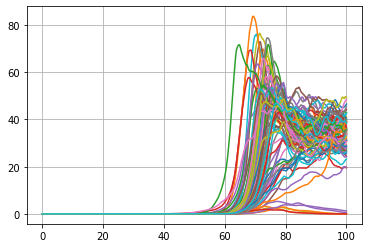

RUN  0 , total integrated cost =  12.892218638699319
Gradient descend method:  None
RUN  1 , total integrated cost =  5.474457598742494
RUN  2 , total integrated cost =  5.497988590019496
RUN  3 , total integrated cost =  5.530670960987488
RUN  4 , total integrated cost =  5.466618604491255
RUN  5 , total integrated cost =  5.4524111424445625
RUN  6 , total integrated cost =  5.4491343259679095
RUN  7 , total integrated cost =  5.478646440159258
RUN  8 , total integrated cost =  5.514895570971424
RUN  9 , total integrated cost =  5.614311707282637
no cost improvement
RUN  10 , total integrated cost =  5.620435274804292
RUN  10 , total integrated cost mean =  5.620435274804292
Improved over  10  iterations in  80.11612104600135  seconds by  56.40443718559732  percent.
--------------------------------------------------------- 8
interpolate adjoint :  True True True


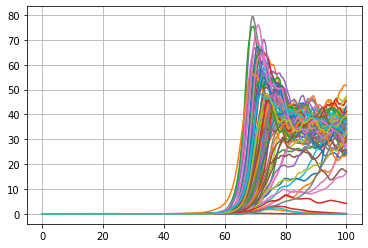

RUN  0 , total integrated cost =  13.009003735338073
Gradient descend method:  None
RUN  1 , total integrated cost =  5.5456440230522075
RUN  2 , total integrated cost =  5.55959972039755
RUN  3 , total integrated cost =  5.469352292110098
RUN  4 , total integrated cost =  5.458325739668448
RUN  5 , total integrated cost =  5.410561228644774
RUN  6 , total integrated cost =  5.374012573777265
RUN  7 , total integrated cost =  5.320596616627212
RUN  8 , total integrated cost =  5.332316999344764
RUN  9 , total integrated cost =  5.536657082822461
RUN  10 , total integrated cost =  5.432049465933739
RUN  10 , total integrated cost mean =  5.432049465933739
Improved over  10  iterations in  116.66484728500109  seconds by  58.24392415863525  percent.
--------------------------------------------------------- 9
interpolate adjoint :  True True True


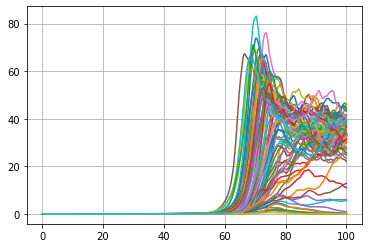

RUN  0 , total integrated cost =  18.95592836237709
Gradient descend method:  None
RUN  1 , total integrated cost =  5.554955535417084
RUN  2 , total integrated cost =  5.572090616971366
RUN  3 , total integrated cost =  5.418199376268762
RUN  4 , total integrated cost =  5.47625573392097
RUN  5 , total integrated cost =  5.499856778173072
RUN  6 , total integrated cost =  5.357639730167414
RUN  7 , total integrated cost =  5.464455570476599
RUN  8 , total integrated cost =  5.459800041091896
RUN  9 , total integrated cost =  5.400458699459915
RUN  10 , total integrated cost =  5.555252108377404
RUN  10 , total integrated cost mean =  5.555252108377404
Improved over  10  iterations in  112.20181009599946  seconds by  70.69385364737276  percent.
--------------------------------------------------------- 10
interpolate adjoint :  True True True


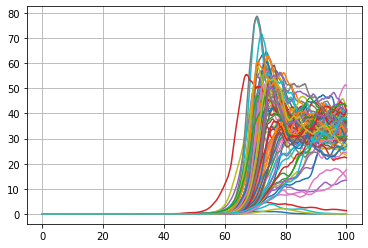

RUN  0 , total integrated cost =  11.888814867270282
Gradient descend method:  None
RUN  1 , total integrated cost =  5.463111274638387
RUN  2 , total integrated cost =  5.549357191184825
RUN  3 , total integrated cost =  5.423659374995782
RUN  4 , total integrated cost =  5.38124515603829
RUN  5 , total integrated cost =  5.562680358294226
RUN  6 , total integrated cost =  5.452601409761949
RUN  7 , total integrated cost =  5.335040092684877
RUN  8 , total integrated cost =  5.385283206527491
RUN  9 , total integrated cost =  5.464712469783431
RUN  10 , total integrated cost =  5.365313306249878
RUN  10 , total integrated cost mean =  5.365313306249878
Improved over  10  iterations in  95.09538389800036  seconds by  54.87091551050643  percent.
--------------------------------------------------------- 11
interpolate adjoint :  True True True


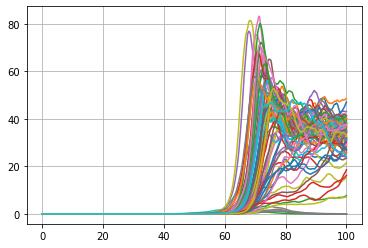

RUN  0 , total integrated cost =  15.098949181563572
Gradient descend method:  None
RUN  1 , total integrated cost =  5.403025785126882
RUN  2 , total integrated cost =  5.475998254200845
RUN  3 , total integrated cost =  5.527628801521673
RUN  4 , total integrated cost =  5.44436428326471
RUN  5 , total integrated cost =  5.457305499241788
RUN  6 , total integrated cost =  5.442007434193717
RUN  7 , total integrated cost =  5.5546799846125925
no cost improvement
RUN  8 , total integrated cost =  5.432391236734913
RUN  9 , total integrated cost =  5.514007010351302
RUN  10 , total integrated cost =  5.396997531449373
RUN  10 , total integrated cost mean =  5.396997531449373
Improved over  10  iterations in  80.69936180200057  seconds by  64.25580703298661  percent.
--------------------------------------------------------- 12
interpolate adjoint :  True True True


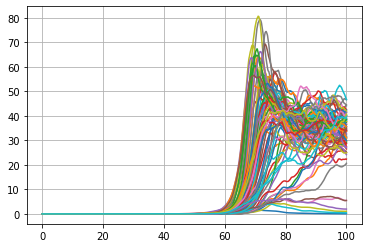

RUN  0 , total integrated cost =  11.474702903304069
Gradient descend method:  None
RUN  1 , total integrated cost =  5.40796219590559
RUN  2 , total integrated cost =  5.505956451105542
RUN  3 , total integrated cost =  5.425230454540442
RUN  4 , total integrated cost =  5.392292836503971
RUN  5 , total integrated cost =  5.461351455403995
RUN  6 , total integrated cost =  5.4465175565741895
RUN  7 , total integrated cost =  5.310754752638891
RUN  8 , total integrated cost =  5.41096309869428
RUN  9 , total integrated cost =  5.467822056546008
RUN  10 , total integrated cost =  5.452600642998161
no cost improvement
RUN  10 , total integrated cost mean =  5.452600642998161
Improved over  10  iterations in  86.74896098300087  seconds by  52.4815527779101  percent.
--------------------------------------------------------- 13
interpolate adjoint :  True True True


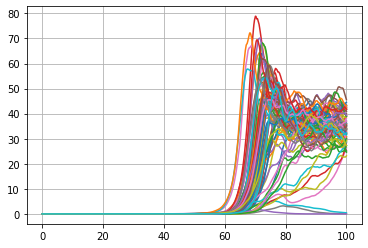

RUN  0 , total integrated cost =  10.303227457135653
Gradient descend method:  None
RUN  1 , total integrated cost =  5.551944587937721
RUN  2 , total integrated cost =  5.443606041841169
RUN  3 , total integrated cost =  5.422973207147505
RUN  4 , total integrated cost =  5.457835589451205
RUN  5 , total integrated cost =  5.407584544260625
RUN  6 , total integrated cost =  5.3515574216805115
RUN  7 , total integrated cost =  5.3651469638122595
RUN  8 , total integrated cost =  5.319268294511225
RUN  9 , total integrated cost =  5.454670415208209
RUN  10 , total integrated cost =  5.48213302676933
RUN  10 , total integrated cost mean =  5.48213302676933
Improved over  10  iterations in  86.12347064300047  seconds by  46.79207996157945  percent.
--------------------------------------------------------- 14
interpolate adjoint :  True True True


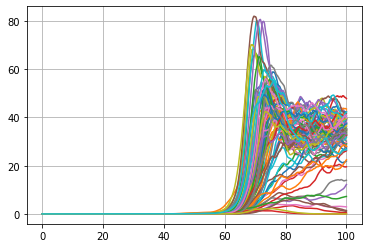

RUN  0 , total integrated cost =  13.366694551897206
Gradient descend method:  None
RUN  1 , total integrated cost =  5.394735527595502
RUN  2 , total integrated cost =  5.4581040958713105
RUN  3 , total integrated cost =  5.5207799151527865
RUN  4 , total integrated cost =  5.404834819171779
RUN  5 , total integrated cost =  5.538701709972675
no cost improvement
RUN  6 , total integrated cost =  5.459643934268963
RUN  7 , total integrated cost =  5.537240413401085
RUN  8 , total integrated cost =  5.52327853174721
RUN  9 , total integrated cost =  5.554007346846289
RUN  10 , total integrated cost =  5.517049827676872
RUN  10 , total integrated cost mean =  5.517049827676872
Improved over  10  iterations in  91.02434006399926  seconds by  58.7253991160155  percent.
--------------------------------------------------------- 15
interpolate adjoint :  True True True


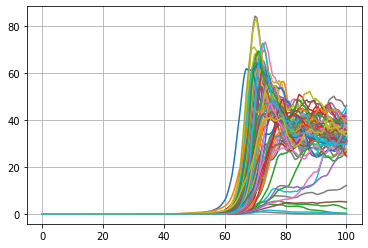

RUN  0 , total integrated cost =  11.639780134147646
Gradient descend method:  None
RUN  1 , total integrated cost =  5.558170269524567
RUN  2 , total integrated cost =  5.523115704673821
RUN  3 , total integrated cost =  5.4242296057141965
RUN  4 , total integrated cost =  5.562535901162913
RUN  5 , total integrated cost =  5.540617203173978
RUN  6 , total integrated cost =  5.442727337861761
RUN  7 , total integrated cost =  5.493622875556122
RUN  8 , total integrated cost =  5.476878851001795
RUN  9 , total integrated cost =  5.4478837463494
RUN  10 , total integrated cost =  5.463213061093413
RUN  10 , total integrated cost mean =  5.463213061093413
Improved over  10  iterations in  103.79383112600044  seconds by  53.064293327448915  percent.
--------------------------------------------------------- 16
interpolate adjoint :  True True True


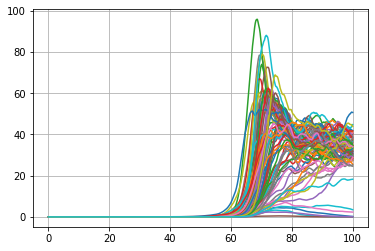

RUN  0 , total integrated cost =  12.340420980633649
Gradient descend method:  None
RUN  1 , total integrated cost =  5.400570825859171
RUN  2 , total integrated cost =  5.44288394663352
RUN  3 , total integrated cost =  5.538785569377612
RUN  4 , total integrated cost =  5.54592149715024
RUN  5 , total integrated cost =  5.539328419235391
no cost improvement
RUN  6 , total integrated cost =  5.366251848122941
RUN  6 , total integrated cost mean =  5.366251848122941
Improved over  6  iterations in  48.79380679099995  seconds by  56.51483967569316  percent.
--------------------------------------------------------- 17
interpolate adjoint :  True True True


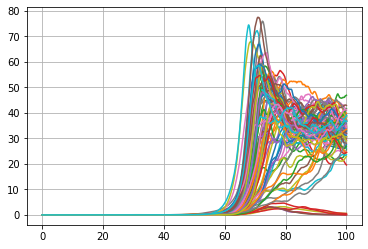

RUN  0 , total integrated cost =  13.245965822794957
Gradient descend method:  None
RUN  1 , total integrated cost =  5.34987686407093
RUN  2 , total integrated cost =  5.416375454235576
RUN  3 , total integrated cost =  5.4452030754374565
RUN  4 , total integrated cost =  5.484338046916245
RUN  5 , total integrated cost =  5.4892480531882715
no cost improvement
RUN  6 , total integrated cost =  5.449376021851885
RUN  7 , total integrated cost =  5.510970847263836
RUN  8 , total integrated cost =  5.433196526961334
RUN  9 , total integrated cost =  5.473758046195052
RUN  10 , total integrated cost =  5.560705549481024
RUN  10 , total integrated cost mean =  5.560705549481024
Improved over  10  iterations in  82.03250565899907  seconds by  58.01962934321017  percent.
--------------------------------------------------------- 18
interpolate adjoint :  True True True


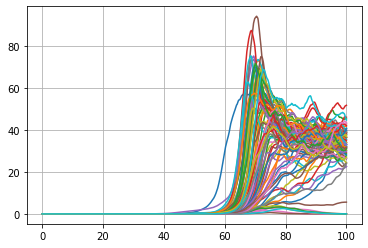

RUN  0 , total integrated cost =  15.799510455537142
Gradient descend method:  None
RUN  1 , total integrated cost =  5.534351974823268
RUN  2 , total integrated cost =  5.549774926312759
RUN  3 , total integrated cost =  5.414078015901355
RUN  4 , total integrated cost =  5.3676689995159945
RUN  5 , total integrated cost =  5.525092933569607
RUN  6 , total integrated cost =  5.57532635580056
RUN  7 , total integrated cost =  5.508359424708084
no cost improvement
RUN  8 , total integrated cost =  5.613334485798573
RUN  9 , total integrated cost =  5.551977674832422
RUN  10 , total integrated cost =  5.470778966959514
RUN  10 , total integrated cost mean =  5.470778966959514
Improved over  10  iterations in  91.94595722099984  seconds by  65.37374381088998  percent.
mean =  [24.232486682640896, 11.706885694273485, 11.765444724909834, 12.889907568243032, 12.166871650970451, 11.669385368273343, 14.152028055372119, 13.154717798879949, 11.441853248518932, 13.872044999112171, 13.068812796447

In [24]:
for k_ in range(19):
    print('---------------------------------------------------------', k_)
    setinit(initVars[i], aln)
    
    init_control = aln.getZeroControl()           
    init_control[:,:,:] = control_list[1][:,:,100:-100]

    bestControl[i], bestState[i], cost_[i], runtime[i], grad[i], phi[i], costnode[i], total_cost_mean_std = aln.A1(
        init_control, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
        control_variables_ = [0,1], prec_variables_ = prec_vars, transition_time_ = trans_time,
        noise_real=noise_realizations, init_params = initVars[i], method='M2')

    control_list[1] = bestControl[i]

    aln.params.duration = dur
    init_control = aln.getZeroControl()           
    init_control[:,:,:] = control_list[1][:,:,100:-100]

    cost_final = np.zeros(( noise_realizations_final ))

    for n_ in range(noise_realizations_final):

        setinit(initVars[i], aln)
        state_ = fo.updateState(aln, init_control)
        cost_final[n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
        cost_final[n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)

    mean_cost[1].append(np.mean(cost_final))

print('mean = ', mean_cost[1])

In [25]:
aln.params.duration = dur
zero_init = aln.getZeroControl()

##### zero control as input for uncontrolled cost
setinit(initVars[i], aln)
mean_cost[2] = []

bestControl[i], bestState[i], cost_[i], runtime[i], grad[i], phi[i], costnode[i], total_cost_mean_std = aln.A1(
    zero_init, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
    control_variables_ = [0,1], prec_variables_ = [0], transition_time_ = trans_time,
    noise_real=noise_realizations, init_params = initVars[i], method='M3')
    
control_list[2] = bestControl[i]
cost_list[2] = cost_[i]

interpolate adjoint :  True True True
RUN  0 , total integrated cost =  30.069808644246372
Gradient descend method:  None
RUN  1 , total integrated cost =  30.070886713383562
RUN  2 , total integrated cost =  30.068820054082504
RUN  3 , total integrated cost =  17.517662206427357
RUN  4 , total integrated cost =  17.078043209626266
RUN  5 , total integrated cost =  13.685433222689587
RUN  6 , total integrated cost =  12.851700794680786
RUN  7 , total integrated cost =  13.15724989925846
RUN  8 , total integrated cost =  11.122582315993695
RUN  9 , total integrated cost =  10.65925318914481
RUN  10 , total integrated cost =  10.771664377363079
RUN  10 , total integrated cost mean =  10.771664377363079
Improved over  10  iterations in  71.90936924699963  seconds by  64.17780869575253  percent.


In [26]:
aln.params.duration = dur
init_control = aln.getZeroControl()           
init_control[:,:,:] = control_list[2][:,:,100:-100]

cost_final = np.zeros(( noise_realizations_final ))

for n_ in range(noise_realizations_final):

    setinit(initVars[i], aln)
    state_ = fo.updateState(aln, init_control)
    cost_final[n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
    cost_final[n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)

mean_cost[2].append(np.mean(cost_final))
print('mean = ', mean_cost[2])

mean =  [27.787016383575565]


In [27]:
for k_ in range(19):
    print('---------------------------------------------------------', k_)
    setinit(initVars[i], aln)
    
    init_control = aln.getZeroControl()           
    init_control[:,:,:] = control_list[2][:,:,100:-100]

    bestControl[i], bestState[i], cost_[i], runtime[i], grad[i], phi[i], costnode[i], total_cost_mean_std = aln.A1(
        init_control, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
        control_variables_ = [0,1], prec_variables_ = prec_vars, transition_time_ = trans_time,
        noise_real=noise_realizations, init_params = initVars[i], method='M3')

    control_list[2] = bestControl[i]

    aln.params.duration = dur
    init_control = aln.getZeroControl()           
    init_control[:,:,:] = control_list[2][:,:,100:-100]

    cost_final = np.zeros(( noise_realizations_final ))

    for n_ in range(noise_realizations_final):

        setinit(initVars[i], aln)
        state_ = fo.updateState(aln, init_control)
        cost_final[n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
        cost_final[n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)

    mean_cost[2].append(np.mean(cost_final))

print('mean = ', mean_cost[2])

--------------------------------------------------------- 0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  31.005426847582623
Gradient descend method:  None
RUN  1 , total integrated cost =  14.610440813046342
RUN  2 , total integrated cost =  9.032675181782093
RUN  3 , total integrated cost =  8.462502897933899
RUN  4 , total integrated cost =  8.56633746583785
RUN  5 , total integrated cost =  7.995955292298044
RUN  6 , total integrated cost =  7.5540779105996165
RUN  7 , total integrated cost =  7.820060068950163
RUN  8 , total integrated cost =  10.12020681568611
RUN  9 , total integrated cost =  7.511460616695436
RUN  10 , total integrated cost =  7.6120657929669475
RUN  10 , total integrated cost mean =  7.6120657929669475
Improved over  10  iterations in  92.1147840149988  seconds by  75.44924689994896  percent.
--------------------------------------------------------- 1
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7.8355703443

RUN  8 , total integrated cost =  6.67255705518353
RUN  9 , total integrated cost =  6.734035887586225
RUN  10 , total integrated cost =  8.223387115244222
RUN  10 , total integrated cost mean =  8.223387115244222
Improved over  10  iterations in  55.19866859600006  seconds by  7.467285920351429  percent.
--------------------------------------------------------- 10
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12.708383250784246
Gradient descend method:  None
RUN  1 , total integrated cost =  8.032518042941424
RUN  2 , total integrated cost =  6.974381291924021
RUN  3 , total integrated cost =  6.819267870249851
RUN  4 , total integrated cost =  15.409491509932888
RUN  5 , total integrated cost =  8.5700097203402
RUN  6 , total integrated cost =  6.94766176588701
RUN  7 , total integrated cost =  18.237121237135334
no cost improvement
RUN  8 , total integrated cost =  8.198717347191165
RUN  9 , total integrated cost =  8.324674004219727
RUN  9 , total integrat

In [29]:
aln.params.duration = dur
zero_init = aln.getZeroControl()

mean_cost[3] = []

##### zero control as input for uncontrolled cost
setinit(initVars[i], aln)

bestControl[i], bestState[i], cost_[i], runtime[i], grad[i], phi[i], costnode[i], total_cost_mean_std = aln.A1(
    zero_init, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
    control_variables_ = [0,1], prec_variables_ = [0], transition_time_ = trans_time,
    noise_real=noise_realizations, init_params = initVars[i], method='M4')

control_list[3] = bestControl[i]
cost_list[3] = cost_[i]

interpolate adjoint :  True True True
RUN  0 , total integrated cost =  30.06957839423212
Gradient descend method:  None
RUN  1 , total integrated cost =  30.070676829868887
RUN  2 , total integrated cost =  30.06923935592771
RUN  3 , total integrated cost =  10.79134215252879
RUN  4 , total integrated cost =  6.745771487648559
RUN  5 , total integrated cost =  7.232596856753955
RUN  6 , total integrated cost =  7.045326356643211
RUN  7 , total integrated cost =  7.451316029043849
RUN  8 , total integrated cost =  7.445984584798019
RUN  9 , total integrated cost =  6.955897881210296
RUN  10 , total integrated cost =  8.256056576481615
RUN  10 , total integrated cost mean =  8.256056576481615
Improved over  10  iterations in  24.271909384000537  seconds by  72.54349073924737  percent.


In [30]:
aln.params.duration = dur
init_control = aln.getZeroControl()           
init_control[:,:,:] = control_list[3][:,:,100:-100]

cost_final = np.zeros(( noise_realizations_final ))

for n_ in range(noise_realizations_final):

    setinit(initVars[i], aln)
    state_ = fo.updateState(aln, init_control)
    cost_final[n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
    cost_final[n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)

mean_cost[3].append(np.mean(cost_final))
print('mean = ', mean_cost[3])

mean =  [22.200525738768775]


In [31]:
for k_ in range(19):
    print('---------------------------------------------------------', k_)
    setinit(initVars[i], aln)
    
    init_control = aln.getZeroControl()           
    init_control[:,:,:] = control_list[3][:,:,100:-100]

    bestControl[i], bestState[i], cost_[i], runtime[i], grad[i], phi[i], costnode[i], total_cost_mean_std = aln.A1(
        init_control, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
        control_variables_ = [0,1], prec_variables_ = prec_vars, transition_time_ = trans_time,
        noise_real=noise_realizations, init_params = initVars[i], method='M4')

    control_list[3] = bestControl[i]

    aln.params.duration = dur
    init_control = aln.getZeroControl()           
    init_control[:,:,:] = control_list[3][:,:,100:-100]

    cost_final = np.zeros(( noise_realizations_final ))

    for n_ in range(noise_realizations_final):

        setinit(initVars[i], aln)
        state_ = fo.updateState(aln, init_control)
        cost_final[n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
        cost_final[n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)

    mean_cost[3].append(np.mean(cost_final))

print('mean = ', mean_cost[3])

--------------------------------------------------------- 0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20.30643346969371
Gradient descend method:  None
RUN  1 , total integrated cost =  7.512085988776076
RUN  2 , total integrated cost =  7.3166930437629105
RUN  3 , total integrated cost =  6.7885886267925715
RUN  4 , total integrated cost =  6.675072314782454
RUN  5 , total integrated cost =  6.5642562246961464
RUN  6 , total integrated cost =  6.9329649620618685
RUN  7 , total integrated cost =  6.761609205711269
RUN  8 , total integrated cost =  6.767417201362955
RUN  9 , total integrated cost =  6.555131685628251
RUN  10 , total integrated cost =  9.457474833798404
no cost improvement
RUN  10 , total integrated cost mean =  9.457474833798404
Improved over  10  iterations in  30.537952370999847  seconds by  53.426214170434264  percent.
--------------------------------------------------------- 1
interpolate adjoint :  True True True
RUN  0 , total integrat

RUN  1 , total integrated cost =  7.967340815286025
RUN  2 , total integrated cost =  9.563287373396385
RUN  3 , total integrated cost =  7.802621715801921
RUN  4 , total integrated cost =  10.91609743238585
RUN  5 , total integrated cost =  7.668995333333276
RUN  6 , total integrated cost =  8.386461290961782
RUN  7 , total integrated cost =  7.157364824247042
RUN  8 , total integrated cost =  8.031948843566822
RUN  9 , total integrated cost =  8.943557442277664
RUN  10 , total integrated cost =  14.385842887132975
no cost improvement
RUN  10 , total integrated cost mean =  14.385842887132975
Improved over  10  iterations in  32.8048164060001  seconds by  -6.197897238248288  percent.
--------------------------------------------------------- 11
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  10.943975878696776
Gradient descend method:  None
RUN  1 , total integrated cost =  8.589899401315131
RUN  2 , total integrated cost =  8.72969490089
RUN  3 , total integrat

------
-0.3640792418819796
0.18640621352397124
0.3414258349773692
0.34923437767503585
0.28097360881653505
0.17217690070705383
0.2344307313008939
-0.0820420700457664
-0.21113077852552786
-0.12876754750469221
-0.21174058299126935
-0.1605758384019837
0.2853252041968423
0.15985426597585775
-0.0009131069187131798
0.0691677794516555
-0.7320743607006036
-0.46331793106131725
------
-0.17776271971677576
0.4435217385475112
0.3837184405966365
0.31040427559935724
0.3178909732424214
0.2553899040643228
0.12042021322010407
0.24739662662635006
0.2686519067865225
0.05856367537857388
0.1484420114022509
0.12224667175537197
0.16395448565902487
0.010025270161149936
-0.23034276902927897
-0.05804980248786576
-0.7603109683530938
-0.7229587794950123
------
-0.4453493363625342
-0.35549499026074244
-0.3675977756365878
-0.3884860305297684
-0.3306698170044085
-0.3479637191290025
-0.2831320146918417
-0.33699803963913205
-0.39941177203259043
-0.4672684743526651
-0.5387137299642287
-0.1680140671785292
0.2272069588596

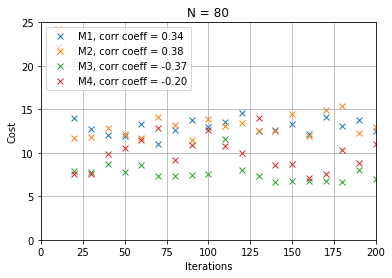

In [41]:
color = ['red', 'green', 'blue', 'orange']
l_ = ['M1', 'M2', 'M3', 'M4']

for k in range(4):
    x = np.arange(10,10*len(mean_cost[k])+1, 10)
    y = mean_cost[k]
    plt.plot( x,y, label=l_[k] + ', corr coeff = {:.2f}'.format(np.corrcoef(x[2:],y[2:])[0,1]),
             linestyle='', marker='x' )
    print('------')
    for k_ in np.arange(0,len(mean_cost[k])-2,1):
        print(np.corrcoef(x[k_:],y[k_:])[0,1])
    
plt.legend(loc='upper left')
plt.title('N = {}'.format(noise_realizations))

plt.ylim(0,25)
plt.xlim(0,200)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.savefig('method_compare_' + str(noise_realizations) + '.png')
plt.show()